2025-03-26 15:43:16.740 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


2025-03-26 15:43:19.051 | INFO     | tf_chpvk_pv.dataset:create_dataset:39 - Processing dataset...
2025-03-26 15:43:20.068 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:164 - Processing dataset complete.
2025-03-26 15:43:20.689 | INFO     | tf_chpvk_pv.dataset:train_test_split_:178 - Creating train and test dataset...
2025-03-26 15:43:20.713 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:212 - Creating train and test dataset complete.


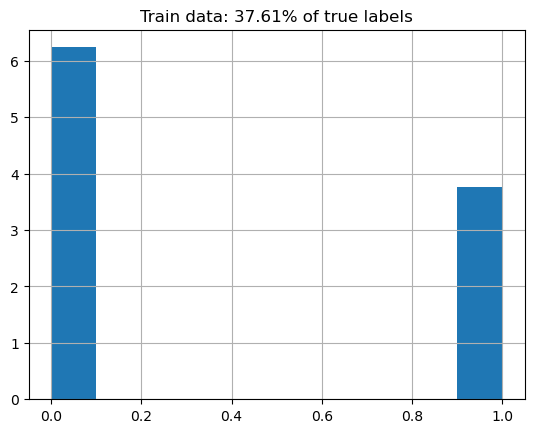

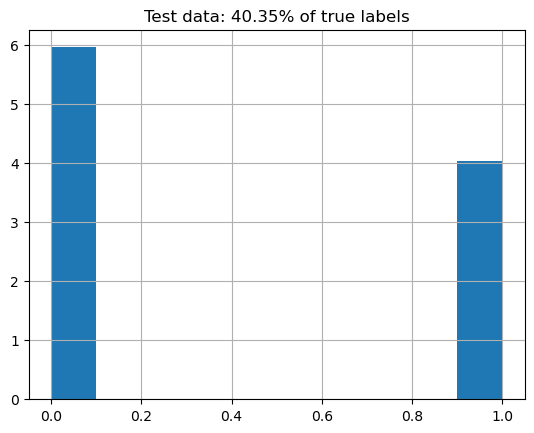

In [1]:
from tf_chpvk_pv.dataset import *
import matplotlib.pyplot as plt
import pandas as pd

df = create_dataset()

train_df, test_df = train_test_split_()

train_df.exp_label.hist(density=True)
amount_of_true = train_df[train_df.exp_label == 1].shape[0]/train_df.shape[0]
plt.title('Train data: {:.2f}% of true labels'.format(amount_of_true*100))
plt.show()
test_df.exp_label.hist(density=True)
amount_of_true = test_df[test_df.exp_label == 1].shape[0]/test_df.shape[0]
plt.title('Test data: {:.2f}% of true labels'.format(amount_of_true*100))
plt.show()

In [2]:
#count the number of material in each class in the training/test sets
dict_ch = {133.15:'F',
           180.61:'Cl',
           198.14:'Se',
           195.56:'Br',
           184.40:'S',
           219.49:'I'
          }

train_df['X'] = train_df.replace({'rX':dict_ch})['rX']
test_df['X'] = test_df.replace({'rX':dict_ch})['rX']

train_vc = pd.DataFrame(train_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())
test_vc = pd.DataFrame(test_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())

print('In the training set, %s compositions are unstable and %s are stable.' % (train_df['exp_label'].value_counts().values[0], train_df['exp_label'].value_counts().values[1]))
print('The distribution in the training set by anions is the following')
display(train_vc)

print('In the test set, %s compositions are unstable and %s are stable.' % (test_df['exp_label'].value_counts().values[0], test_df['exp_label'].value_counts().values[1]))
print('The distribution in the test set by anions is the following')
display(test_vc)

In the training set, 141 compositions are unstable and 85 are stable.
The distribution in the training set by anions is the following


count
X  exp_label       
Br 0.0           17
   1.0            4
Cl 0.0           43
   1.0           14
F  1.0           40
   0.0           13
I  0.0           29
   1.0            5
S  0.0           26
   1.0           21
Se 0.0           13
   1.0            1

In the test set, 34 compositions are unstable and 23 are stable.
The distribution in the test set by anions is the following


count
X  exp_label       
Br 0.0            5
   1.0            1
Cl 0.0           10
   1.0            4
F  1.0           11
   0.0            2
I  0.0            7
   1.0            2
S  0.0            7
   1.0            5
Se 0.0            3

In [3]:
import glob as gl
from tf_chpvk_pv.config import DATA_DIR

features_path = DATA_DIR / 'features_space/features/features/'

files = gl.glob('*.csv', root_dir=features_path)

In [ ]:
from tf_chpvk_pv.modeling.train import *
from pathlib import Path
from tf_chpvk_pv.config import DATA_DIR, RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'tolerance factors accuracy for several operations.csv'

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

features_path = DATA_DIR / 'features_space/features/features/'

df_acc_old = pd.read_csv(df_acc_old_path)

tfs = ['t', 'tau', 't_jess']
tf_tresh = [2, 1, 2]
df_acc =pd.DataFrame()
clfs = {}
t_sisso_expressions = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

for feat in files:
    #check that the tree file doesn't exist
    idx = int(feat.split('/')[-1].split('.csv')[0].split('_')[-1])

    col = 't_sisso_' + str(idx)
    
    re_do = False

    if col in df_acc_old.columns:
        no_nan_values = df_acc_old[col].isna().sum()
        if no_nan_values == 0:
            print('Tree with operations idx = %s already exists' % str(idx))
            continue
        else:
            print('Tree with operations idx = %s has %s missing values' % (str(idx), no_nan_values))
            re_do = True
    else:
        re_do = True

    if re_do:
        try:
            tf = 't_sisso_' + str(idx)
            df = pd.read_csv(features_path / feat)
            t_sisso_expression = train_tree_sis_features(features_path / feat)
            train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
            df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=1)
            clfs[tf] = clf_t
        except:
            print('Error in %s' % feat)
            continue

Classification tree accuracy (for t) on the train set: 0.637168.
Classification tree accuracy (for t) on the train set (5 fold CV): 0.606280.
Classification tree accuracy (for t) on the test set: 0.596491.
0.830243 < t < 0.868341 indicates stable perovskites.
Classification tree accuracy (for tau) on the train set: 0.884956.
Classification tree accuracy (for tau) on the train set (5 fold CV): 0.880290.
Classification tree accuracy (for tau) on the test set: 0.824561.
tau < 4.180000 indicates stable perovskites.
Classification tree accuracy (for t_jess) on the train set: 0.725664.
Classification tree accuracy (for t_jess) on the train set (5 fold CV): 0.685990.
Classification tree accuracy (for t_jess) on the test set: 0.631579.
0.835219 < t_jess < 1.022730 indicates stable perovskites.
2025-03-26 15:44:14.354 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:17:52.060 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rB_rX_ratio**2) - rA_rX_ratio|) - ((|rB_rX_ratio - log_rA_rB_ratio|) * (log_rA_rB_ratio**2))|)
Classification tree accuracy (for t_sisso_219) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_219) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_219) on the test set: 0.877193.
t_sisso_219 < 0.558454 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:18:11.774 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:18:33.971 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - sqrt(log_rA_rB_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) * exp(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_157) on the train set: 0.845133.
Classification tree accuracy (for t_sisso_157) on the train set (5 fold CV): 0.836135.
Classification tree accuracy (for t_sisso_157) on the test set: 0.859649.
t_sisso_157 < -0.844917 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:18:53.471 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) - ((1.0 / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (rB_rX_ratio - chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (chi_BX_ratio - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature exp((1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_rat

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:19:12.932 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_53) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_53) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_53) on the test set: 0.842105.
t_sisso_53 < 1.803467 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:19:34.818 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) + sqrt(sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_56) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_56) on the train set (5 fold CV): 0.844831.
Classification tree accuracy (for t_sisso_56) on the test set: 0.894737.
t_sisso_56 < 1.589339 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:19:54.536 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((sqrt(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) * sqrt(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(log_rA_rB_ratio) * rA_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) * log_rA_rB_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(r

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Feature (exp((chi_BX_ratio / rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / ((rA_rX_ratio / chi_BX_ratio)^2)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((rA_rX_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((1.0 / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio / rA_rX_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:20:33.893 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_144) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_144) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_144) on the test set: 0.877193.
t_sisso_144 < 0.578345 indicates stable perovskites.
2025-03-26 16:20:53.547 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio * log_rA_rB_ratio)|) / (|(rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|))
Classification tree accuracy (for t_sisso_208) on the train set: 0.818584.
Classification tree accuracy (for t_sisso_208) on the train set (5 fold CV): 0.818261.
Classification tree accuracy (for t_sisso_208) on the test set: 0.771930.
t_sisso_208 < 0.455295 indicates stable perovskites.
2025-03-26 16:21:12.873 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (((log_rA_rB_ratio^2) / (|chi_BX_ratio - log_rA_rB_ratio|)) / (|(rB_rX_ratio / rA_rX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((|(rB_rX_ratio / log_rA_rB_ratio) - rA_rX_ratio|) / (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree accuracy (for t_sisso_235) on the train set: 0.814159.
Classification tree accuracy (for t_sisso_235) on the train set (5 fold CV): 0.804928.
Classification tree accuracy (for t_sisso_235) on the test set: 0.859649.
t_sisso_235 < 0.703533 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:21:34.969 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_135) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_135) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_135) on the test set: 0.877193.
t_sisso_135 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:21:54.535 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio)^3) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:22:10.003 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) / ((1.0 / log_rA_rB_ratio) - rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / ((rA_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / rA_rX_ratio))
Classification tree accuracy (for t_sisso_169) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_169) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_169) on the test set: 0.877193.
t_sisso_169 < 0.606103 indicates stable perovskites.
2025-03-26 16:22:31.961 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_41) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_41) on the train set (5 fold CV): 0.862609.
Classification tree accuracy (for t_sisso_41) on the test set: 0.894737.
t_sisso_41 < 0.981273 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:22:51.910 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(log_rA_rB_ratio**2) - rB_rX_ratio|) - rA_rX_ratio|)
Classification tree accuracy (for t_sisso_250) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_250) on the train set (5 fold CV): 0.831787.
Classification tree accuracy (for t_sisso_250) on the test set: 0.789474.
t_sisso_250 < 0.664903 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:23:14.969 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) + (|(|rA_rX_ratio - log_rA_rB_ratio|) - rB_rX_ratio|))
Classification tree accuracy (for t_sisso_7) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_7) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_7) on the test set: 0.877193.
t_sisso_7 < -0.090657 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:23:38.583 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Classification tree accuracy (for t_sisso_249) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_249) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_249) on the test set: 0.842105.
t_sisso_249 < 0.210603 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:24:04.276 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / sqrt(rB_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature exp(((chi_BX_ratio / log_rA_rB_ratio) / sqrt(rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / sqrt((chi_BX_ratio / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp((exp(rA_rX_ratio) / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / sqrt((log_rA_rB_ratio / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rB_rX_ratio / rA_rX_ratio) / log_rA_rB_ratio)) has values greater t

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:24:28.116 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / chi_BX_ratio) - (rA_rX_ratio - chi_BX_ratio)) * ((chi_BX_ratio - log_rA_rB_ratio) * log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_149) on the train set: 0.778761.
Classification tree accuracy (for t_sisso_149) on the train set (5 fold CV): 0.778841.
Classification tree accuracy (for t_sisso_149) on the test set: 0.736842.
t_sisso_149 < 0.389970 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:24:54.863 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|ln(rA_rX_ratio) - (1.0 / chi_BX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skipping.
Feature (|(|ln(chi_BX_ratio) - (1.0 / chi_BX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|ln(rA_rX_ratio) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|ln(chi_BX_ratio) - (1.0 / log_rA_rB_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - chi_BX_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values g

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:25:14.914 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:25:40.677 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio * chi_BX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio)^3) / ((rB_rX_ratio^3) * log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio)^3) / ((rA_rX_ratio * log_rA_rB_ratio) * 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:26:02.003 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)) + (rA_rX_ratio + log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_115) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_115) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_115) on the test set: 0.877193.
t_sisso_115 < 5.321800 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:26:28.597 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / (exp(rA_rX_ratio) + sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_88) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_88) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_88) on the test set: 0.842105.
t_sisso_88 < 0.890013 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:26:52.513 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_137) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_137) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_137) on the test set: 0.877193.
t_sisso_137 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:27:14.499 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) * (log_rA_rB_ratio**3)) * ((log_rA_rB_ratio**3) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_167) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_167) on the train set (5 fold CV): 0.827343.
Classification tree accuracy (for t_sisso_167) on the test set: 0.824561.
t_sisso_167 < -0.017103 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:27:34.617 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) + log(log_rA_rB_ratio)) - log((rB_rX_ratio + log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_25) on the train set: 0.800885.
Classification tree accuracy (for t_sisso_25) on the train set (5 fold CV): 0.791981.
Classification tree accuracy (for t_sisso_25) on the test set: 0.736842.
t_sisso_25 < -0.343349 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:27:57.619 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio * log_rA_rB_ratio)|) / (|(rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|))
Classification tree accuracy (for t_sisso_205) on the train set: 0.818584.
Classification tree accuracy (for t_sisso_205) on the train set (5 fold CV): 0.818261.
Classification tree accuracy (for t_sisso_205) on the test set: 0.771930.
t_sisso_205 < 0.455295 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:28:18.204 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(log(rA_rX_ratio) + (rB_rX_ratio**3)) - ((|rA_rX_ratio - log_rA_rB_ratio|) + (|rB_rX_ratio - log_rA_rB_ratio|))|)
Classification tree accuracy (for t_sisso_62) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_62) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_62) on the test set: 0.894737.
t_sisso_62 < 0.460819 indicates stable perovskites.
2025-03-26 16:28:40.711 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rB_rX_ratio * log_rA_rB_ratio) * (rB_rX_ratio + log_rA_rB_ratio)) + ((chi_BX_ratio**3) + (1.0 / chi_BX_ratio)))
Classification tree accuracy (for t_sisso_76) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_76) on the train set (5 fold CV): 0.787826.
Classification tree accuracy (for t_sisso_76) on the test set: 0.736842.
t_sisso_76 < 3.140353 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:29:00.721 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - (rA_rX_ratio**2)) + ((rB_rX_ratio - log_rA_rB_ratio)**2))
Classification tree accuracy (for t_sisso_11) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_11) on the train set (5 fold CV): 0.809565.
Classification tree accuracy (for t_sisso_11) on the test set: 0.824561.
t_sisso_11 < -0.308483 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:29:24.714 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) - ((1.0 / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (rB_rX_ratio - chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - sqrt(chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (chi_BX_ratio - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (e

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:29:44.493 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_201) on the train set: 0.876106.
Classification tree accuracy (for t_sisso_201) on the train set (5 fold CV): 0.871401.
Classification tree accuracy (for t_sisso_201) on the test set: 0.877193.
t_sisso_201 < -1.192592 indicates stable perovskites.
2025-03-26 16:30:03.598 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * rA_rX_ratio) - ((|rB_rX_ratio - log_rA_rB_ratio|) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_125) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_125) on the train set (5 fold CV): 0.858068.
Classification tree accuracy (for t_sisso_125) on the test set: 0.894737.
t_sisso_125 < 1.212377 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:30:26.649 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) / (rB_rX_ratio + log_rA_rB_ratio)) / (|(rA_rX_ratio * log_rA_rB_ratio) - (rB_rX_ratio + chi_BX_ratio)|))
Classification tree accuracy (for t_sisso_36) on the train set: 0.823009.
Classification tree accuracy (for t_sisso_36) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_36) on the test set: 0.789474.
t_sisso_36 < 1.787693 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:30:46.633 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) - (rB_rX_ratio - log_rA_rB_ratio)) - ((rB_rX_ratio - log_rA_rB_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_195) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_195) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_195) on the test set: 0.877193.
t_sisso_195 < 2.627082 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:31:05.642 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (exp((rA_rX_ratio^3)) / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (chi_BX_ratio * log_rA_rB_ratio)) *

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:31:29.690 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio / log_rA_rB_ratio) + (rB_rX_ratio + log_rA_rB_ratio)) / ((rA_rX_ratio / log_rA_rB_ratio) + (chi_BX_ratio**2)))
Classification tree accuracy (for t_sisso_66) on the train set: 0.778761.
Classification tree accuracy (for t_sisso_66) on the train set (5 fold CV): 0.778841.
Classification tree accuracy (for t_sisso_66) on the test set: 0.754386.
t_sisso_66 < 0.648899 indicates stable perovskites.
2025-03-26 16:31:50.552 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + log_rA_rB_ratio) + ((1.0 / log_rA_rB_ratio) + rA_rX_ratio))
Classification tree accuracy (for t_sisso_112) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_112) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_112) on the test set: 0.877193.
t_sisso_112 < 5.321800 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:32:10.650 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio - log_rA_rB_ratio) - ln(log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio - chi_BX_ratio) - ln(log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio - log_rA_rB_ratio) - ln(log_rA_rB_ratio)) / ((log_rA

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:32:35.942 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio)^3) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:32:56.265 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (sqrt(sqrt(rA_rX_ratio)) * ((chi_BX_ratio**2)**2))
Classification tree accuracy (for t_sisso_280) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_280) on the train set (5 fold CV): 0.783382.
Classification tree accuracy (for t_sisso_280) on the test set: 0.754386.
t_sisso_280 < 2.361793 indicates stable perovskites.
2025-03-26 16:33:14.148 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_37) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_37) on the train set (5 fold CV): 0.862609.
Classification tree accuracy (for t_sisso_37) on the test set: 0.894737.
t_sisso_37 < 0.981273 indicates stable perovskites.
2025-03-26 16:33:37.257 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (|((1.0 / rA_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|)|)
Classification tree accuracy (for t_sisso_38) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_38) on the train set (5 fold CV): 0.840580.
Classification tree accuracy (for t_sisso_38) on the test set: 0.894737.
t_sisso_38 < 0.409838 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:33:59.059 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - ((|chi_BX_ratio - log_rA_rB_ratio|) / exp(chi_BX_ratio))|)
Classification tree accuracy (for t_sisso_229) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_229) on the train set (5 fold CV): 0.844831.
Classification tree accuracy (for t_sisso_229) on the test set: 0.842105.
t_sisso_229 < 0.676665 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:34:19.412 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio) - (rB_rX_ratio / log_rA_rB_ratio)) - (log(log_rA_rB_ratio) - rA_rX_ratio))
Classification tree accuracy (for t_sisso_177) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_177) on the train set (5 fold CV): 0.836135.
Classification tree accuracy (for t_sisso_177) on the test set: 0.877193.
t_sisso_177 < -0.178083 indicates stable perovskites.
2025-03-26 16:34:39.219 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (1.0 / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_93) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_93) on the train set (5 fold CV): 0.831594.
Classification tree accuracy (for t_sisso_93) on the test set: 0.859649.
t_sisso_93 < 1.174482 indicates stable perovskites.
2025-03-26 16:35:00.619 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio * log_rA_rB_ratio)|) / (|(rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|))
Classification tree accuracy (for t_sisso_206) on the train set: 0.818584.
Classification tree accuracy (for t_sisso_206) on the train set (5 fold CV): 0.818261.
Classification tree accuracy (for t_sisso_206) on the test set: 0.771930.
t_sisso_206 < 0.455295 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:35:21.939 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_128) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_128) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_128) on the test set: 0.877193.
t_sisso_128 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:35:41.342 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio + log_rA_rB_ratio) - log(log_rA_rB_ratio)) + (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_34) on the train set: 0.836283.
Classification tree accuracy (for t_sisso_34) on the train set (5 fold CV): 0.827246.
Classification tree accuracy (for t_sisso_34) on the test set: 0.842105.
t_sisso_34 < 1.453097 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:36:02.102 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((chi_BX_ratio / rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((exp(chi_BX_ratio) / rB_rX_ratio) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) / rB_rX_ratio) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) / log_rA_rB_ratio) / sqrt(rB_rX_ratio))
Classification tree accuracy (for t_sisso_310) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_310) on the train set (5 fold CV): 0.796425.
Classification tree accuracy (for t_sisso_310) on the test set: 0.771930.
t_sisso_310 < 4.470306 indicates stable perovskites.
2025-03-26 16:36:41.178 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rB_rX_ratio * chi_BX_ratio) * (chi_BX_ratio**2)) * ((chi_BX_ratio * log_rA_rB_ratio) * chi_BX_ratio))
Classification tree accuracy (for t_sisso_286) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_286) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_286) on the test set: 0.754386.
t_sisso_286 < 1.072620 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:37:02.421 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((EA_A / rB_rX_ratio) / (rB_rX_ratio^2)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio**2) - log_rA_rB_ratio) - ((rB_rX_ratio / log_rA_rB_ratio) - (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:37:23.030 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio / rB_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) * ((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio * rB_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:37:43.820 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio^3) + (1.0 / chi_BX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) + exp(rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) + rB_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) + (rB_rX_ratio^3)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio + log_r

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:38:05.447 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio + chi_BX_ratio) - (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio - rB_rX_ratio) + (log_rA_rB_ratio / rB_rX_ratio)))
Classification tree accuracy (for t_sisso_1) on the train set: 0.778761.
Classification tree accuracy (for t_sisso_1) on the train set (5 fold CV): 0.769952.
Classification tree accuracy (for t_sisso_1) on the test set: 0.789474.
t_sisso_1 < 0.342712 indicates stable perovskites.
2025-03-26 16:38:26.096 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_40) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_40) on the train set (5 fold CV): 0.862609.
Classification tree accuracy (for t_sisso_40) on the test set: 0.894737.
t_sisso_40 < 0.981273 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:38:44.337 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (ch

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:39:04.862 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) + chi_BX_ratio) + (exp(chi_BX_ratio) + sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_105) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_105) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_105) on the test set: 0.754386.
t_sisso_105 < 6.203067 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:39:23.689 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_42) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_42) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_42) on the test set: 0.842105.
t_sisso_42 < 1.803467 indicates stable perovskites.
2025-03-26 16:39:41.965 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_121) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_121) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_121) on the test set: 0.877193.
t_sisso_121 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:40:02.441 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(sqrt(rA_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - ((rA_rX_ratio + log_rA_rB_ratio) + sqrt(rB_rX_ratio))|)
Classification tree accuracy (for t_sisso_52) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_52) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_52) on the test set: 0.859649.
t_sisso_52 < 1.081624 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:40:22.836 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - chi_BX_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rB_rX_ratio - chi_BX_ratio|) - (1.0 / chi_BX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(1.0 / rB_rX_ratio) - (|chi_BX_ratio - log_rA_rB_ratio|)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rB_rX_ratio - chi_BX_ratio|) - exp(log_rA_rB_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - exp(lo

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((EA_A * chi_BX_ratio) * (rA_rX_ratio + rB_rX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_74) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_74) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_74) on the test set: 0.736842.
t_sisso_74 < -0.095463 indicates stable perovskites.
2025-03-26 16:41:03.219 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (|((|rB_rX_ratio - log_rA_rB_ratio|) * sqrt(log_rA_rB_ratio)) - (sqrt(log_rA_rB_ratio) * rA_rX_ratio)|)
Classification tree accuracy (for t_sisso_224) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_224) on the train set (5 fold CV): 0.844831.
Classification tree accuracy (for t_sisso_224) on the test set: 0.859649.
t_sisso_224 < 0.545989 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:41:22.762 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) - exp(log_rA_rB_ratio)) - (exp(rB_rX_ratio) - rA_rX_ratio))
Classification tree accuracy (for t_sisso_155) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_155) on the train set (5 fold CV): 0.818551.
Classification tree accuracy (for t_sisso_155) on the test set: 0.842105.
t_sisso_155 < -2.062076 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:41:43.442 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (1.0 / ((rA_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (1.0 / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((chi_BX_ratio**3) * (chi_BX_ratio * log_rA_rB_ratio)) * (rB_rX_ratio * chi_BX_ratio))
Classification tree accuracy (for t_sisso_285) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_285) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_285) on the test set: 0.754386.
t_sisso_285 < 1.072620 indicates stable perovskites.
2025-03-26 16:42:01.850 | INFO     | tf_chpvk_pv.modeling.train:trai

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Feature (((rA_rX_ratio + log_rA_rB_ratio) + sqrt(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) + (rA_rX_ratio + log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) + exp(rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) + exp(rA_rX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:42:24.625 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((exp(rB_rX_ratio) * sqrt(log_rA_rB_ratio)) * ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_282) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_282) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_282) on the test set: 0.754386.
t_sisso_282 < 9.194284 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:42:45.245 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Classification tree accuracy (for t_sisso_259) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_259) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_259) on the test set: 0.842105.
t_sisso_259 < 0.210603 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:43:08.224 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (exp((rA_rX_ratio / log_rA_rB_ratio)) / (|(chi_BX_ratio^2) - (|chi_BX_ratio - log_rA_rB_ratio|)|)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((|(rB_rX_ratio / log_rA_rB_ratio) - rA_rX_ratio|) / (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree accuracy (for t_sisso_226) on the train set: 0.814159.
Classification tree accuracy (for t_sisso_226) on the train set (5 fold CV): 0.804928.
Clas

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:43:30.789 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / sqrt(rB_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((rA_rX_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((1.0 / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature exp(((chi_BX_ratio / log_rA_rB_ratio) / sqrt(rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / sqrt((chi_BX_ratio / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp((exp(rA_rX_ratio) / log_rA_rB_ratio)) has values greater than 1e6. Skippin

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:43:50.303 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rA_rX_ratio) - rB_rX_ratio) - ((rB_rX_ratio**2) + (log_rA_rB_ratio**2)))
Classification tree accuracy (for t_sisso_22) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_22) on the train set (5 fold CV): 0.765314.
Classification tree accuracy (for t_sisso_22) on the test set: 0.824561.
t_sisso_22 < 1.415231 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:44:08.975 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - (|log(log_rA_rB_ratio) - log_rA_rB_ratio|)|)
Classification tree accuracy (for t_sisso_218) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_218) on the train set (5 fold CV): 0.840386.
Classification tree accuracy (for t_sisso_218) on the test set: 0.877193.
t_sisso_218 < 0.401366 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:44:32.448 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - chi_BX_ratio|) - (|rA_rX_ratio - log_rA_rB_ratio|)|) - (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|)|)
Classification tree accuracy (for t_sisso_246) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_246) on the train set (5 fold CV): 0.844928.
Classification tree accuracy (for t_sisso_246) on the test set: 0.877193.
t_sisso_246 < 0.469588 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:44:52.289 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * chi_BX_ratio) * (rA_rX_ratio + rB_rX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_83) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_83) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_83) on the test set: 0.736842.
t_sisso_83 < -0.095463 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:45:12.107 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio / chi_BX_ratio) + (chi_BX_ratio**3)))
Classification tree accuracy (for t_sisso_97) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_97) on the train set (5 fold CV): 0.822705.
Classification tree accuracy (for t_sisso_97) on the test set: 0.789474.
t_sisso_97 < 1.723119 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:45:32.874 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) - (log_rA_rB_ratio / rA_rX_ratio)) - ((rB_rX_ratio / log_rA_rB_ratio) / exp(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_127) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_127) on the train set (5 fold CV): 0.827150.
Classification tree accuracy (for t_sisso_127) on the test set: 0.877193.
t_sisso_127 < -0.892101 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:45:55.752 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio - log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_16) on the train set: 0.800885.
Classification tree accuracy (for t_sisso_16) on the train set (5 fold CV): 0.791981.
Classification tree accuracy (for t_sisso_16) on the test set: 0.824561.
t_sisso_16 < 0.971335 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:46:16.885 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - chi_BX_ratio|) - (|rA_rX_ratio - log_rA_rB_ratio|)|) - (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|)|)
Classification tree accuracy (for t_sisso_245) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_245) on the train set (5 fold CV): 0.844928.
Classification tree accuracy (for t_sisso_245) on the test set: 0.877193.
t_sisso_245 < 0.469588 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:46:38.318 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (1.0 / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_92) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_92) on the train set (5 fold CV): 0.831594.
Classification tree accuracy (for t_sisso_92) on the test set: 0.859649.
t_sisso_92 < 1.174482 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:47:04.358 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / rA_rX_ratio))
Classification tree accuracy (for t_sisso_170) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_170) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_170) on the test set: 0.877193.
t_sisso_170 < 0.606103 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:47:30.804 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) + chi_BX_ratio) / ((log_rA_rB_ratio / chi_BX_ratio) + (log_rA_rB_ratio**2)))
Classification tree accuracy (for t_sisso_96) on the train set: 0.778761.
Classification tree accuracy (for t_sisso_96) on the train set (5 fold CV): 0.778841.
Classification tree accuracy (for t_sisso_96) on the test set: 0.736842.
t_sisso_96 < 0.843741 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:48:00.369 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * rA_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) * exp(rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:48:24.917 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / rA_rX_ratio))
Classification tree accuracy (for t_sisso_173) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_173) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_173) on the test set: 0.877193.
t_sisso_173 < 0.606103 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:48:52.957 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio^2) / (log_rA_rB_ratio^3)) / ((rB_rX_ratio^3) * (log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) / (log_rA_rB_ratio^3)) / ((rB_rX_ratio^3) * (log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio)^3) / ((rB_rX_ratio^3) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio^3) / (rB_rX_ratio^2)) / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((l

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:49:23.640 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * sqrt(chi_BX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_290) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_290) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_290) on the test set: 0.719298.
t_sisso_290 < -0.042964 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:50:00.987 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(1.0 / (rA_rX_ratio * chi_BX_ratio)) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skipping.
Feature ((|(|rB_rX_ratio - log_rA_rB_ratio|) - exp(log_rA_rB_ratio)|) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio * rB_rX_ratio) - exp(rA_rX_ratio)|) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((|(|rA_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values grea

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:50:34.077 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / log_rA_rB_ratio) * (exp(chi_BX_ratio) - (chi_BX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_148) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_148) on the train set (5 fold CV): 0.840676.
Classification tree accuracy (for t_sisso_148) on the test set: 0.842105.
t_sisso_148 < 2.043626 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:51:05.757 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|(|chi_BX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|((log_rA_rB_ratio / rA_rX_ratio) / rB_rX_ratio) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio / rA_rX_ratio)|)) has values greater than 1e6. Skipping.
Feature (|(|(log_rA_rB_ratio / rB_rX_ratio) - rB_rX_ratio|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:51:34.750 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) - exp(log_rA_rB_ratio)) - (exp(rB_rX_ratio) - rA_rX_ratio))
Classification tree accuracy (for t_sisso_158) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_158) on the train set (5 fold CV): 0.818551.
Classification tree accuracy (for t_sisso_158) on the test set: 0.842105.
t_sisso_158 < -2.062076 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:52:03.170 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (chi_BX_ratio * log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / log_rA_rB_ratio) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (rA_rX_ratio * log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((rA_rX_ratio * log_rA

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:52:29.868 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((chi_BX_ratio / rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / sqrt(rB_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio / rA_rX_ratio)^2)) has values greater than 1e6. Skipping.
Feature exp(((chi_BX_ratio / log_rA_rB_ratio) / sqrt(rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / sqrt((chi_BX_ratio / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:52:58.422 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio) - ((1.0 / log_rA_rB_ratio) - rB_rX_ratio))
Classification tree accuracy (for t_sisso_196) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_196) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_196) on the test set: 0.877193.
t_sisso_196 < -1.975124 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:53:30.109 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio**2) * log_rA_rB_ratio) * (|sqrt(rB_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree accuracy (for t_sisso_220) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_220) on the train set (5 fold CV): 0.853816.
Classification tree accuracy (for t_sisso_220) on the test set: 0.877193.
t_sisso_220 < 0.234302 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:53:59.583 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) - EA_A) * ((rA_rX_ratio**3) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_166) on the train set: 0.823009.
Classification tree accuracy (for t_sisso_166) on the train set (5 fold CV): 0.822995.
Classification tree accuracy (for t_sisso_166) on the test set: 0.789474.
t_sisso_166 < 0.062917 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:54:29.792 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * (rB_rX_ratio * log_rA_rB_ratio)) * ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_291) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_291) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_291) on the test set: 0.736842.
t_sisso_291 < 1.955000 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:54:58.726 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / (log_rA_rB_ratio^2))^2) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio)^2) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio)^2) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio) / ln(log_rA_rB_ratio))^2) has values greater than 1e6. Skip

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:55:29.242 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((EA_A * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((EA_A * log_rA_rB_ratio) * ln(chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (log_rA_rB_ratio^2)) / (ln(chi_BX_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / (rA_rX_ratio * log_rA_rB_ratio)) / (ln(chi_BX_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / (rB_r

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:55:57.213 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio - log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_20) on the train set: 0.800885.
Classification tree accuracy (for t_sisso_20) on the train set (5 fold CV): 0.791981.
Classification tree accuracy (for t_sisso_20) on the test set: 0.824561.
t_sisso_20 < 0.971335 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:56:23.008 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) + (log_rA_rB_ratio / rA_rX_ratio))
Classification tree accuracy (for t_sisso_89) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_89) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_89) on the test set: 0.877193.
t_sisso_89 < 1.606103 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:56:49.676 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio + log_rA_rB_ratio) + (chi_BX_ratio**3)) - ((chi_BX_ratio - log_rA_rB_ratio) + (log_rA_rB_ratio**3)))
Classification tree accuracy (for t_sisso_33) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_33) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_33) on the test set: 0.736842.
t_sisso_33 < 2.228706 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:57:18.422 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|(rA_rX_ratio^3) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(1.0 / rB_rX_ratio) - (chi_BX_ratio^3)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skipping.
Feature (|(1.0 / (rA_rX_ratio^3)) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(rB_rX_ratio^3) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - chi_BX_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:57:41.861 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rB_rX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A^2) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(rA_rX_ratio)) / ((rB_rX_ratio^3)^3)) ha

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:58:04.111 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio + log_rA_rB_ratio) - (chi_BX_ratio**2)) / ((rB_rX_ratio - chi_BX_ratio) + (chi_BX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_17) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_17) on the train set (5 fold CV): 0.783285.
Classification tree accuracy (for t_sisso_17) on the test set: 0.754386.
t_sisso_17 < -0.235298 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:58:30.404 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((|rA_rX_ratio - chi_BX_ratio|)**2) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_50) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_50) on the train set (5 fold CV): 0.844928.
Classification tree accuracy (for t_sisso_50) on the test set: 0.877193.
t_sisso_50 < 0.947477 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:58:56.021 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((rA_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (1.0 / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * (rB_rX_ratio * log_rA_rB_ratio)) * ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_288) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_288) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_288) on the test set: 0.736842.
t_sisso_288 < 1.955000 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:59:24.763 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) + chi_BX_ratio) * ((chi_BX_ratio**2)**2))
Classification tree accuracy (for t_sisso_80) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_80) on the train set (5 fold CV): 0.783382.
Classification tree accuracy (for t_sisso_80) on the test set: 0.754386.
t_sisso_80 < 5.211787 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 16:59:50.567 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rB_rX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(rA_rX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rA_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:00:12.367 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) * ((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) / ((log_rA_rB_ratio / rB_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) * ((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) / ((log_rA_rB_ratio / rA_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) * ((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((|rB_rX_ratio - log_rA_rB_ratio|) / (rB_rX_r

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:00:42.599 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_193) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_193) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_193) on the test set: 0.842105.
t_sisso_193 < 0.414099 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:01:08.914 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) / ((1.0 / rA_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / chi_BX_ratio) + exp(rA_rX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) + (log_rA_rB_ratio / chi_BX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) + (rB_rX_ratio / chi_BX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:01:34.964 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - (|log(log_rA_rB_ratio) - log_rA_rB_ratio|)|)
Classification tree accuracy (for t_sisso_248) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_248) on the train set (5 fold CV): 0.840386.
Classification tree accuracy (for t_sisso_248) on the test set: 0.877193.
t_sisso_248 < 0.401366 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:02:01.324 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - sqrt(rB_rX_ratio)) + (sqrt(log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_35) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_35) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_35) on the test set: 0.842105.
t_sisso_35 < 0.414099 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:02:26.903 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio + rB_rX_ratio) - (log_rA_rB_ratio**3)|) - ((rB_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio))|)
Classification tree accuracy (for t_sisso_46) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_46) on the train set (5 fold CV): 0.858164.
Classification tree accuracy (for t_sisso_46) on the test set: 0.859649.
t_sisso_46 < 0.384473 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:02:54.796 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) + ((rA_rX_ratio + log_rA_rB_ratio) / rA_rX_ratio))
Classification tree accuracy (for t_sisso_86) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_86) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_86) on the test set: 0.877193.
t_sisso_86 < 2.606103 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:03:24.638 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rB_rX_ratio + log_rA_rB_ratio) - (log_rA_rB_ratio**3)) + ((chi_BX_ratio**3) - (chi_BX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_23) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_23) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_23) on the test set: 0.736842.
t_sisso_23 < 2.228706 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:03:50.609 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((log_rA_rB_ratio / rB_rX_ratio) * log(log_rA_rB_ratio)) / (log(rA_rX_ratio) - (rB_rX_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_153) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_153) on the train set (5 fold CV): 0.849179.
Classification tree accuracy (for t_sisso_153) on the test set: 0.877193.
t_sisso_153 < 0.884001 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:04:14.282 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((1.0 / rA_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|)|)
Classification tree accuracy (for t_sisso_55) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_55) on the train set (5 fold CV): 0.840580.
Classification tree accuracy (for t_sisso_55) on the test set: 0.894737.
t_sisso_55 < 0.409838 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:04:38.883 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio)**2) + (log(log_rA_rB_ratio)**2))
Classification tree accuracy (for t_sisso_106) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_106) on the train set (5 fold CV): 0.814010.
Classification tree accuracy (for t_sisso_106) on the test set: 0.771930.
t_sisso_106 < 0.928798 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:05:08.242 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * rA_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) * exp(rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:05:36.580 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_136) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_136) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_136) on the test set: 0.877193.
t_sisso_136 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:06:05.546 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * exp(log_rA_rB_ratio)) * log((rB_rX_ratio * log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_284) on the train set: 0.823009.
Classification tree accuracy (for t_sisso_284) on the train set (5 fold CV): 0.809662.
Classification tree accuracy (for t_sisso_284) on the test set: 0.824561.
t_sisso_284 < -1.582279 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:06:52.571 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)|) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))|)
Classification tree accuracy (for t_sisso_212) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_212) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_212) on the test set: 0.894737.
t_sisso_212 < 0.247938 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:07:21.393 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_143) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_143) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_143) on the test set: 0.877193.
t_sisso_143 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:07:50.457 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / (log_rA_rB_ratio^2))^2) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio)^2) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio) / ln(log_rA_rB_ratio))^2) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio)^2) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skip

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:08:22.614 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^2) / (|rA_rX_ratio - log_rA_rB_ratio|)) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((log_rA_rB_ratio^2) / (|chi_BX_ratio - log_rA_rB_ratio|)) / (|(rB_rX_ratio / rA_rX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|(|rA_rX_ratio - log_rA_rB_ratio|) - rB_rX_ratio|)|)
Cl

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:08:48.826 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature exp(((chi_BX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio + log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio + rB_rX_ratio) + (rA_rX_ratio + log_rA_rB_ratio)) + ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_104) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_104) on the train set (5 fold CV): 0.783382.
Classification tree accuracy (for t_sisso_104) on the test set: 0.754386.
t_sisso_104 < 9.868897 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:09:13.128 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((1.0 / rA_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|)|)
Classification tree accuracy (for t_sisso_54) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_54) on the train set (5 fold CV): 0.840580.
Classification tree accuracy (for t_sisso_54) on the test set: 0.894737.
t_sisso_54 < 0.409838 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:09:36.553 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rB_rX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(rA_rX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rA_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:09:57.657 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio**2)|) - ((chi_BX_ratio / rA_rX_ratio) + (|chi_BX_ratio - log_rA_rB_ratio|))|)
Classification tree accuracy (for t_sisso_45) on the train set: 0.836283.
Classification tree accuracy (for t_sisso_45) on the train set (5 fold CV): 0.809469.
Classification tree accuracy (for t_sisso_45) on the test set: 0.859649.
t_sisso_45 < 0.587087 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:10:20.993 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / ((chi_BX_ratio * log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_68) on the train set: 0.769912.
Classification tree accuracy (for t_sisso_68) on the train set (5 fold CV): 0.769952.
Classification tree accuracy (for t_sisso_68) on the test set: 0.736842.
t_sisso_68 < 2.181409 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:10:46.563 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3)) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rA_rX_ratio)|)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3)^3) / ((|rB_rX_ratio - log_rA_rB_ratio|)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (|rB_rX_ratio - log_rA_rB_ratio|))^3) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3)^2) / ((|rB_rX_ratio - log_rA_rB_ratio|)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^2) / (|rB_rX_ratio - log_rA_rB_ratio|))^3) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Ski

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:11:10.083 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_0) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_0) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_0) on the test set: 0.877193.
t_sisso_0 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:11:33.065 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio / chi_BX_ratio) + (chi_BX_ratio**3)))
Classification tree accuracy (for t_sisso_94) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_94) on the train set (5 fold CV): 0.822705.
Classification tree accuracy (for t_sisso_94) on the test set: 0.789474.
t_sisso_94 < 1.723119 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:11:55.904 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (1.0 / log_rA_rB_ratio)) + ((1.0 / rB_rX_ratio) + sqrt(chi_BX_ratio)))
Classification tree accuracy (for t_sisso_77) on the train set: 0.809735.
Classification tree accuracy (for t_sisso_77) on the train set (5 fold CV): 0.800966.
Classification tree accuracy (for t_sisso_77) on the test set: 0.824561.
t_sisso_77 < 6.298115 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:12:21.399 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((|rB_rX_ratio - log_rA_rB_ratio|) / sqrt(rB_rX_ratio)) - (rA_rX_ratio + log_rA_rB_ratio)|)
Classification tree accuracy (for t_sisso_47) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_47) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_47) on the test set: 0.877193.
t_sisso_47 < 1.224058 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:12:46.248 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio / chi_BX_ratio) + (chi_BX_ratio**3)))
Classification tree accuracy (for t_sisso_67) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_67) on the train set (5 fold CV): 0.822705.
Classification tree accuracy (for t_sisso_67) on the test set: 0.789474.
t_sisso_67 < 1.723119 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:13:12.048 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + rB_rX_ratio) + (log_rA_rB_ratio**2)) / ((rA_rX_ratio**2) + sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_95) on the train set: 0.845133.
Classification tree accuracy (for t_sisso_95) on the train set (5 fold CV): 0.831691.
Classification tree accuracy (for t_sisso_95) on the test set: 0.824561.
t_sisso_95 < 1.128837 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:13:35.934 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (exp((rB_rX_ratio / log_rA_rB_ratio)) / (exp(rA_rX_ratio) * (rB_rX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_264) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_264) on the train set (5 fold CV): 0.836135.
Classification tree accuracy (for t_sisso_264) on the test set: 0.877193.
t_sisso_264 < 1.194927 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:14:01.370 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (1.0 / rB_rX_ratio)) + (1.0 / log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_110) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_110) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_110) on the test set: 0.877193.
t_sisso_110 < 5.321800 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:14:34.083 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio)**2) - (log(log_rA_rB_ratio) - rA_rX_ratio))
Classification tree accuracy (for t_sisso_32) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_32) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_32) on the test set: 0.736842.
t_sisso_32 < 1.999836 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:15:01.474 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) / rB_rX_ratio) / ((rA_rX_ratio - chi_BX_ratio) - sqrt(rB_rX_ratio)))
Classification tree accuracy (for t_sisso_179) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_179) on the train set (5 fold CV): 0.800773.
Classification tree accuracy (for 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:15:25.248 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3)) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rA_rX_ratio)|)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3)^3) / ((|rB_rX_ratio - log_rA_rB_ratio|)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (|rB_rX_ratio - log_rA_rB_ratio|))^3) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^3)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature ((chi_BX_ratio / (log_rA_rB_ratio^3)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3)) / (|(rA_rX_ratio / chi_BX_ratio) - chi_BX_ratio|)) has values greater than 1e6. Skipping.
Feature 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:15:51.804 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_192) on the train set: 0.876106.
Classification tree accuracy (for t_sisso_192) on the train set (5 fold CV): 0.871401.
Classification tree accuracy (for t_sisso_192) on the test set: 0.877193.
t_sisso_192 < -1.192592 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:16:23.958 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_183) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_183) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_183) on the test set: 0.859649.
t_sisso_183 < 0.871024 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:16:49.725 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((ln(rA_rX_ratio) + (rA_rX_ratio + log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) + ln(rB_rX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + ln(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_3) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_3) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_3) on the test set: 0.877193.
t_sisso_3 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:17:32.849 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio - log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_19) on the train set: 0.800885.
Classification tree accuracy (for t_sisso_19) on the train set (5 fold CV): 0.791981.
Classification tree accuracy (for t_sisso_19) on the test set: 0.824561.
t_sisso_19 < 0.971335 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:17:52.563 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|((chi_BX_ratio**3) - (log_rA_rB_ratio / rB_rX_ratio)) - ((|chi_BX_ratio - log_rA_rB_ratio|) / (rA_rX_ratio - rB_rX_ratio))|)
Classification tree accuracy (for t_sisso_130) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_130) on the train set (5 fold CV): 0.840483.
Classification tree accuracy (for t_sisso_130) on the test set: 0.877193.
t_sisso_130 < 1.344237 indicates stable

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:18:14.737 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|(|rA_rX_ratio - log_rA_rB_ratio|) - rB_rX_ratio|)|)
Classification tree accuracy (for t_sisso_209) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_209) on the train set (5 fold CV): 0.835845.
Classification tree accuracy (for t_sisso_209) on the test set: 0.877193.
t_sisso_209 < 0.104760 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:18:34.930 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_126) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_126) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_126) on the test set: 0.877193.
t_sisso_126 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:18:54.643 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) - (rB_rX_ratio - log_rA_rB_ratio)) - ((rB_rX_ratio - log_rA_rB_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_197) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_197) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_197) on the test set: 0.877193.
t_sisso_197 < 2.627082 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:19:17.184 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / ch

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:19:40.290 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (log((rA_rX_ratio + rB_rX_ratio)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - sqrt(log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_63) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_63) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_63) on the test set: 0.894737.
t_sisso_63 < 0.908023 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:20:12.312 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Classification tree accuracy (for t_sisso_258) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_258) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_258) on the test set: 0.842105.
t_sisso_258 < 0.210603 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:20:35.513 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) * (chi_BX_ratio**3)) * exp((chi_BX_ratio**3)))
Classification tree accuracy (for t_sisso_279) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_279) on the train set (5 fold CV): 0.783285.
Classification tree accuracy (for t_sisso_279) on the test set: 0.736842.
t_sisso_279 < 18.278926 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:20:58.852 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio)**3) + (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_119) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_119) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_119) on the test set: 0.842105.
t_sisso_119 < -0.662716 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:21:19.569 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Classification tree accuracy (for t_sisso_233) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_233) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_233) on the test set: 0.877193.
t_sisso_233 < 4.315873 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:21:40.079 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / sqrt(rB_rX_ratio))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - ((|chi_BX_ratio - log_rA_rB_ratio|) / exp(chi_BX_ratio))|)
Classification tree accuracy (for t_sisso_228) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_228) on the train set (5 fold CV): 0.844831.
Classification tree accuracy (for t_sisso_228) on the test set: 0.842105.
t_sisso_228 < 0.676665 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:21:59.941 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_39) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_39) on the train set (5 fold CV): 0.862609.
Classification tree accuracy (for t_sisso_39) on the test set: 0.894737.
t_sisso_39 < 0.981273 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:22:20.482 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_141) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_141) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_141) on the test set: 0.877193.
t_sisso_141 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:22:41.738 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / ch

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:23:01.171 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio)**2) + (log(log_rA_rB_ratio)**2))
Classification tree accuracy (for t_sisso_118) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_118) on the train set (5 fold CV): 0.814010.
Classification tree accuracy (for t_sisso_118) on the test set: 0.771930.
t_sisso_118 < 0.928798 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:23:19.413 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio * chi_BX_ratio) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio / rA_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) * (chi_BX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio^3) / log_rA_rB_ratio) / ((rB_rX_ratio * log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio)^3) / ((rA_rX_ratio * log_rA_rB_ratio) * 

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:23:40.284 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_124) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_124) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_124) on the test set: 0.877193.
t_sisso_124 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:23:59.271 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_57) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_57) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_57) on the test set: 0.842105.
t_sisso_57 < 1.803467 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:24:17.867 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * exp(chi_BX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_283) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_283) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_283) on the test set: 0.719298.
t_sisso_283 < -0.100853 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:24:39.681 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_198) on the train set: 0.876106.
Classification tree accuracy (for t_sisso_198) on the train set (5 fold CV): 0.871401.
Classification tree accuracy (for t_sisso_198) on the test set: 0.877193.
t_sisso_198 < -1.192592 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:24:58.545 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rB_rX_ratio) * (log_rA_rB_ratio / rA_rX_ratio)) + ((chi_BX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio)))
Classification tree accuracy (for t_sisso_64) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_64) on the train set (5 fold CV): 0.849372.
Classification tree accuracy (for t_sisso_64) on the test set: 0.842105.
t_sisso_64 < 1.701942 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:25:17.545 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio)**3) + (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_117) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_117) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_117) on the test set: 0.842105.
t_sisso_117 < -0.662716 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:25:39.665 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(|rA_rX_ratio - chi_BX_ratio|) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_247) on the train set: 0.836283.
Classification tree accuracy (for t_sisso_247) on the train set (5 fold CV): 0.827343.
Classification tree accuracy (for t_sisso_247) on the test set: 0.771930.
t_sisso_247 < 0.416150 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:25:58.155 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature exp(((chi_BX_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((log(rB_rX_ratio)**3) + (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_108) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_108) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_108) on the test set: 0.842105.
t_sisso_108 < -0.662716 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:26:20.445 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio / rA_rX_ratio) + (chi_BX_ratio / log_rA_rB_ratio)) + (log(log_rA_rB_ratio) / log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_99) on the train set: 0.774336.
Classification tree accuracy (for t_sisso_99) on the train set (5 fold CV): 0.769952.
Classification tree accuracy (for t_sisso_99) on the test set: 0.736842.
t_sisso_99 < 1.777296 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:26:42.551 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_2) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_2) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_2) on the test set: 0.877193.
t_sisso_2 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:27:02.220 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_142) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_142) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_142) on the test set: 0.877193.
t_sisso_142 < 0.578345 indicates stable perovskites.
2025-03-26 17:27:21.373 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * rA_rX_ratio) * (|sqrt(rB_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree accuracy (for t_sisso_222) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_222) on the train set (5 fold CV): 0.853816.
Classification tree accuracy (for t_sisso_222) on the test set: 0.877193.
t_sisso_222 < 0.234302 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:27:43.155 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|((rA_rX_ratio**2) - (rB_rX_ratio / log_rA_rB_ratio)) - (|(rB_rX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio|)|)
Classification tree accuracy (for t_sisso_129) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_129) on the train set (5 fold CV): 0.836135.
Classification tree accuracy (for t_sisso_129) on the test set: 0.859649.
t_sisso_129 < 0.789923 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:28:02.628 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - sqrt(rB_rX_ratio)) + (sqrt(log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_24) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_24) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_24) on the test set: 0.842105.
t_sisso_24 < 0.414099 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:28:21.676 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) - ((1.0 / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (rB_rX_ratio - chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (chi_BX_ratio - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature exp((1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_rat

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:28:42.504 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / chi_BX_ratio) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)) / ((chi_BX_rati

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:29:05.650 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / log_rA_rB_ratio) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:29:23.380 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio * chi_BX_ratio) * log(log_rA_rB_ratio)) + ((rB_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_69) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_69) on the train set (5 fold CV): 0.787536.
Classification tree accuracy (for t_sisso_69) on the test set: 0.842105.
t_sisso_69 < 1.290469 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:29:43.347 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (1.0 / rB_rX_ratio)) + (1.0 / log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_113) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_113) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_113) on the test set: 0.877193.
t_sisso_113 < 5.321800 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:30:05.666 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio - log_rA_rB_ratio) - sqrt(chi_BX_ratio)) + ((chi_BX_ratio - log_rA_rB_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_28) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_28) on the train set (5 fold CV): 0.822995.
Classification tree accuracy (for t_sisso_28) on the test set: 0.859649.
t_sisso_28 < -2.492885 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:30:26.332 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((1.0 / rA_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|)|)
Classification tree accuracy (for t_sisso_44) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_44) on the train set (5 fold CV): 0.840580.
Classification tree accuracy (for t_sisso_44) on the test set: 0.894737.
t_sisso_44 < 0.409838 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:30:46.616 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / ((chi_BX_ratio * log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_65) on the train set: 0.769912.
Classification tree accuracy (for t_sisso_65) on the train set (5 fold CV): 0.769952.
Classification tree accuracy (for t_sisso_65) on the test set: 0.736842.
t_sisso_65 < 2.181409 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:31:08.984 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rB_rX_ratio**2) - rA_rX_ratio|) - ((|rB_rX_ratio - log_rA_rB_ratio|) * (log_rA_rB_ratio**2))|)
Classification tree accuracy (for t_sisso_211) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_211) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_211) on the test set: 0.877193.
t_sisso_211 < 0.558454 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:31:28.492 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(log_rA_rB_ratio)|) * (log_rA_rB_ratio**2))
Classification tree accuracy (for t_sisso_221) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_221) on the train set (5 fold CV): 0.862609.
Classification tree accuracy (for t_sisso_221) on the test set: 0.859649.
t_sisso_221 < 0.253770 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:31:47.642 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) + exp(log_rA_rB_ratio)) / ((rB_rX_ratio - chi_BX_ratio) + exp(chi_BX_ratio)))
Classification tree accuracy (for t_sisso_15) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_15) on the train set (5 fold CV): 0.822705.
Classification tree accuracy (for t_sisso_15) on the test set: 0.842105.
t_sisso_15 < 1.668423 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:32:10.034 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * chi_BX_ratio) * chi_BX_ratio) * ((rA_rX_ratio - chi_BX_ratio) - log(rA_rX_ratio)))
Classification tree accuracy (for t_sisso_165) on the train set: 0.796460.
Classification tree accuracy (for t_sisso_165) on the train set (5 fold CV): 0.796522.
Classification tree accuracy (for t_sisso_165) on the test set: 0.736842.
t_sisso_165 < 0.025833 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:32:29.787 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rB_rX_ratio**2) - rA_rX_ratio|) - ((|rB_rX_ratio - log_rA_rB_ratio|) * (log_rA_rB_ratio**2))|)
Classification tree accuracy (for t_sisso_215) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_215) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_215) on the test set: 0.877193.
t_sisso_215 < 0.558454 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:32:49.604 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / sqrt(rB_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * chi_BX_ratio) * (rB_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature exp((rA_rX_ratio / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((EA_A / rA_rX_ratio) * (EA_A * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values gr

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:33:09.449 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * rA_rX_ratio) * (|sqrt(rB_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree accuracy (for t_sisso_217) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_217) on the train set (5 fold CV): 0.853816.
Classification tree accuracy (for t_sisso_217) on the test set: 0.877193.
t_sisso_217 < 0.234302 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:33:31.680 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_146) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_146) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_146) on the test set: 0.877193.
t_sisso_146 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:33:54.374 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) * (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|))
Classification tree accuracy (for t_sisso_120) on the train set: 0.818584.
Classification tree accuracy (for t_sisso_120) on the train set (5 fold CV): 0.814010.
Classification tree accuracy (for t_sisso_120) on the test set: 0.754386.
t_sisso_120 < 0.064987 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:34:16.308 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (1.0 / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_90) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_90) on the train set (5 fold CV): 0.831594.
Classification tree accuracy (for t_sisso_90) on the test set: 0.859649.
t_sisso_90 < 1.174482 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:34:40.905 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_140) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_140) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_140) on the test set: 0.877193.
t_sisso_140 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:35:02.830 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3)) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rA_rX_ratio)|)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (|rB_rX_ratio - log_rA_rB_ratio|)) / (ln(rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (|rB_rX_ratio - log_rA_rB_ratio|))^3) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3)^3) / ((|rB_rX_ratio - log_rA_rB_ratio|)^3)) has values greater than 1e6. Skipping.
Featu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:35:26.368 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((rA_rX_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((1.0 / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature exp((exp(rA_rX_ratio) / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((rB_rX_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / log_rA_rB_ratio) has values greater than 1e6. Skipping

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:35:49.802 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|log(log_rA_rB_ratio) - sqrt(log_rA_rB_ratio)|) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Classification tree accuracy (for t_sisso_239) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_239) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_239) on the test set: 0.859649.
t_sisso_239 < 1.828646 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:36:10.892 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) - (rB_rX_ratio + log_rA_rB_ratio)) * ((rA_rX_ratio - log_rA_rB_ratio) * (log_rA_rB_ratio**3)))
Classification tree accuracy (for t_sisso_12) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_12) on the train set (5 fold CV): 0.822899.
Classification tree accuracy (for t_sisso_12) on the test set: 0.842105.
t_sisso_12 < -0.029567 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:36:33.427 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / rA_rX_ratio))
Classification tree accuracy (for t_sisso_172) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_172) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_172) on the test set: 0.877193.
t_sisso_172 < 0.606103 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:36:53.638 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) + exp(chi_BX_ratio)) * ((chi_BX_ratio**2)**2))
Classification tree accuracy (for t_sisso_71) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_71) on the train set (5 fold CV): 0.783382.
Classification tree accuracy (for t_sisso_71) on the test set: 0.754386.
t_sisso_71 < 10.998234 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:37:13.257 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * sqrt(chi_BX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_294) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_294) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_294) on the test set: 0.719298.
t_sisso_294 < -0.042964 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:37:35.785 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((chi_BX_ratio**3) - (chi_BX_ratio / log_rA_rB_ratio)) - ((log_rA_rB_ratio**3) / (rA_rX_ratio - rB_rX_ratio)))
Classification tree accuracy (for t_sisso_18) on the train set: 0.823009.
Classification tree accuracy (for t_sisso_18) on the train set (5 fold CV): 0.814010.
Classification tree accuracy (for t_sisso_18) on the test set: 0.824561.
t_sisso_18 < -1.495026 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:37:56.047 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree accuracy (for t_sisso_131) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_131) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_131) on the test set: 0.877193.
t_sisso_131 < 0.578345 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:38:15.940 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * log(log_rA_rB_ratio)) * log_rA_rB_ratio)
Classification tree accuracy (for t_sisso_287) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_287) on the train set (5 fold CV): 0.849179.
Classification tree accuracy (for t_sisso_287) on the test set: 0.842105.
t_sisso_287 < -0.146395 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:38:38.535 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((rA_rX_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((1.0 / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / exp((chi_BX_ratio^3))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio / rA_rX_ratio)

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:38:56.718 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) - ((1.0 / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (rB_rX_ratio - chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (chi_BX_ratio - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature exp((1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_rat

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:39:17.025 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * chi_BX_ratio) * sqrt(rB_rX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_168) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_168) on the train set (5 fold CV): 0.800966.
Classification tree accuracy (for t_sisso_168) on the test set: 0.736842.
t_sisso_168 < -0.048670 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:39:37.199 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio * log_rA_rB_ratio) * log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + rB_rX_ratio) * log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + rB_rX_ratio) + (rA_rX_ratio * log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (rA_rX_ratio + log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio * log_rA_rB_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * log_rA_rB_ratio) + log_rA_rB_rati

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-26 17:39:55.890 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio + rB_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) - (|(log_rA_rB_ratio**2) - rB_rX_ratio|)|)
Classification tree accuracy (for t_sisso_4) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_4) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_4) on the test set: 0.859649.
t_sisso_4 < 1.009684 indicates stable perovskites.


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


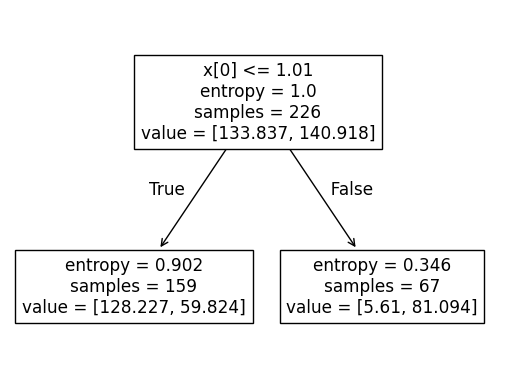

In [5]:
from tf_chpvk_pv.modeling.train import *
from pathlib import Path
from tf_chpvk_pv.config import DATA_DIR, RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'Ch_weights - tolerance factors accuracy for several operations.csv'

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

features_path = DATA_DIR / 'features_space/features/features/'


#df_acc_old = pd.read_csv(df_acc_old_path)
df_acc_old = pd.DataFrame()
#print(df_acc_old)

tfs = ['t', 'tau', 't_jess']
tf_tresh = [2, 1, 2]
df_acc =pd.DataFrame()
clfs = {}
t_sisso_expressions = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

for feat in files:
    #check that the tree file doesn't exist
    idx = int(feat.split('/')[-1].split('.csv')[0].split('_')[-1])

    col = 't_sisso_' + str(idx)
    
    re_do = False

    if col in df_acc_old.columns:
        no_nan_values = df_acc_old[col].isna().sum()
        if no_nan_values == 0:
            print('Tree with operations idx = %s already exists' % str(idx))
            continue
        else:
            print('Tree with operations idx = %s has %s missing values' % (str(idx), no_nan_values))
            re_do = True
    else:
        re_do = True

    if re_do:
        try:
            tf = 't_sisso_' + str(idx)
            df = pd.read_csv(features_path / feat)
            t_sisso_expression = train_tree_sis_features_Ch(features_path / feat)
            train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
            df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=1)
            clfs[tf] = clf_t
        except Exception as e:
            print(e)
            print('Error in %s' % feat)
            break

In [6]:
from tf_chpvk_pv.config import RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'Ch_weights - tolerance factors accuracy for several operations.csv'

if df_acc_old_path.exists():

    df_acc_old = pd.read_csv(df_acc_old_path)
    df_acc_old.set_index('Unnamed: 0', inplace=True)
    df_acc_old.index.name = None

    for col in df_acc.columns:
        if col not in df_acc_old.columns:
            
            df_acc_old[col] = df_acc[col]
        else:
            no_nan_values = df_acc_old[col].isna().sum()
            if no_nan_values > 0:
                df_acc_old[col] = df_acc[col]

    for col in df_acc_old.columns:
        if 'Unnamed' in col:
            df_acc_old.drop(col, axis=1, inplace=True)
    
    df_acc_old.to_csv(df_acc_old_path)

else:
    df_acc.to_csv(df_acc_old_path)

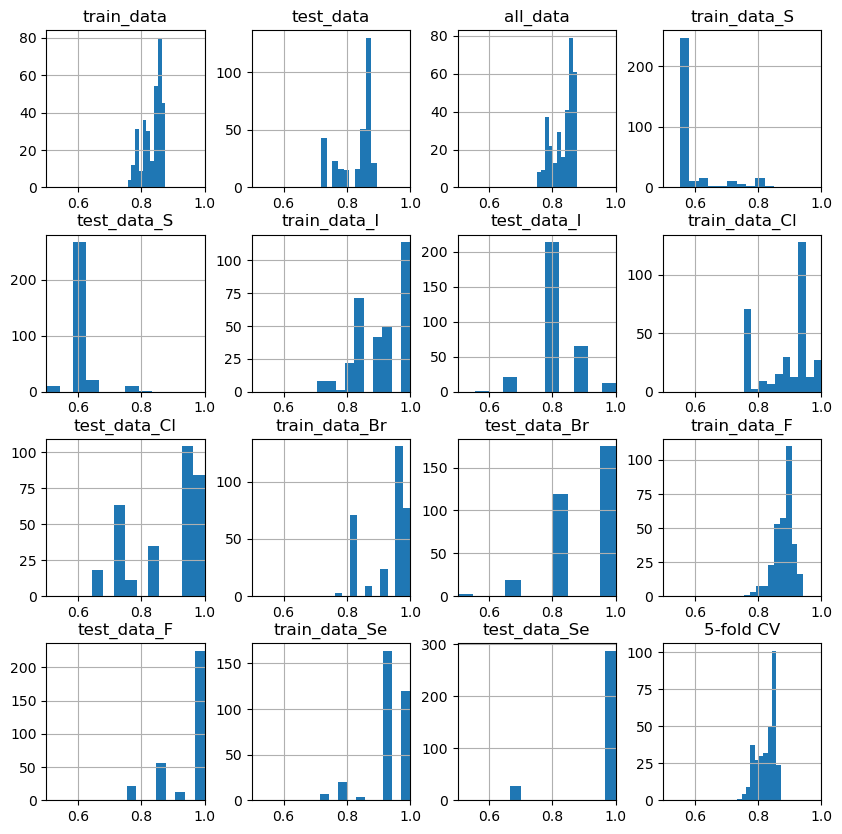

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from tf_chpvk_pv.config import RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'Ch_weights - tolerance factors accuracy for several operations.csv'

df = pd.read_csv(df_acc_old_path)
df.set_index('Unnamed: 0', inplace=True)


axs = df[[x for x in df.columns if 't_sisso' in x]].T.hist(figsize=(10, 10))
for ax in axs.flatten():
    ax.set_xlim(0.5, 1)
plt.show()

In [8]:
df[[x for x in df.columns if 't_sisso' in x]].max(axis=1)

Unnamed: 0
train_data       0.876106
test_data        0.894737
all_data         0.876325
train_data_S     0.851064
test_data_S      0.833333
train_data_I     1.000000
test_data_I      1.000000
train_data_Cl    1.000000
test_data_Cl     1.000000
train_data_Br    1.000000
test_data_Br     1.000000
train_data_F     0.943396
test_data_F      1.000000
train_data_Se    1.000000
test_data_Se     1.000000
5-fold CV        0.871401
dtype: float64

In [9]:
df.T.sort_values('test_data', ascending=False).head(5)

Unnamed: 0  train_data  test_data  all_data  train_data_S  test_data_S  \
t_sisso_44    0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_39    0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_63    0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_54    0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_49    0.853982   0.894737  0.862191      0.574468     0.583333   

Unnamed: 0  train_data_I  test_data_I  train_data_Cl  test_data_Cl  \
t_sisso_44      0.970588     1.000000       0.947368      1.000000   
t_sisso_39      0.941176     1.000000       0.929825      0.928571   
t_sisso_63      0.970588     0.888889       0.947368      1.000000   
t_sisso_54      0.970588     1.000000       0.947368      1.000000   
t_sisso_49      0.970588     1.000000       0.947368      1.000000   

Unnamed: 0  train_data_Br  test_data_Br  train_data_F  test_data_F  \
t_sisso_44       0.952381           1.0      0.867925     0.923077   
t_sisso_39       1.000000           1.0      0.905660     1.000000   
t_sisso_63       1.000000           1.0      0.849057     1.000000   
t_sisso_54       0.952381           1.0      0.867925     0.923077   
t_sisso_49       0.952381           1.0      0.867925     0.923077   

Unnamed: 0  train_data_Se  test_data_Se  5-fold CV  
t_sisso_44       0.928571           1.0   0.840580  
t_sisso_39       1.000000           1.0   0.862609  
t_sisso_63       0.928571           1.0   0.853720  
t_sisso_54       0.928571           1.0   0.840580  
t_sisso_49       0.928571           1.0   0.840580

In [10]:
df.T.sort_values('test_data_S', ascending=False).head(5)

Unnamed: 0   train_data  test_data  all_data  train_data_S  test_data_S  \
t_sisso_181    0.853982   0.877193  0.858657      0.680851     0.833333   
t_sisso_178    0.823009   0.824561  0.823322      0.744681     0.750000   
t_sisso_175    0.840708   0.842105  0.840989      0.744681     0.750000   
t_sisso_226    0.814159   0.859649  0.823322      0.702128     0.750000   
t_sisso_18     0.823009   0.824561  0.823322      0.744681     0.750000   

Unnamed: 0   train_data_I  test_data_I  train_data_Cl  test_data_Cl  \
t_sisso_181      0.764706     0.666667       0.947368      0.857143   
t_sisso_178      0.705882     0.666667       0.842105      0.785714   
t_sisso_175      0.705882     0.666667       0.859649      0.857143   
t_sisso_226      0.735294     0.888889       0.894737      0.785714   
t_sisso_18       0.705882     0.666667       0.842105      0.785714   

Unnamed: 0   train_data_Br  test_data_Br  train_data_F  test_data_F  \
t_sisso_181       1.000000      1.000000      0.867925          1.0   
t_sisso_178       0.857143      0.833333      0.886792          1.0   
t_sisso_175       1.000000      0.833333      0.886792          1.0   
t_sisso_226       0.761905      0.833333      0.886792          1.0   
t_sisso_18        0.857143      0.833333      0.886792          1.0   

Unnamed: 0   train_data_Se  test_data_Se  5-fold CV  
t_sisso_181       1.000000           1.0   0.840386  
t_sisso_178       1.000000           1.0   0.814010  
t_sisso_175       1.000000           1.0   0.827246  
t_sisso_226       0.857143           1.0   0.804928  
t_sisso_18        1.000000           1.0   0.814010

In [11]:
df.T[df.T['test_data'] >= 0.89]

Unnamed: 0   train_data  test_data  all_data  train_data_S  test_data_S  \
t_sisso_214    0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_43     0.858407   0.894737  0.865724      0.574468     0.583333   
t_sisso_216    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_51     0.858407   0.894737  0.865724      0.574468     0.583333   
t_sisso_223    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_164    0.840708   0.894737  0.851590      0.553191     0.583333   
t_sisso_49     0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_56     0.858407   0.894737  0.865724      0.574468     0.583333   
t_sisso_41     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_62     0.858407   0.894737  0.865724      0.574468     0.583333   
t_sisso_125    0.858407   0.894737  0.865724      0.574468     0.583333   
t_sisso_37     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_38     0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_40     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_210    0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_55     0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_212    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_54     0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_63     0.853982   0.894737  0.862191      0.574468     0.583333   
t_sisso_39     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_44     0.853982   0.894737  0.862191      0.574468     0.583333   

Unnamed: 0   train_data_I  test_data_I  train_data_Cl  test_data_Cl  \
t_sisso_214      1.000000     0.888889       0.929825      1.000000   
t_sisso_43       1.000000     0.888889       0.929825      1.000000   
t_sisso_216      0.941176     0.888889       0.894737      1.000000   
t_sisso_51       1.000000     0.888889       0.964912      1.000000   
t_sisso_223      0.941176     0.888889       0.894737      1.000000   
t_sisso_164      0.852941     0.888889       0.982456      1.000000   
t_sisso_49       0.970588     1.000000       0.947368      1.000000   
t_sisso_56       0.970588     0.888889       0.947368      1.000000   
t_sisso_41       0.941176     1.000000       0.929825      0.928571   
t_sisso_62       1.000000     0.888889       0.964912      1.000000   
t_sisso_125      0.970588     0.888889       0.947368      1.000000   
t_sisso_37       0.941176     1.000000       0.929825      0.928571   
t_sisso_38       0.970588     1.000000       0.947368      1.000000   
t_sisso_40       0.941176     1.000000       0.929825      0.928571   
t_sisso_210      1.000000     0.888889       0.929825      1.000000   
t_sisso_55       0.970588     1.000000       0.947368      1.000000   
t_sisso_212      0.941176     0.888889       0.894737      1.000000   
t_sisso_54       0.970588     1.000000       0.947368      1.000000   
t_sisso_63       0.970588     0.888889       0.947368      1.000000   
t_sisso_39       0.941176     1.000000       0.929825      0.928571   
t_sisso_44       0.970588     1.000000       0.947368      1.000000   

Unnamed: 0   train_data_Br  test_data_Br  train_data_F  test_data_F  \
t_sisso_214       0.952381           1.0      0.867925     1.000000   
t_sisso_43        0.952381           1.0      0.886792     1.000000   
t_sisso_216       1.000000           1.0      0.886792     1.000000   
t_sisso_51        0.952381           1.0      0.849057     1.000000   
t_sisso_223       1.000000           1.0      0.886792     1.000000   
t_sisso_164       0.952381           1.0      0.867925     1.000000   
t_sisso_49        0.952381           1.0      0.867925     0.923077   
t_sisso_56        1.000000           1.0      0.867925     1.000000   
t_sisso_41        1.000000           1.0      0.905660     1.000000   
t_sisso_62        0.952381           1.0      0.849057     1.000000   
t_sis

In [12]:
top_t_sisso = df.T[df.T['test_data'] >= 0.89].index.values

{}
Classification tree accuracy (for t) on the train set: 0.637168.
Classification tree accuracy (for t) on the train set (5 fold CV): 0.606280.
Classification tree accuracy (for t) on the test set: 0.596491.
0.830243 < t < 0.868341 indicates stable perovskites.
2025-03-26 17:48:46.205 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio * chi_BX_ratio) - (|chi_BX_ratio - log_rA_rB_ratio|)|) - exp((|rB_rX_ratio - log_rA_rB_ratio|))|)
Classification tree accuracy (for t_sisso_214) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_214) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_214) on the test set: 0.894737.
t_sisso_214 < 0.680196 indicates stable perovskites.
2025-03-26 17:49:08.698 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified express

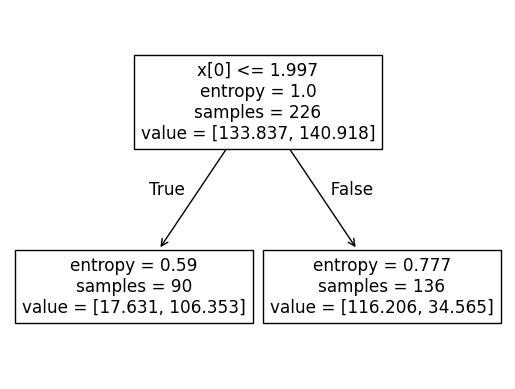

In [14]:
from tf_chpvk_pv.config import DATA_DIR, INTERIM_DATA_DIR
from tf_chpvk_pv.modeling.train import test_tolerance_factor, evaluate_t_sisso, train_tree_sis_features
import pickle

features_path = DATA_DIR / 'features_space/features/features/'

tfs = ['t', 'tau', 't_jess'] + top_t_sisso.tolist() + ['t_sisso_181']
tf_tresh = [2, 1, 2] + [1]*( top_t_sisso.shape[0] + 1)
df_acc =pd.DataFrame()
clfs = {}

tolerance_factor_path = INTERIM_DATA_DIR / 'ch_tolerance_factors_ops.pkl'

if tolerance_factor_path.exists():
    with open(tolerance_factor_path, 'rb') as file:
        tolerance_factor_dict_global = pickle.load(file)
else:
    tolerance_factor_dict_global = {}

print(tolerance_factor_dict_global)

train_df_global = train_df.copy()
test_df_global = test_df.copy()

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

for tf, tresh in zip(tfs, tf_tresh):
    if tf not in tolerance_factor_dict_global.keys():
        if 'sisso' in tf:
            idx = int(tf.split('_')[-1])
            t_sisso_expression = train_tree_sis_features_Ch(features_path / ('features_sisso_' + str(idx) + '.csv'))
            train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
        df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
        for key in tolerance_factor_dict.keys():
            if key not in tolerance_factor_dict_global.keys():
                tolerance_factor_dict_global[key] = tolerance_factor_dict[key]
        for col in train_df.columns:
            if col not in train_df_global.columns:
                train_df_global[col] = train_df[col]
            if col not in test_df_global.columns:
                test_df_global[col] = test_df[col]
        clfs[tf] = clf_t


with open(tolerance_factor_path, 'wb') as file:
    pickle.dump(tolerance_factor_dict_global, file)

train_df = train_df_global
test_df = test_df_global

In [23]:
for t in tolerance_factor_dict_global.keys():
    try:
        th = tolerance_factor_dict_global[t][1]
        exp = tolerance_factor_dict_global[t][0]
        print(t, exp, th)
    except:
        continue

t (rA+rX)/(1.41421*(rB+rX)) [np.float64(0.8302426636219025), np.float64(0.868341326713562)]
tau rX/rB-nA*(nA-rA_rB_ratio/log(rA_rB_ratio)) 4.18
t_sisso_214 abs(abs((rA_rX_ratio * chi_BX_ratio) - abs(chi_BX_ratio - log_rA_rB_ratio)) - exp(abs(rB_rX_ratio - log_rA_rB_ratio))) 0.6801959872245789
t_sisso_43 abs((abs(rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio + rB_rX_ratio)) - abs(abs(rB_rX_ratio - log_rA_rB_ratio) - rA_rX_ratio)) 0.5186955034732819
t_sisso_216 abs(abs((rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))) 0.24793849140405655
t_sisso_51 (abs(abs(rA_rX_ratio - log_rA_rB_ratio) - exp(rB_rX_ratio)) + abs(abs(rB_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio + log_rA_rB_ratio))) 2.258196234703064
t_sisso_223 abs(abs((rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))) 0.24793849140405655
t_sisso_164 (sqrt((rA_rX_ratio * rB_rX_ratio)) - ((rB_rX_ratio - log_rA_rB_rat

In [42]:
test_idx = [x for x in df.index if 'test' in x]
tfs_ = ['t', 'tau', 't_jess'] + ['t_sisso_214']
display(df.loc[test_idx, tfs_])

t       tau    t_jess  t_sisso_214
Unnamed: 0                                             
test_data     0.596491  0.824561  0.631579     0.894737
test_data_S   0.500000  0.500000  0.583333     0.583333
test_data_I   0.222222  0.777778  0.777778     0.888889
test_data_Cl  0.642857  0.928571  0.500000     1.000000
test_data_Br  0.500000  0.833333  0.500000     1.000000
test_data_F   1.000000  1.000000  0.769231     1.000000
test_data_Se  0.333333  1.000000  0.666667     1.000000

In [21]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions
from tf_chpvk_pv.config import INTERIM_DATA_DIR

new_tolerance_dict_path = INTERIM_DATA_DIR / 'ch_tolerance_factors_ops.pkl'

element_selection_A = ["Ba", "Eu", "Pb", "Sr", "Ca", "Sn", "Cd", "Cu", "Mg",
                      "Zn", "Ge", "La", "Pr", "Ce", "Nd", "Yb", "Gd", "Sm", "Y",
                      "Dy", "Ho", "Er", "Tm", "Lu", "Sc", "Tl", "Bi"]

elements_selection_B = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb", "Hf",
                        "Zr", "Tb", "Pt", "Ce", "U", "Pd", "Ni", "Co", "Ga", "Al",
                        "Fe", "Cr", "In", "Mn", "Sc", "Lu", "Tm", "Er", "Ho", "Y",
                        "Yb"]


elements_selection = element_selection_A + elements_selection_B

possible_oxidation_states = [2.0, 3.0, 4.0] #3, 4] #for A and B elements

df_generated_comp = generate_compositions(elements_selection, 
                                          possible_oxidation_states, 
                                          dict_tol_factors_path=new_tolerance_dict_path).dropna()

2025-03-26 17:59:20.006 | INFO     | tf_chpvk_pv.dataset:generate_compositions:247 - Generating valid compositions...
Invalid composition: CuBiS3
Invalid composition: CuBiSe3
Invalid composition: VCuS3
Invalid composition: VCuSe3
Invalid composition: CuRuS3
Invalid composition: CuRuSe3
Invalid composition: CuMoS3
Invalid composition: CuMoSe3
Invalid composition: TaCuS3
Invalid composition: TaCuSe3
Invalid composition: NbCuS3
Invalid composition: NbCuSe3
Invalid composition: CrCuS3
Invalid composition: CrCuSe3
Invalid composition: TlVS3
Invalid composition: TlVSe3
Invalid composition: TlRuS3
Invalid composition: TlRuSe3
Invalid composition: TlMoS3
Invalid composition: TlMoSe3
Invalid composition: TaTlS3
Invalid composition: TaTlSe3
Invalid composition: NbTlS3
Invalid composition: NbTlSe3
Invalid composition: UTlS3
Invalid composition: UTlSe3
Invalid composition: TlCrS3
Invalid composition: TlCrSe3
Invalid composition: TaNiS3
Invalid composition: TaNiSe3
Invalid composition: TaCoS3
Inval

/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


According to tau, 385 (33.07560137457045%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPrS3', 'BaCeS3', 'BaHfS3', 'BaZrS3', 'BaTbS3', 'BaUS3', 'EuCuS3', 'EuCuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuNiS3', 'EuNiSe3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuAlS3', 'EuAlSe3', 'EuFeS3', 'EuFeSe3', 'EuCrS3', 'EuCrSe3', 'EuInS3', 'EuMnS3', 'EuMnSe3', 'CuLaS3', 'CuLaSe3', 'CuGaS3', 'CuAlS3', 'CuAlSe3', 'MgUS3', 'MgUSe3', 'LaYbS3', 'LaYbSe3', 'LaYS3', 'LaYSe3', 'LaHoS3', 'LaHoSe3', 'LaErS3', 'LaErSe3', 'LaTmS3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaScS3', 'LaScSe3', 'LaTlS3', 'LaTlSe3', 'LaVS3', 'LaVSe3', 'LaRhS3', 'LaRhSe3', 'LaTiS3', 'LaTiSe3', 'LaRuS3', 'LaRuSe3', 'LaMoS3', 'LaMoSe3', 'LaTaS3', 'LaTaSe3', 'LaNbS3', 'LaNbSe3', 'LaHfS3', 'LaNiS3', 'LaNiSe3', 'LaCoS3', 'LaCoSe3', 'LaGaS3', 'LaGaSe3', 'LaAlS3', 'LaAlSe3', 'LaFeS3', 'LaFeSe3', 'LaCrS3', 'LaCrSe3', 'LaInS3', 'LaInSe3', 'LaMnS3', 'LaMnSe3', 'PrLuS3', 'PrScS3', 'PrScSe3',

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


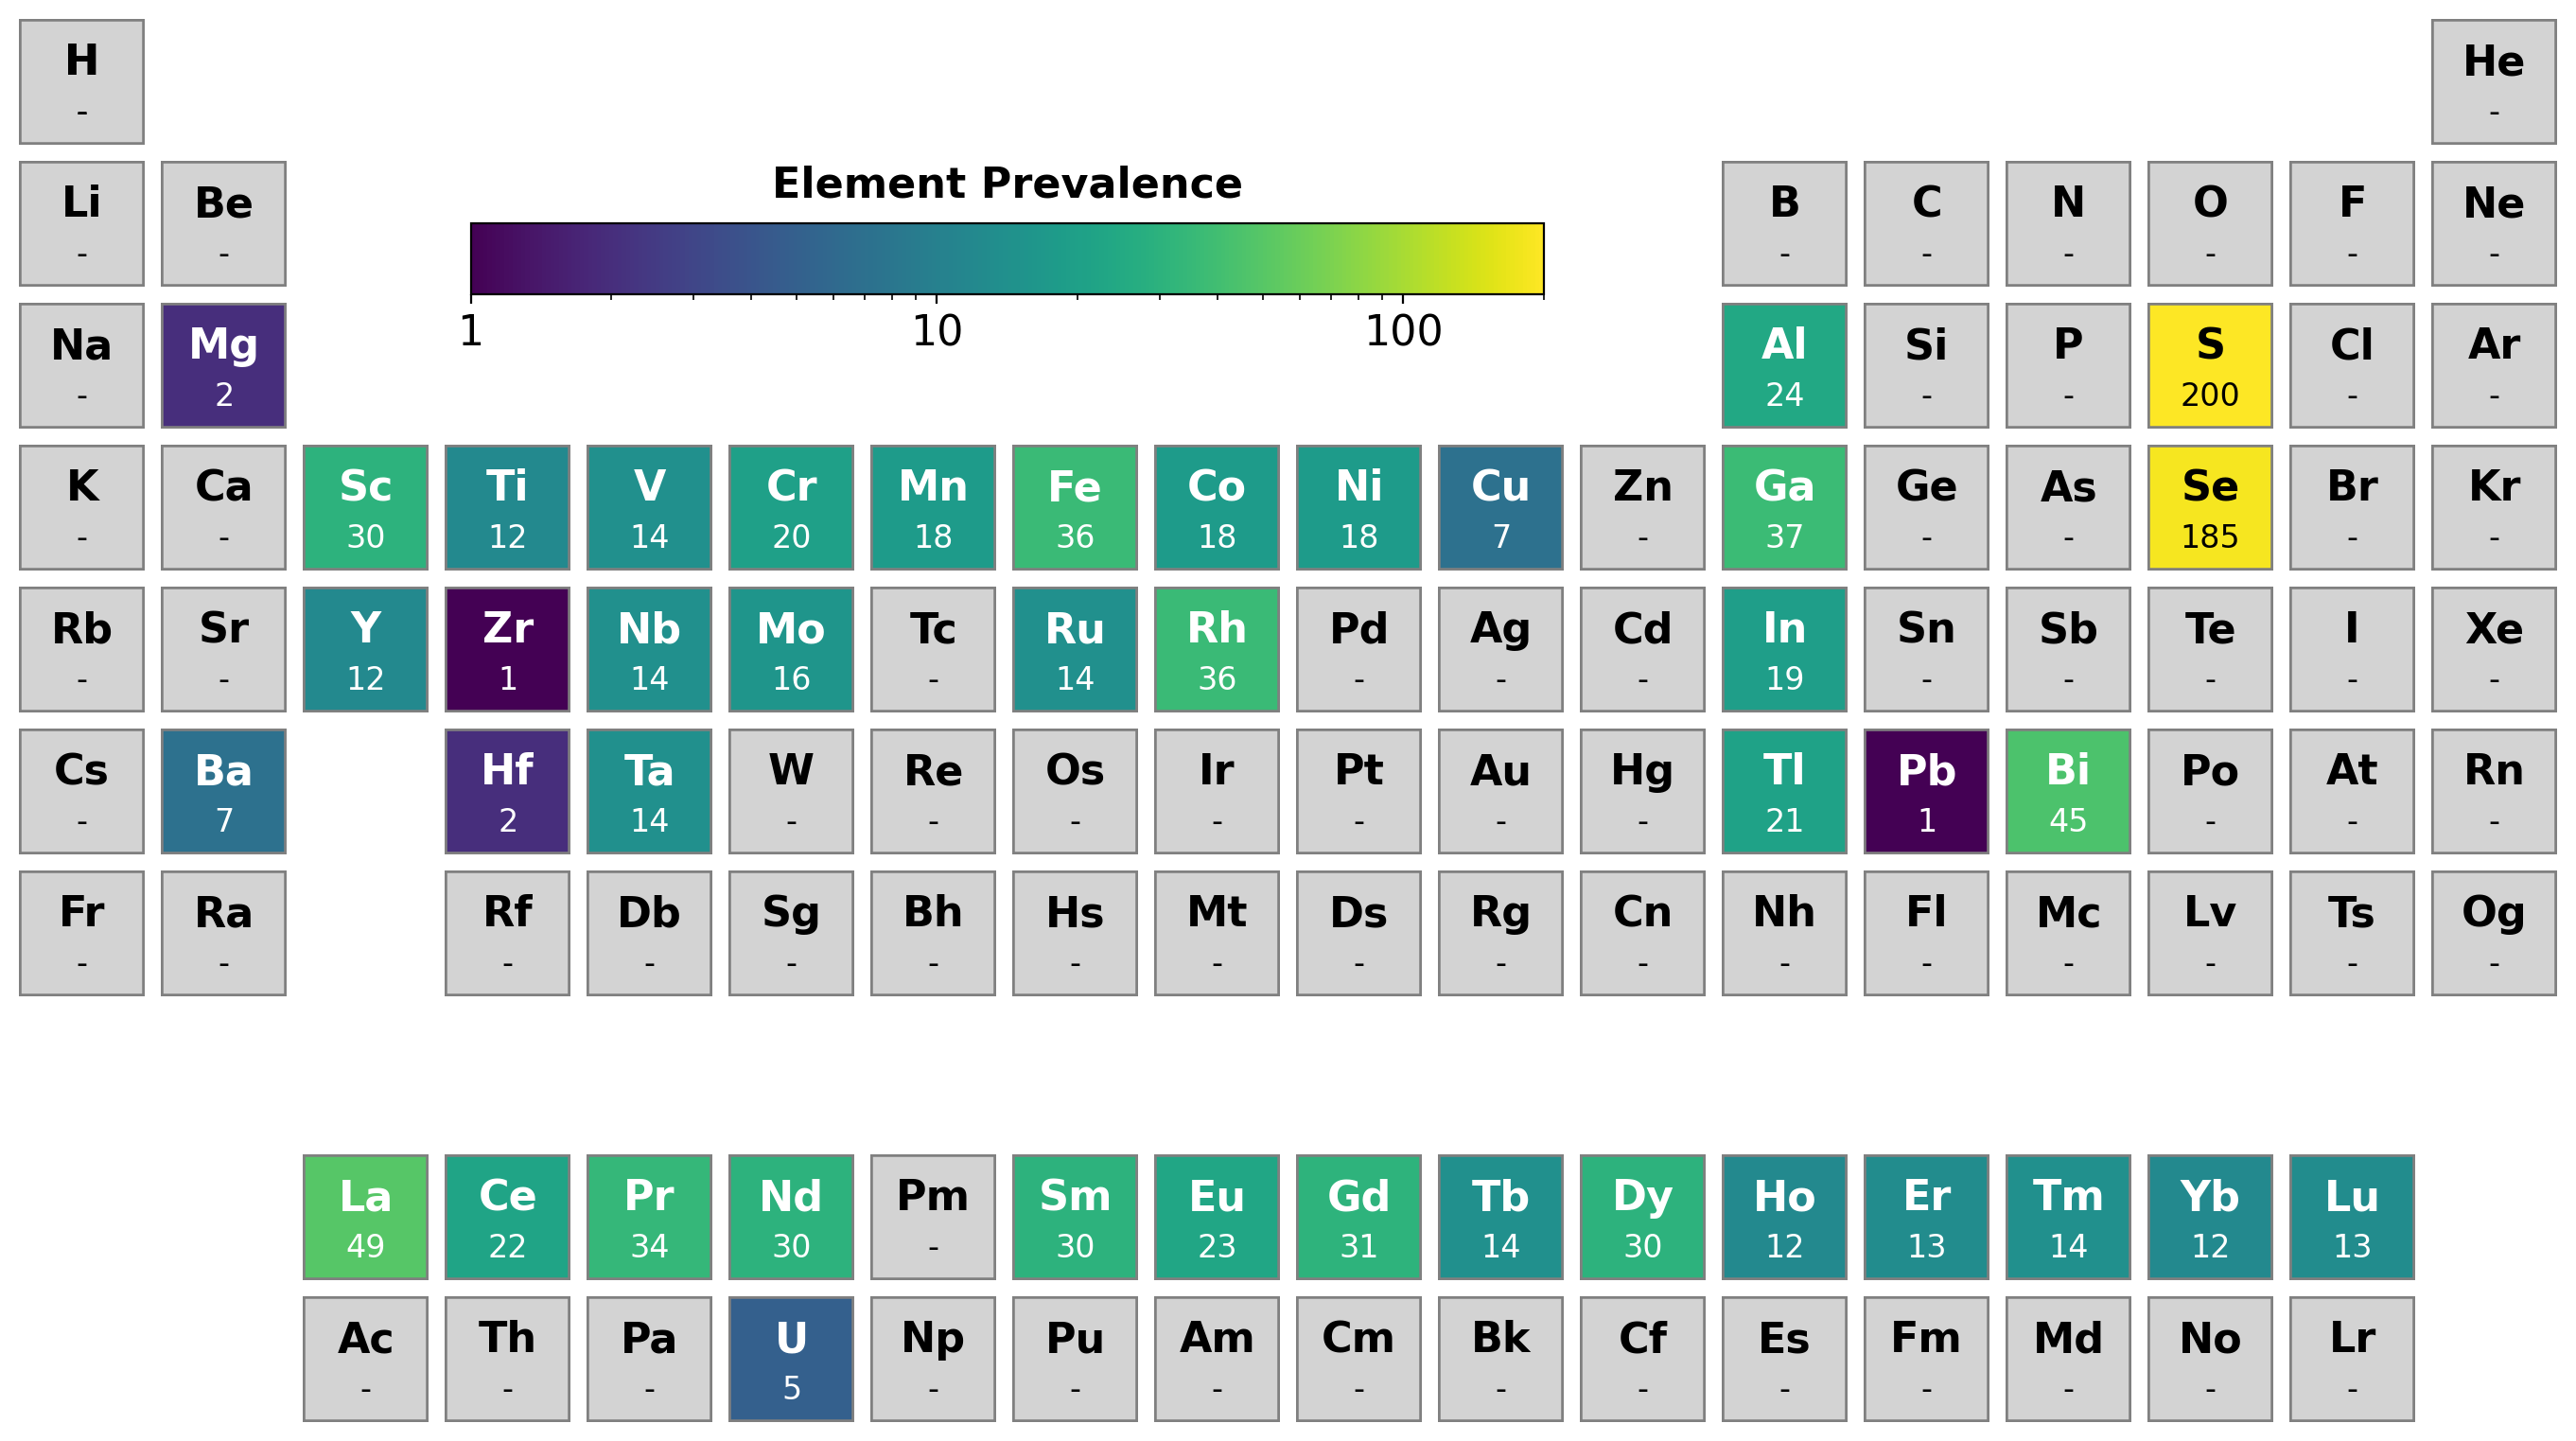

According to t_sisso_214, 10 (0.859106529209622%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


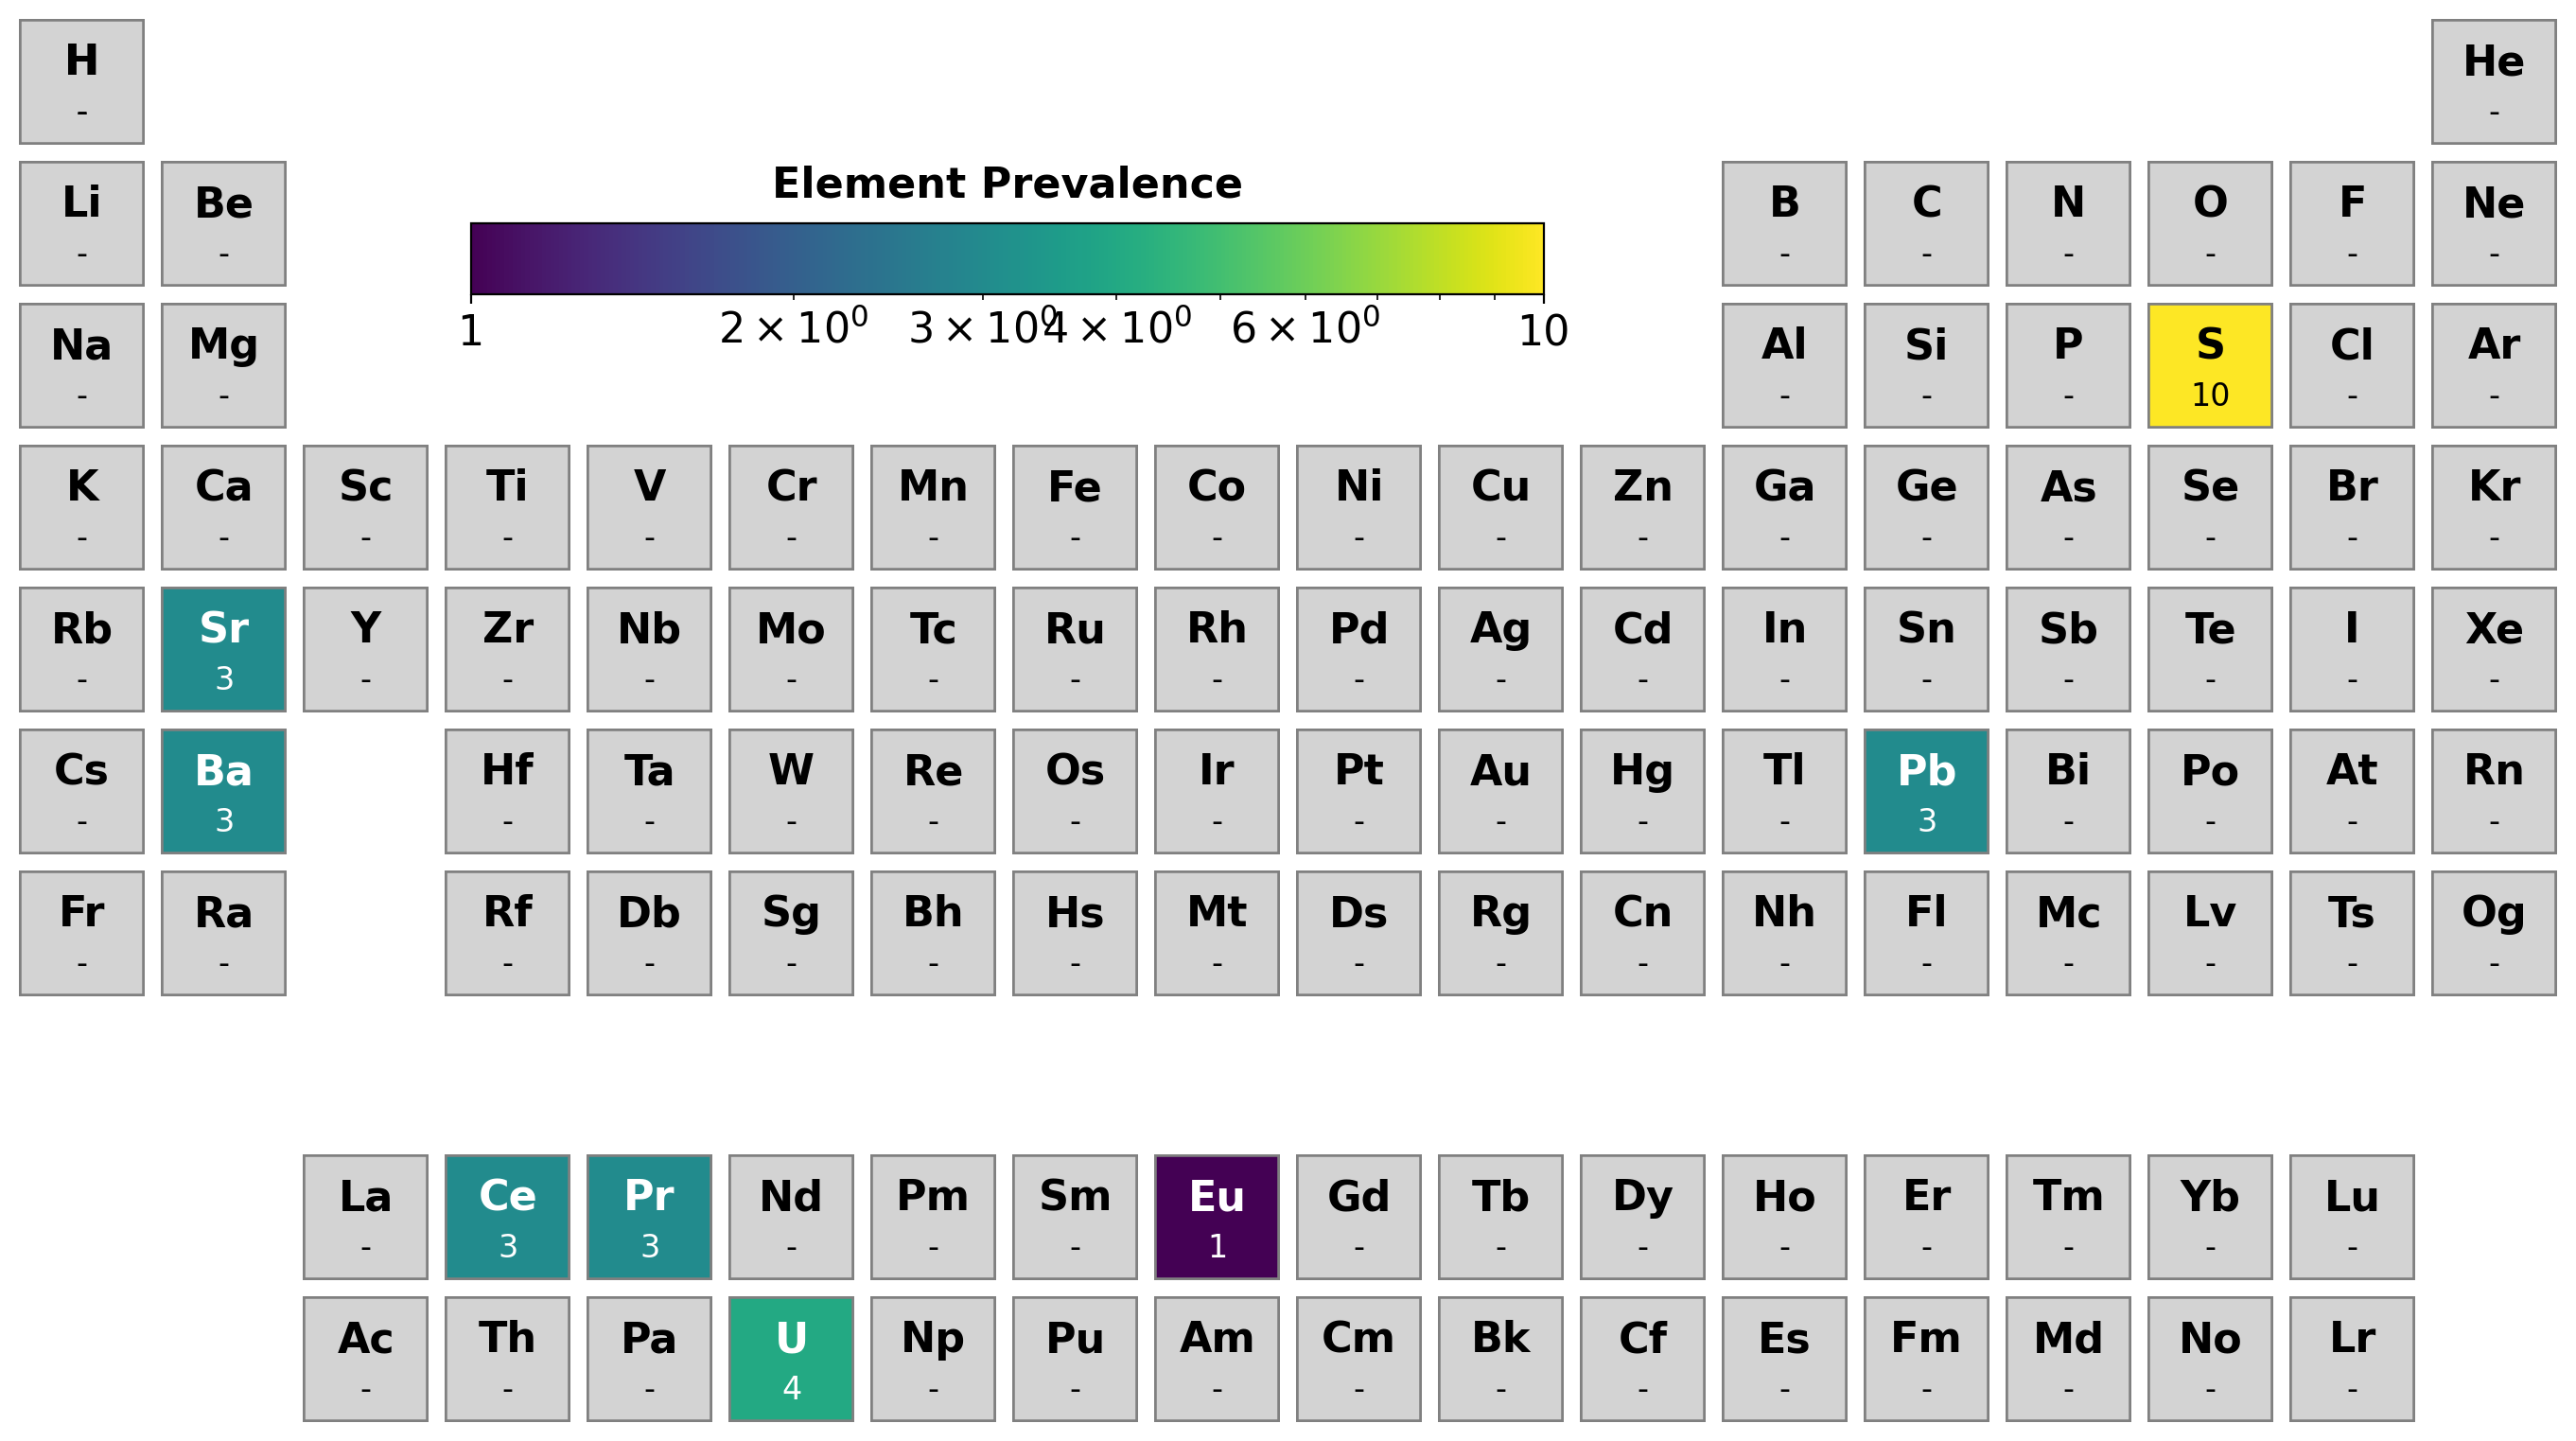

According to t_sisso_43, 1156 (99.3127147766323%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuV

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


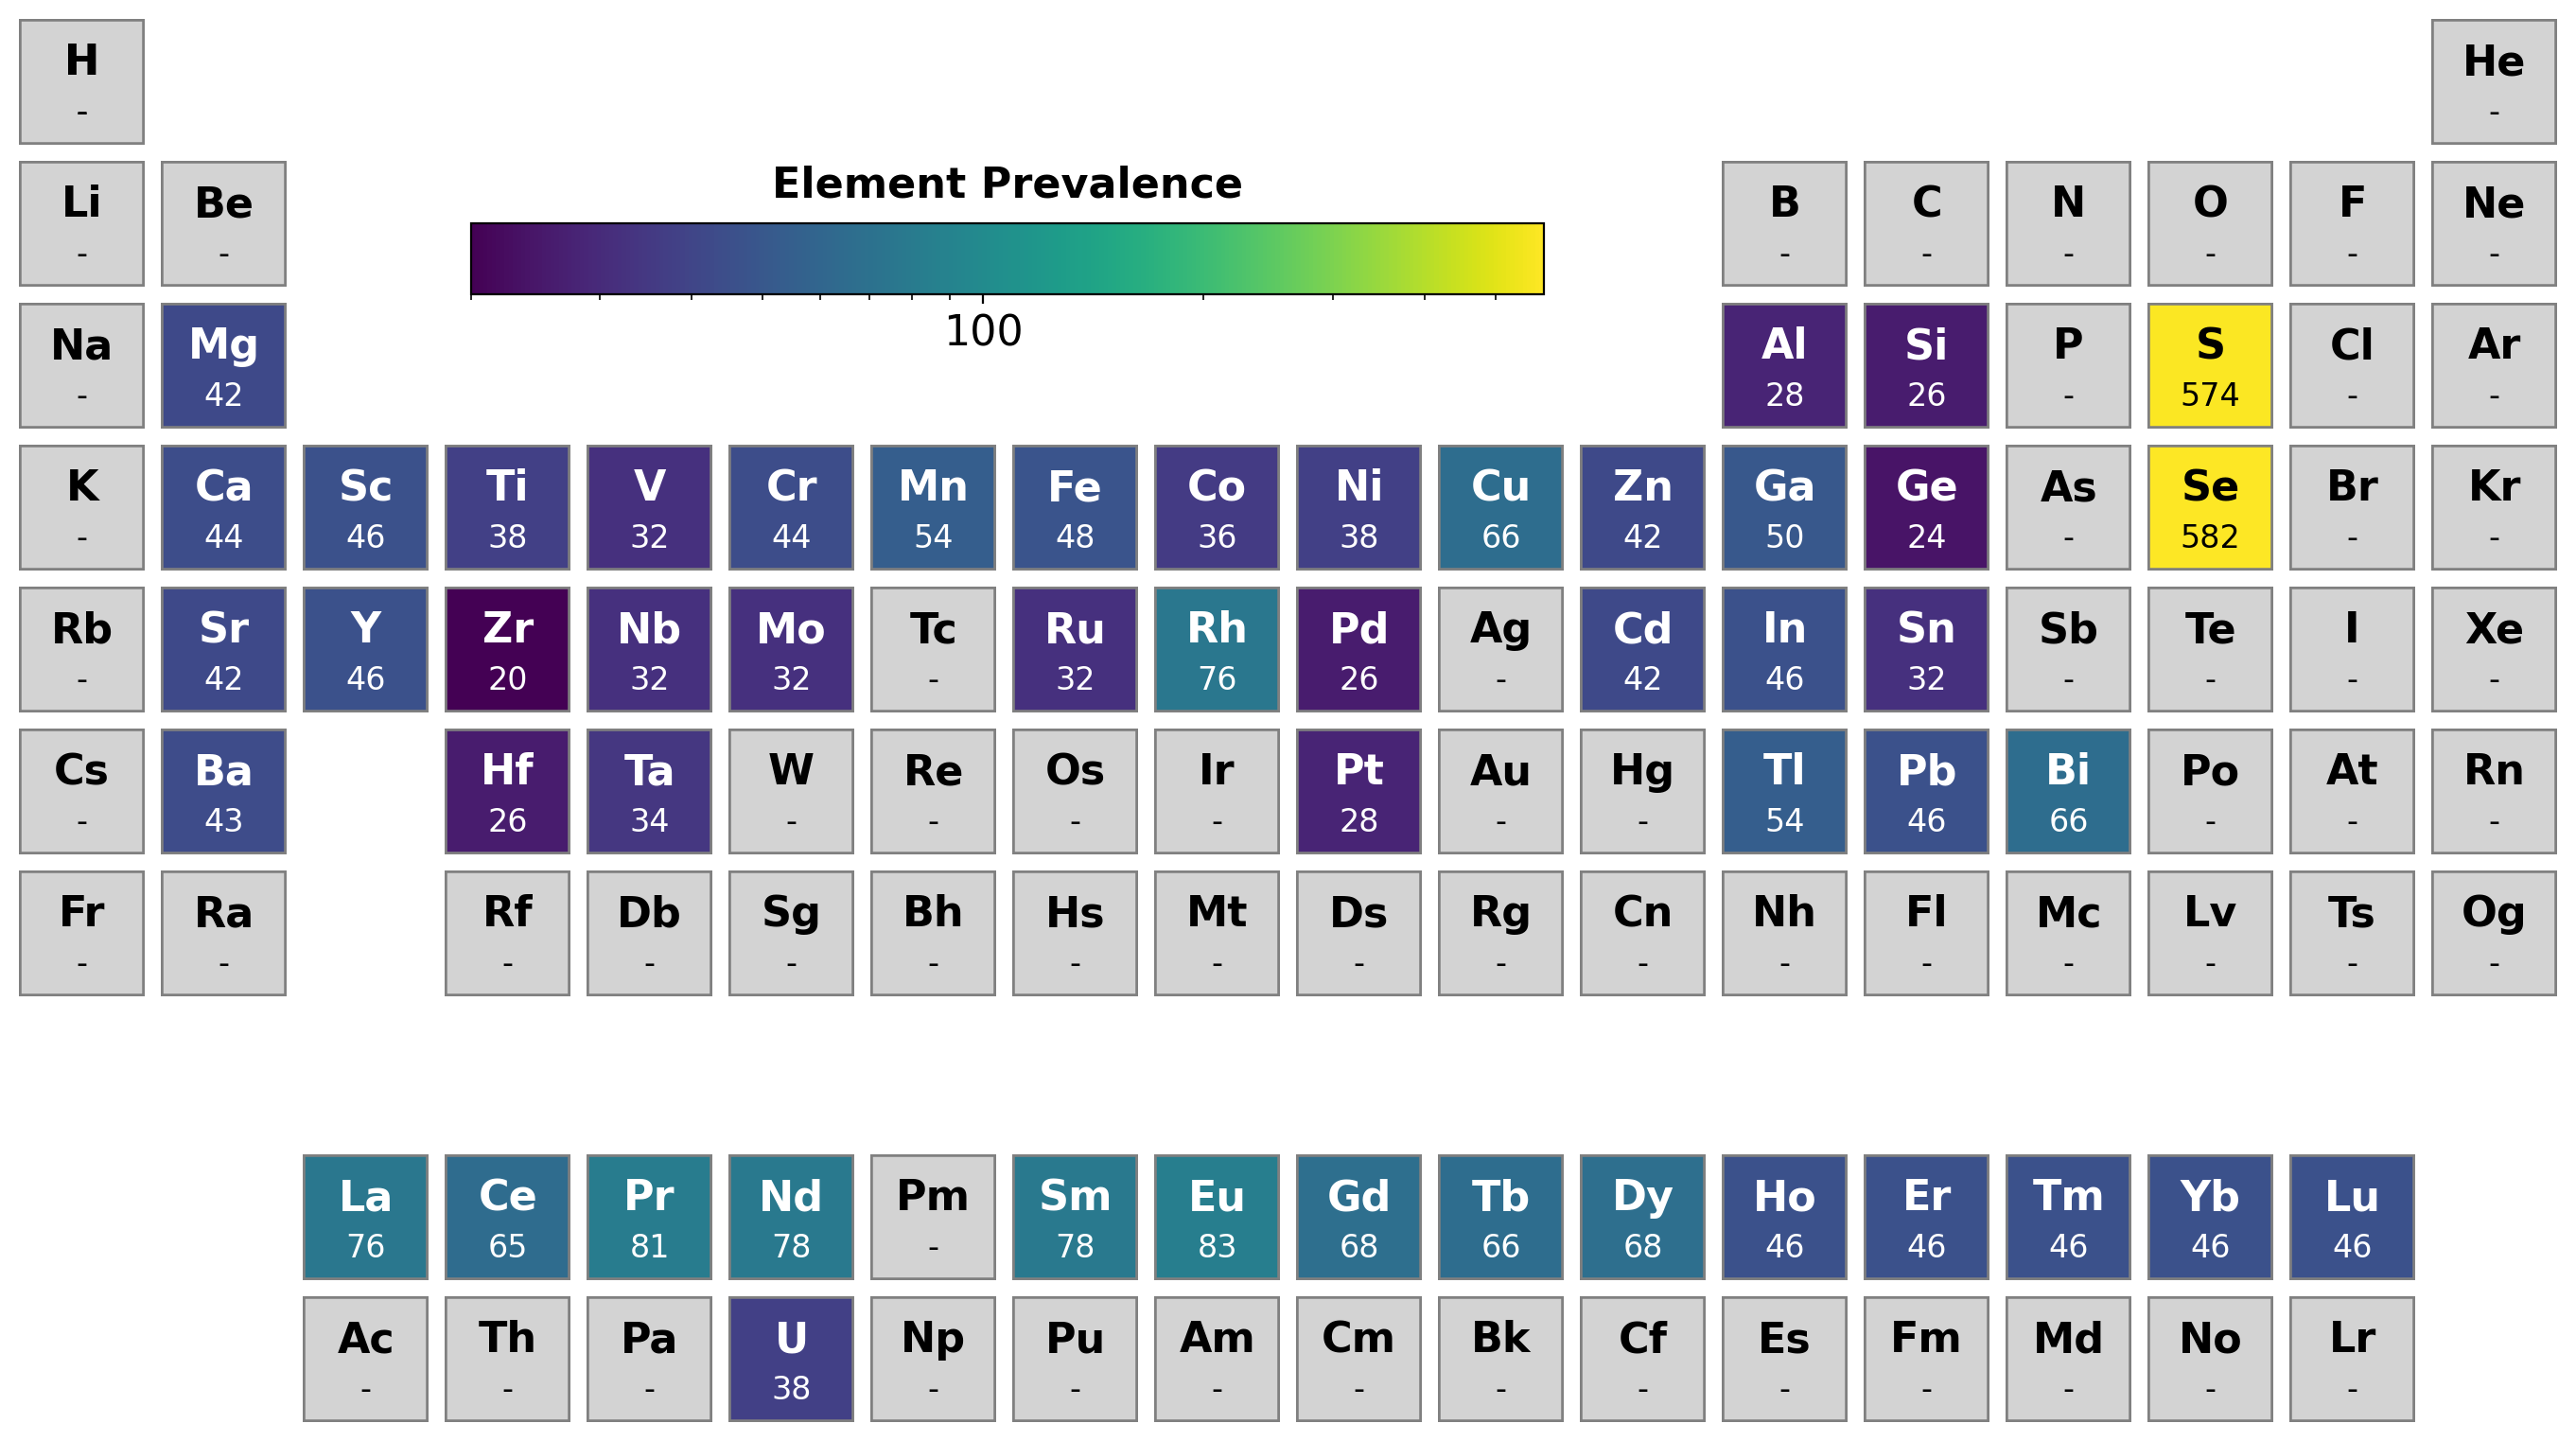

According to t_sisso_216, 1112 (95.53264604810997%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrSe3', 'BaCeSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZ

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


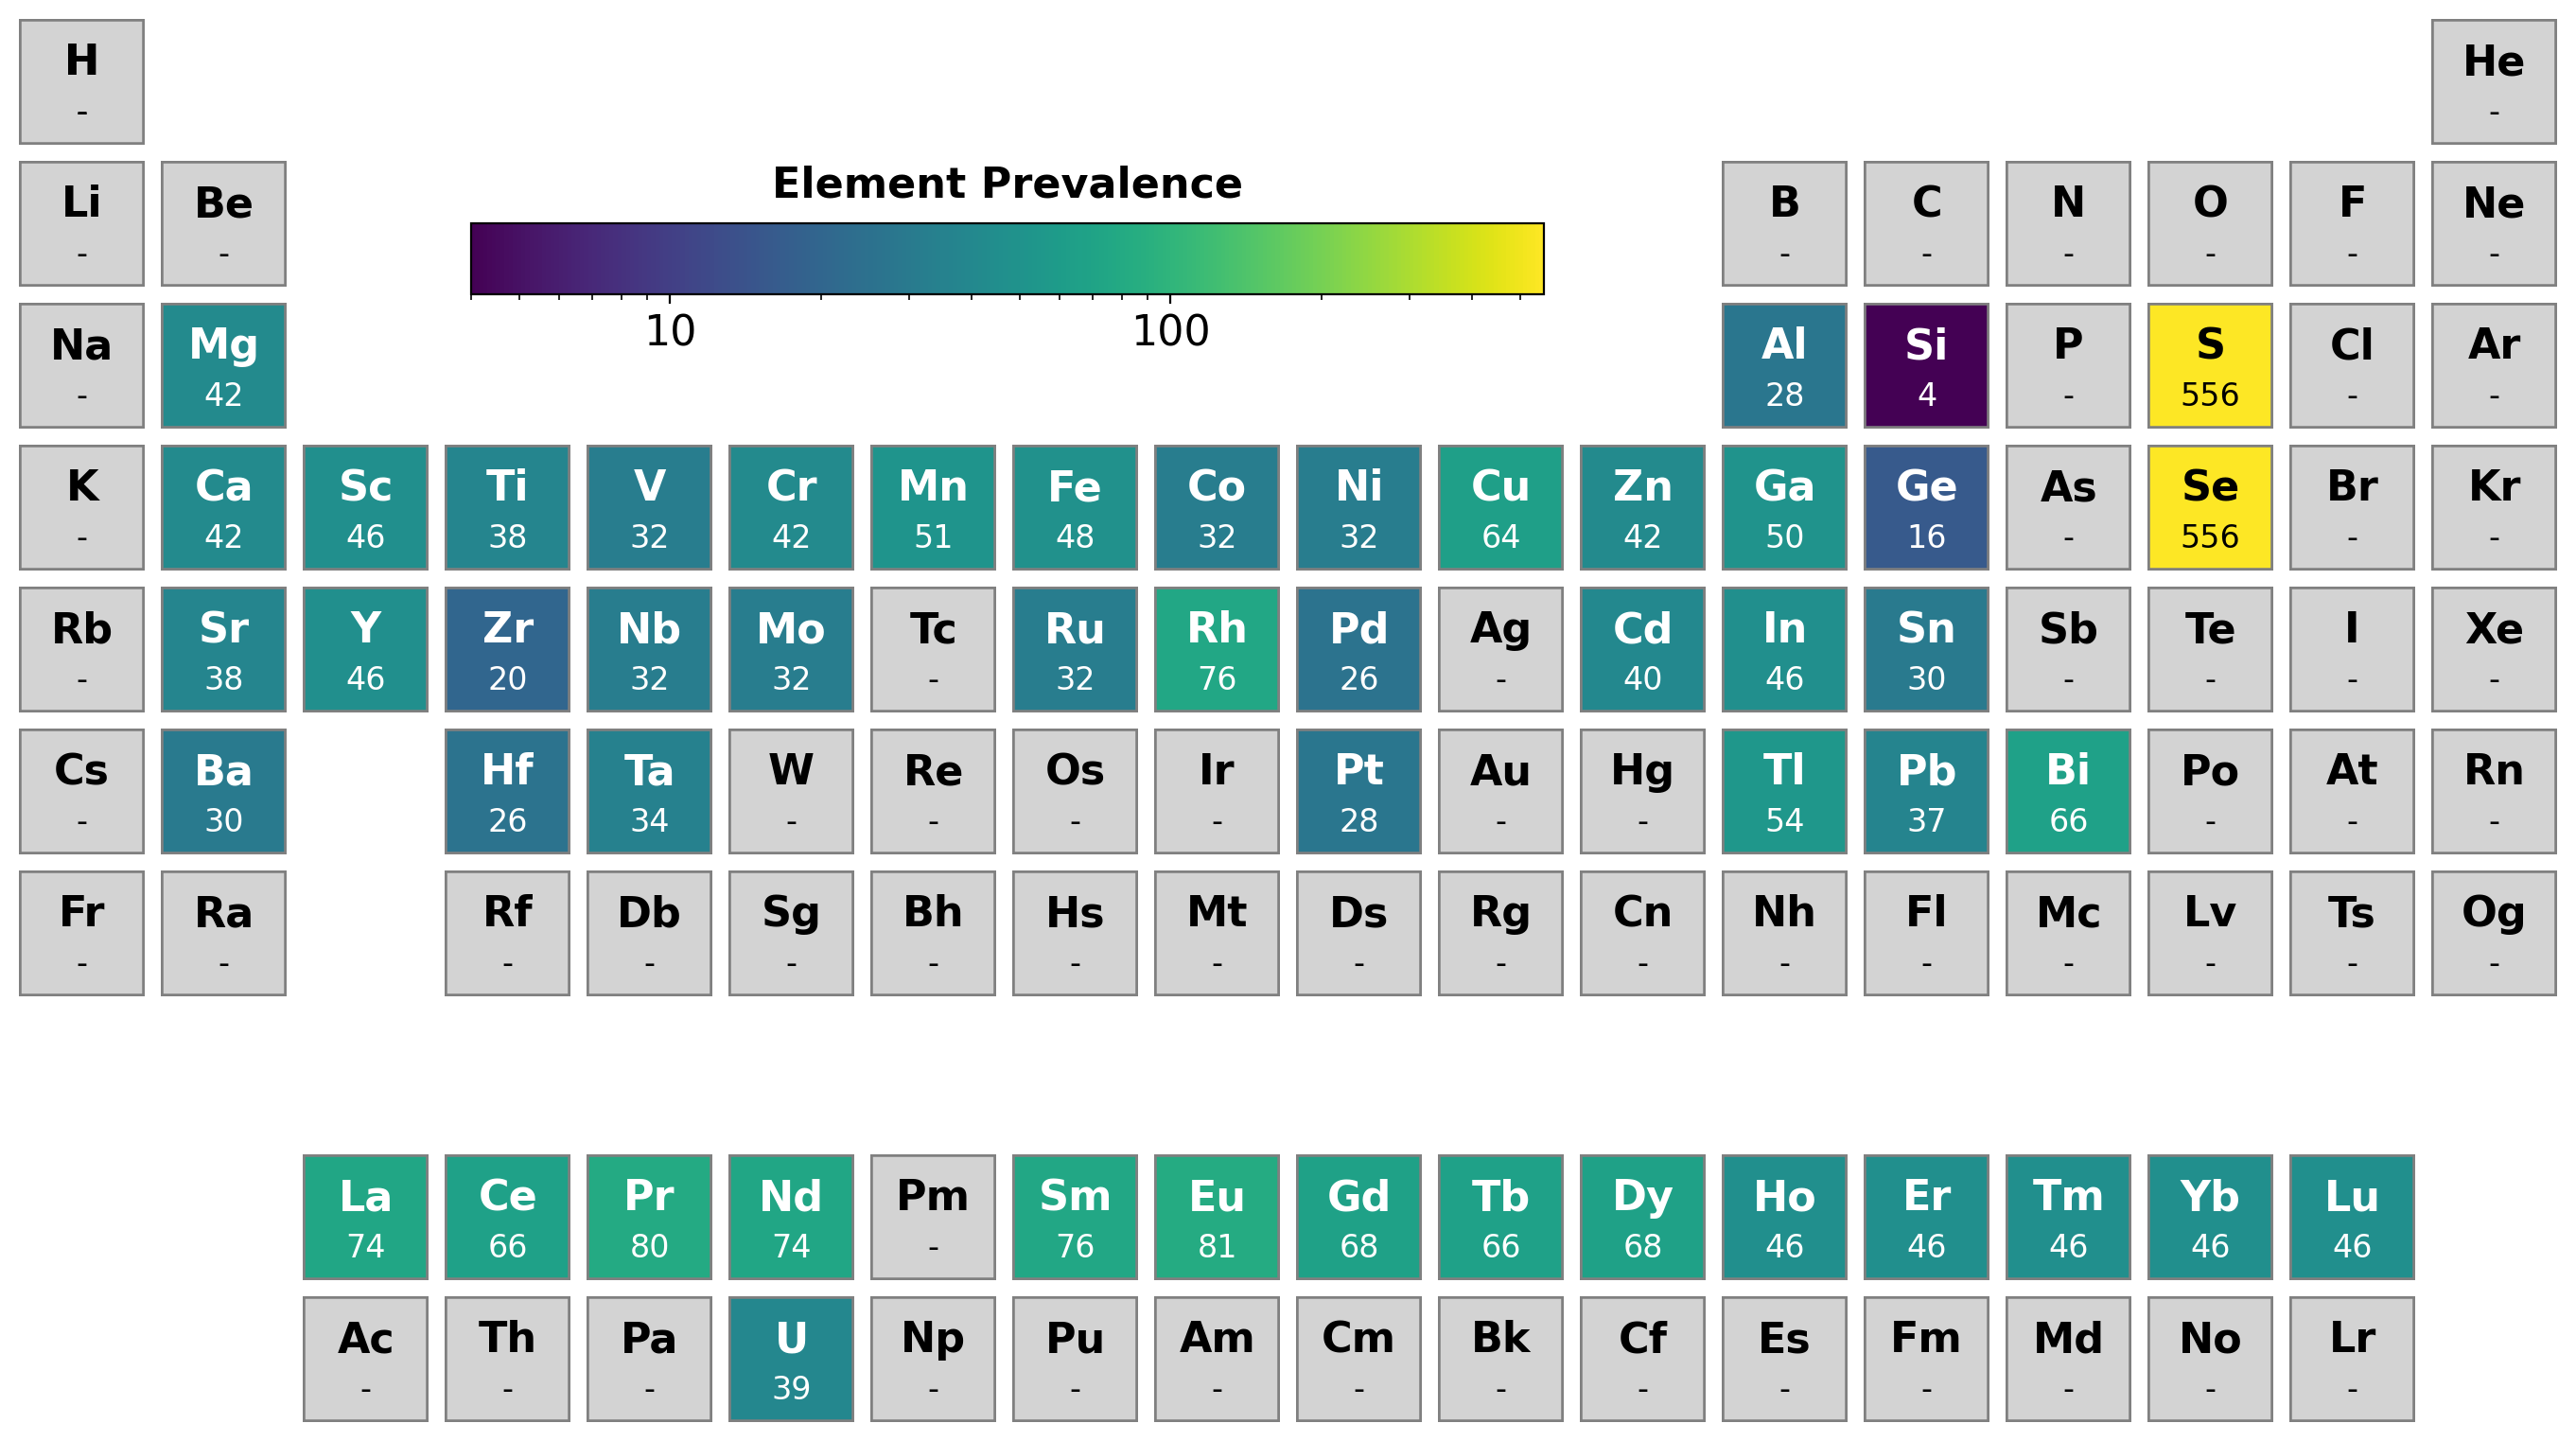

According to t_sisso_51, 1155 (99.22680412371135%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'Eu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


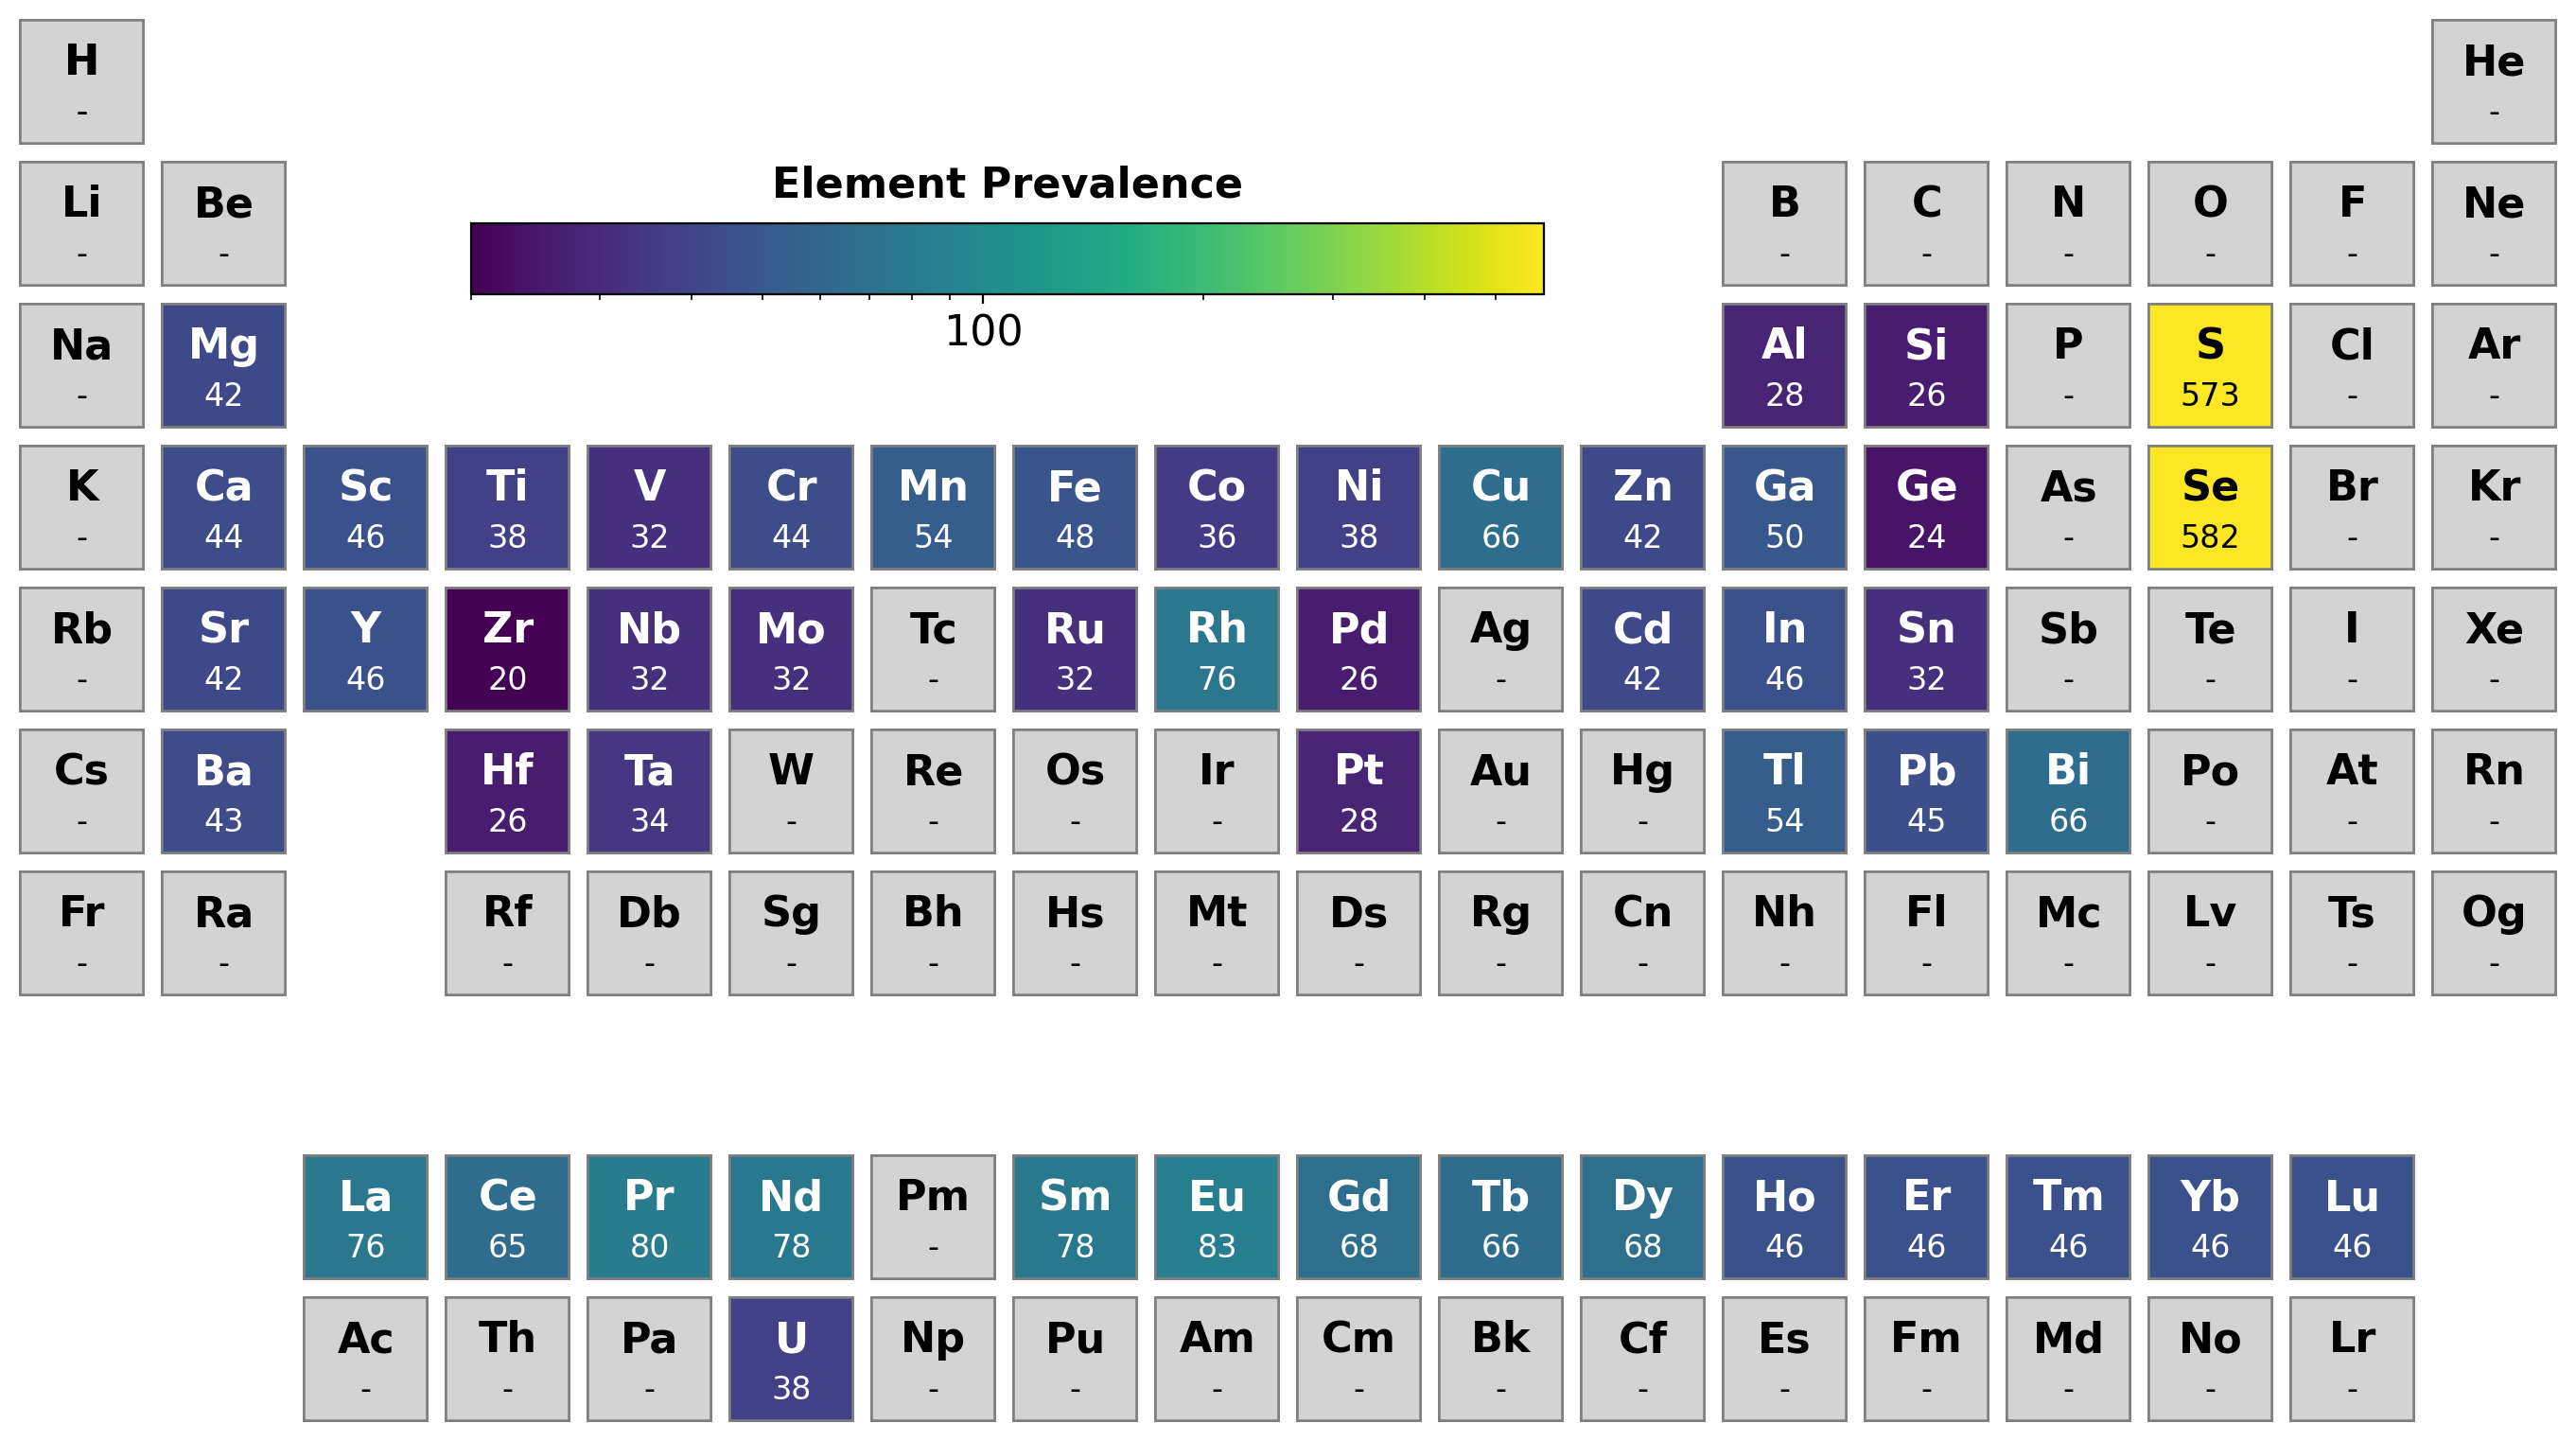

According to t_sisso_223, 1112 (95.53264604810997%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrSe3', 'BaCeSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZ

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


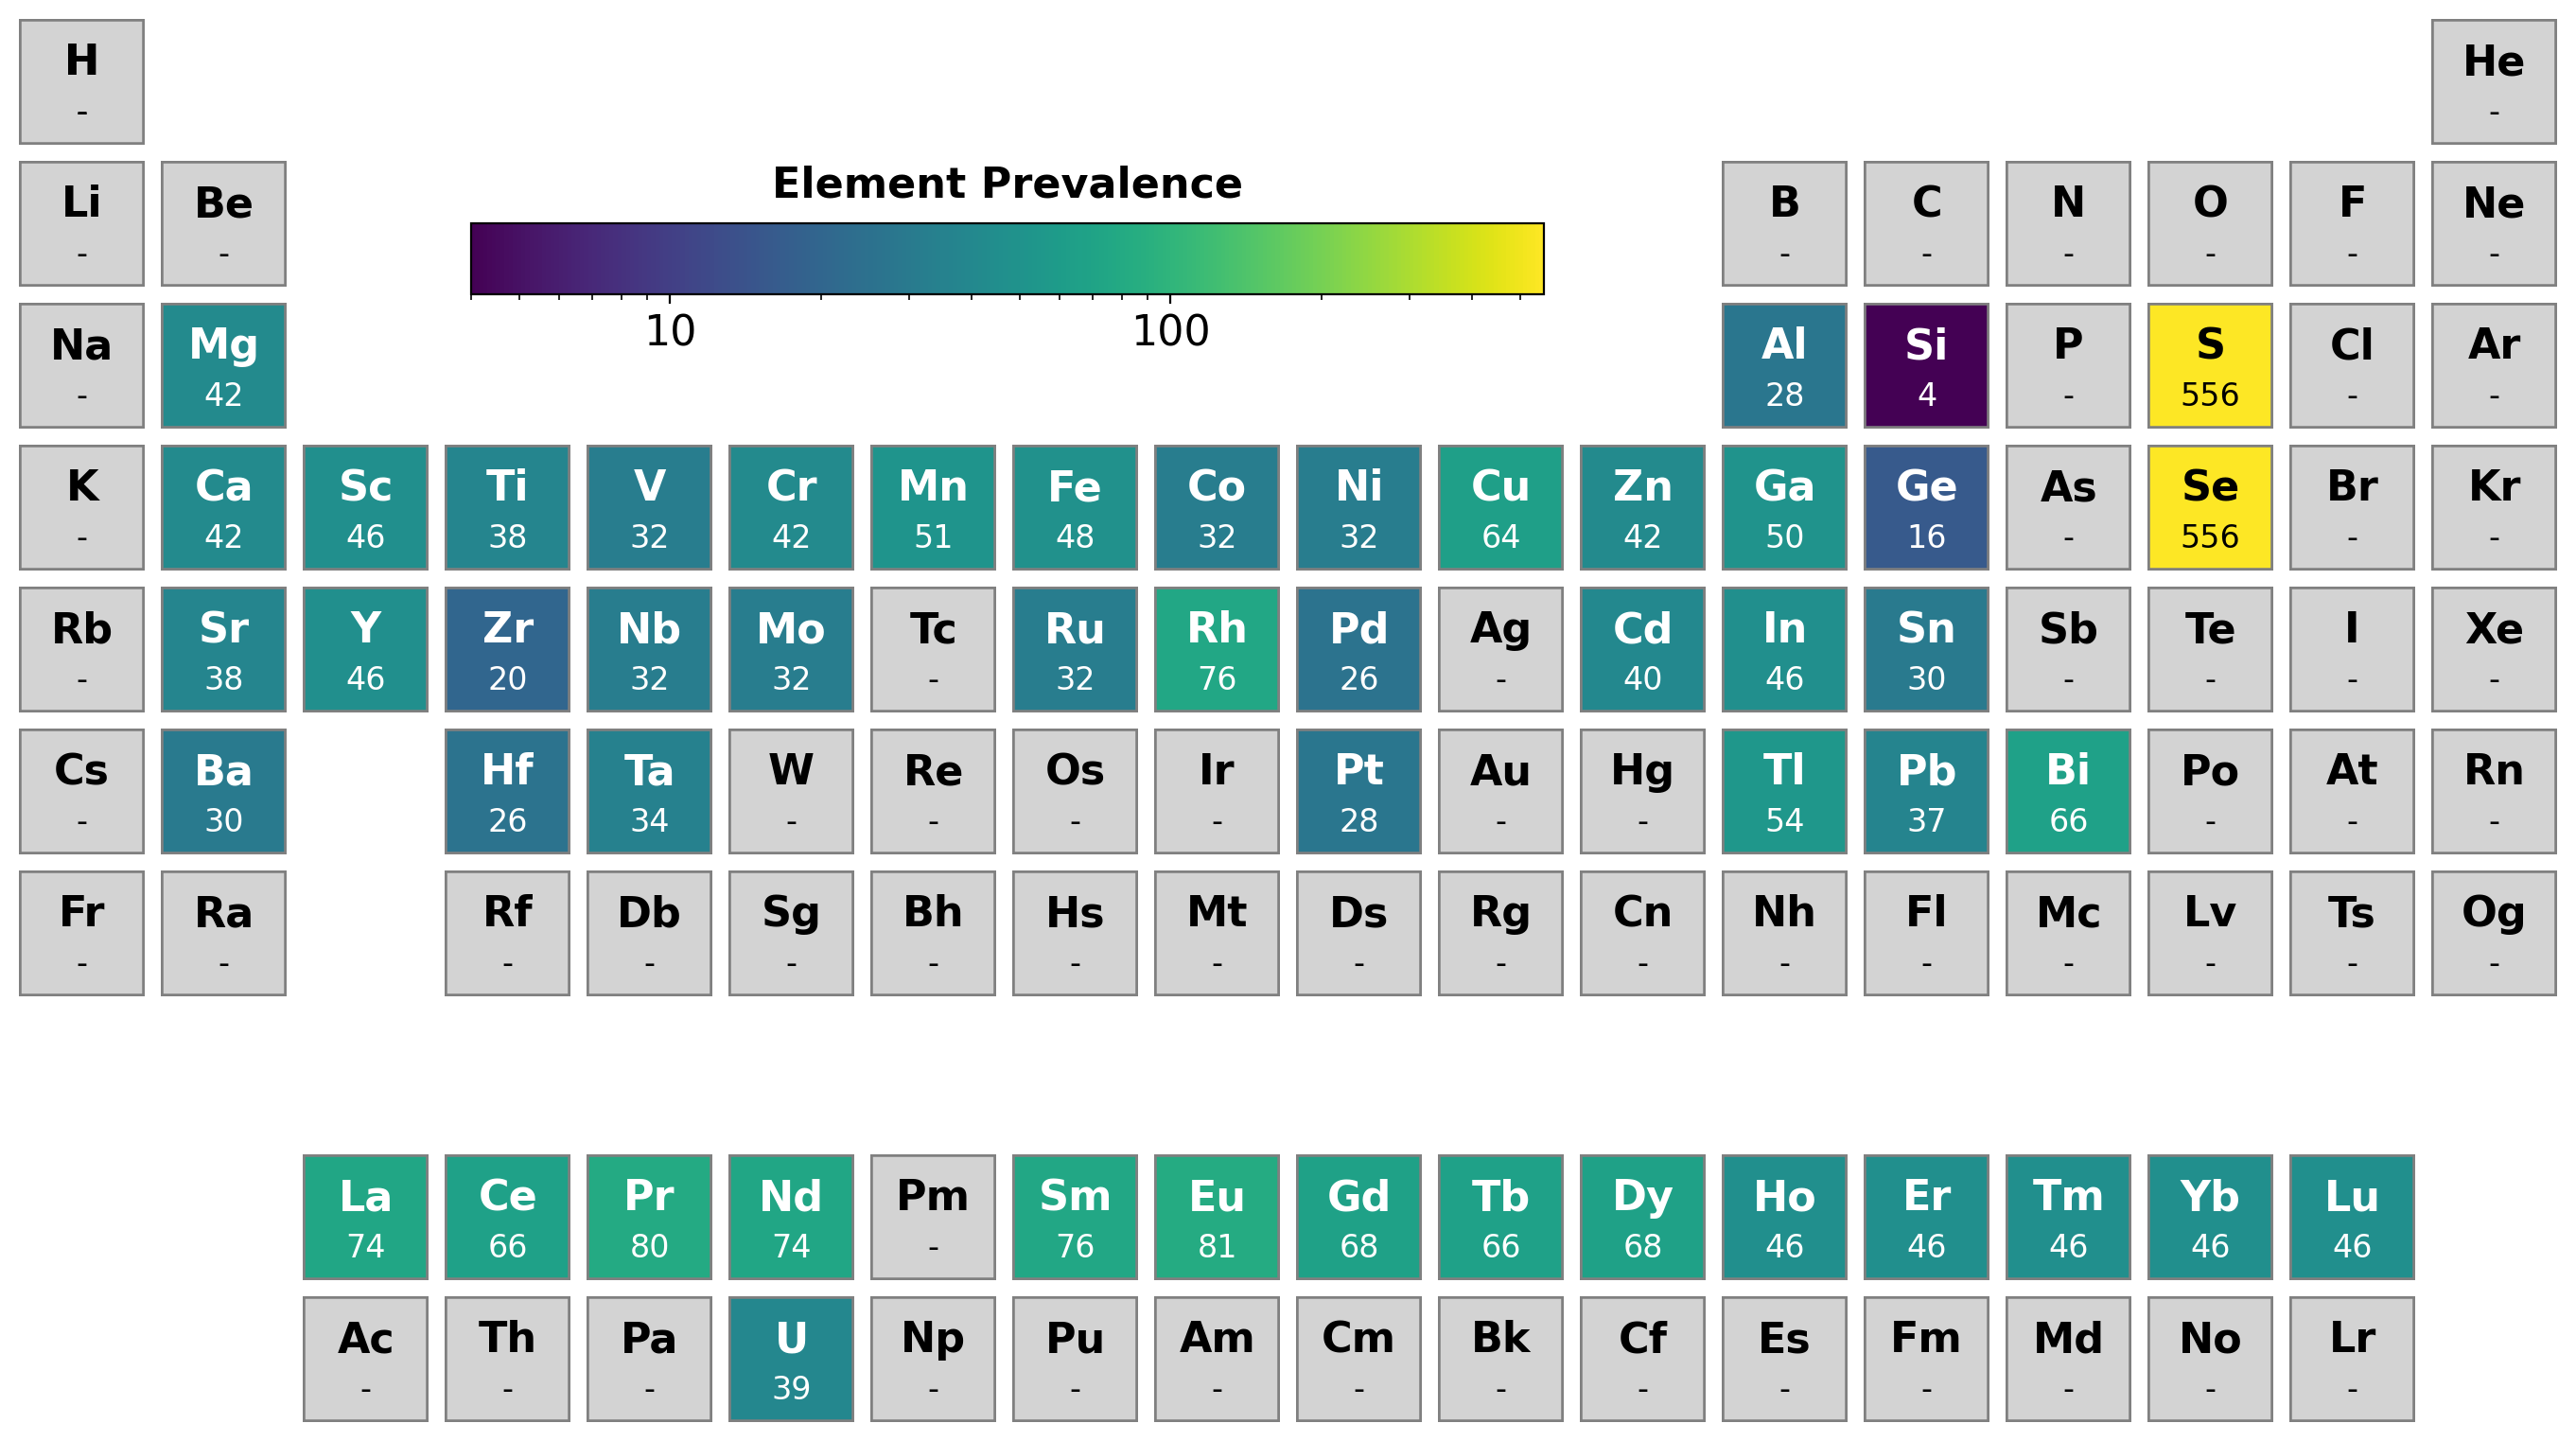

According to t_sisso_164, 1164 (100.0%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrS3', 'BaPrSe3', 'BaCeS3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUS3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


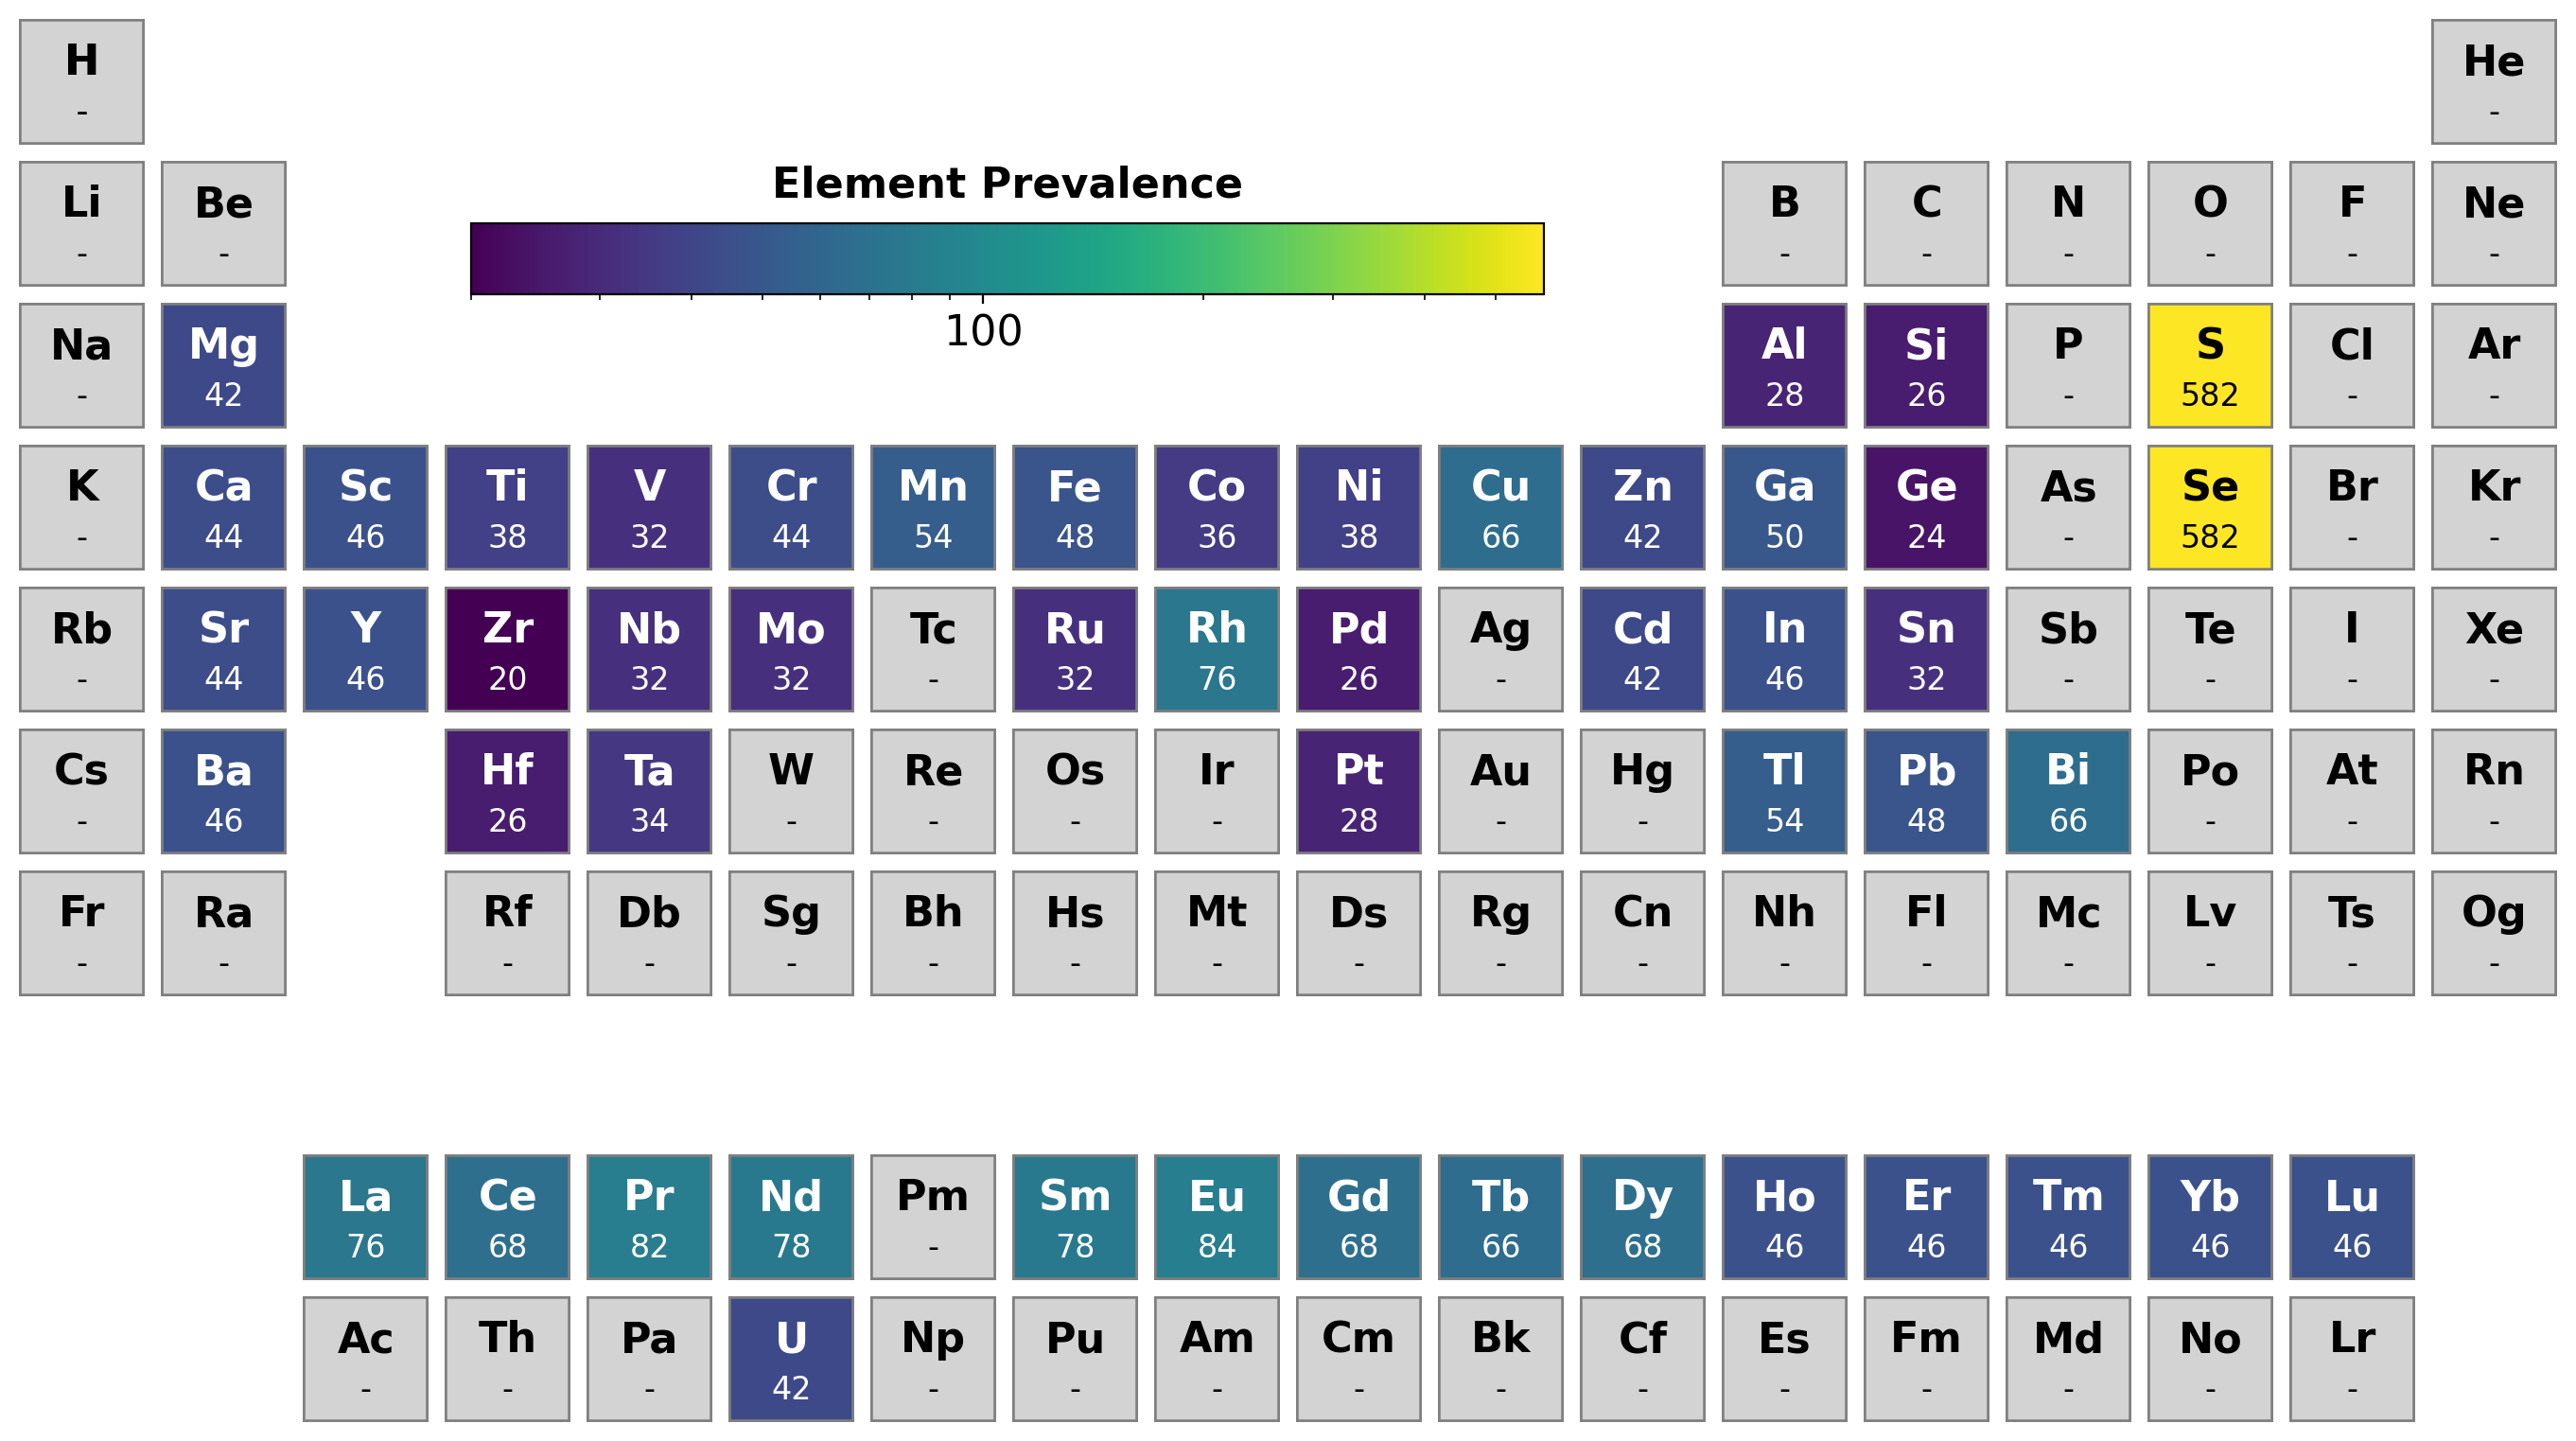

According to t_sisso_49, 8 (0.6872852233676976%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbCeS3', 'PbUS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


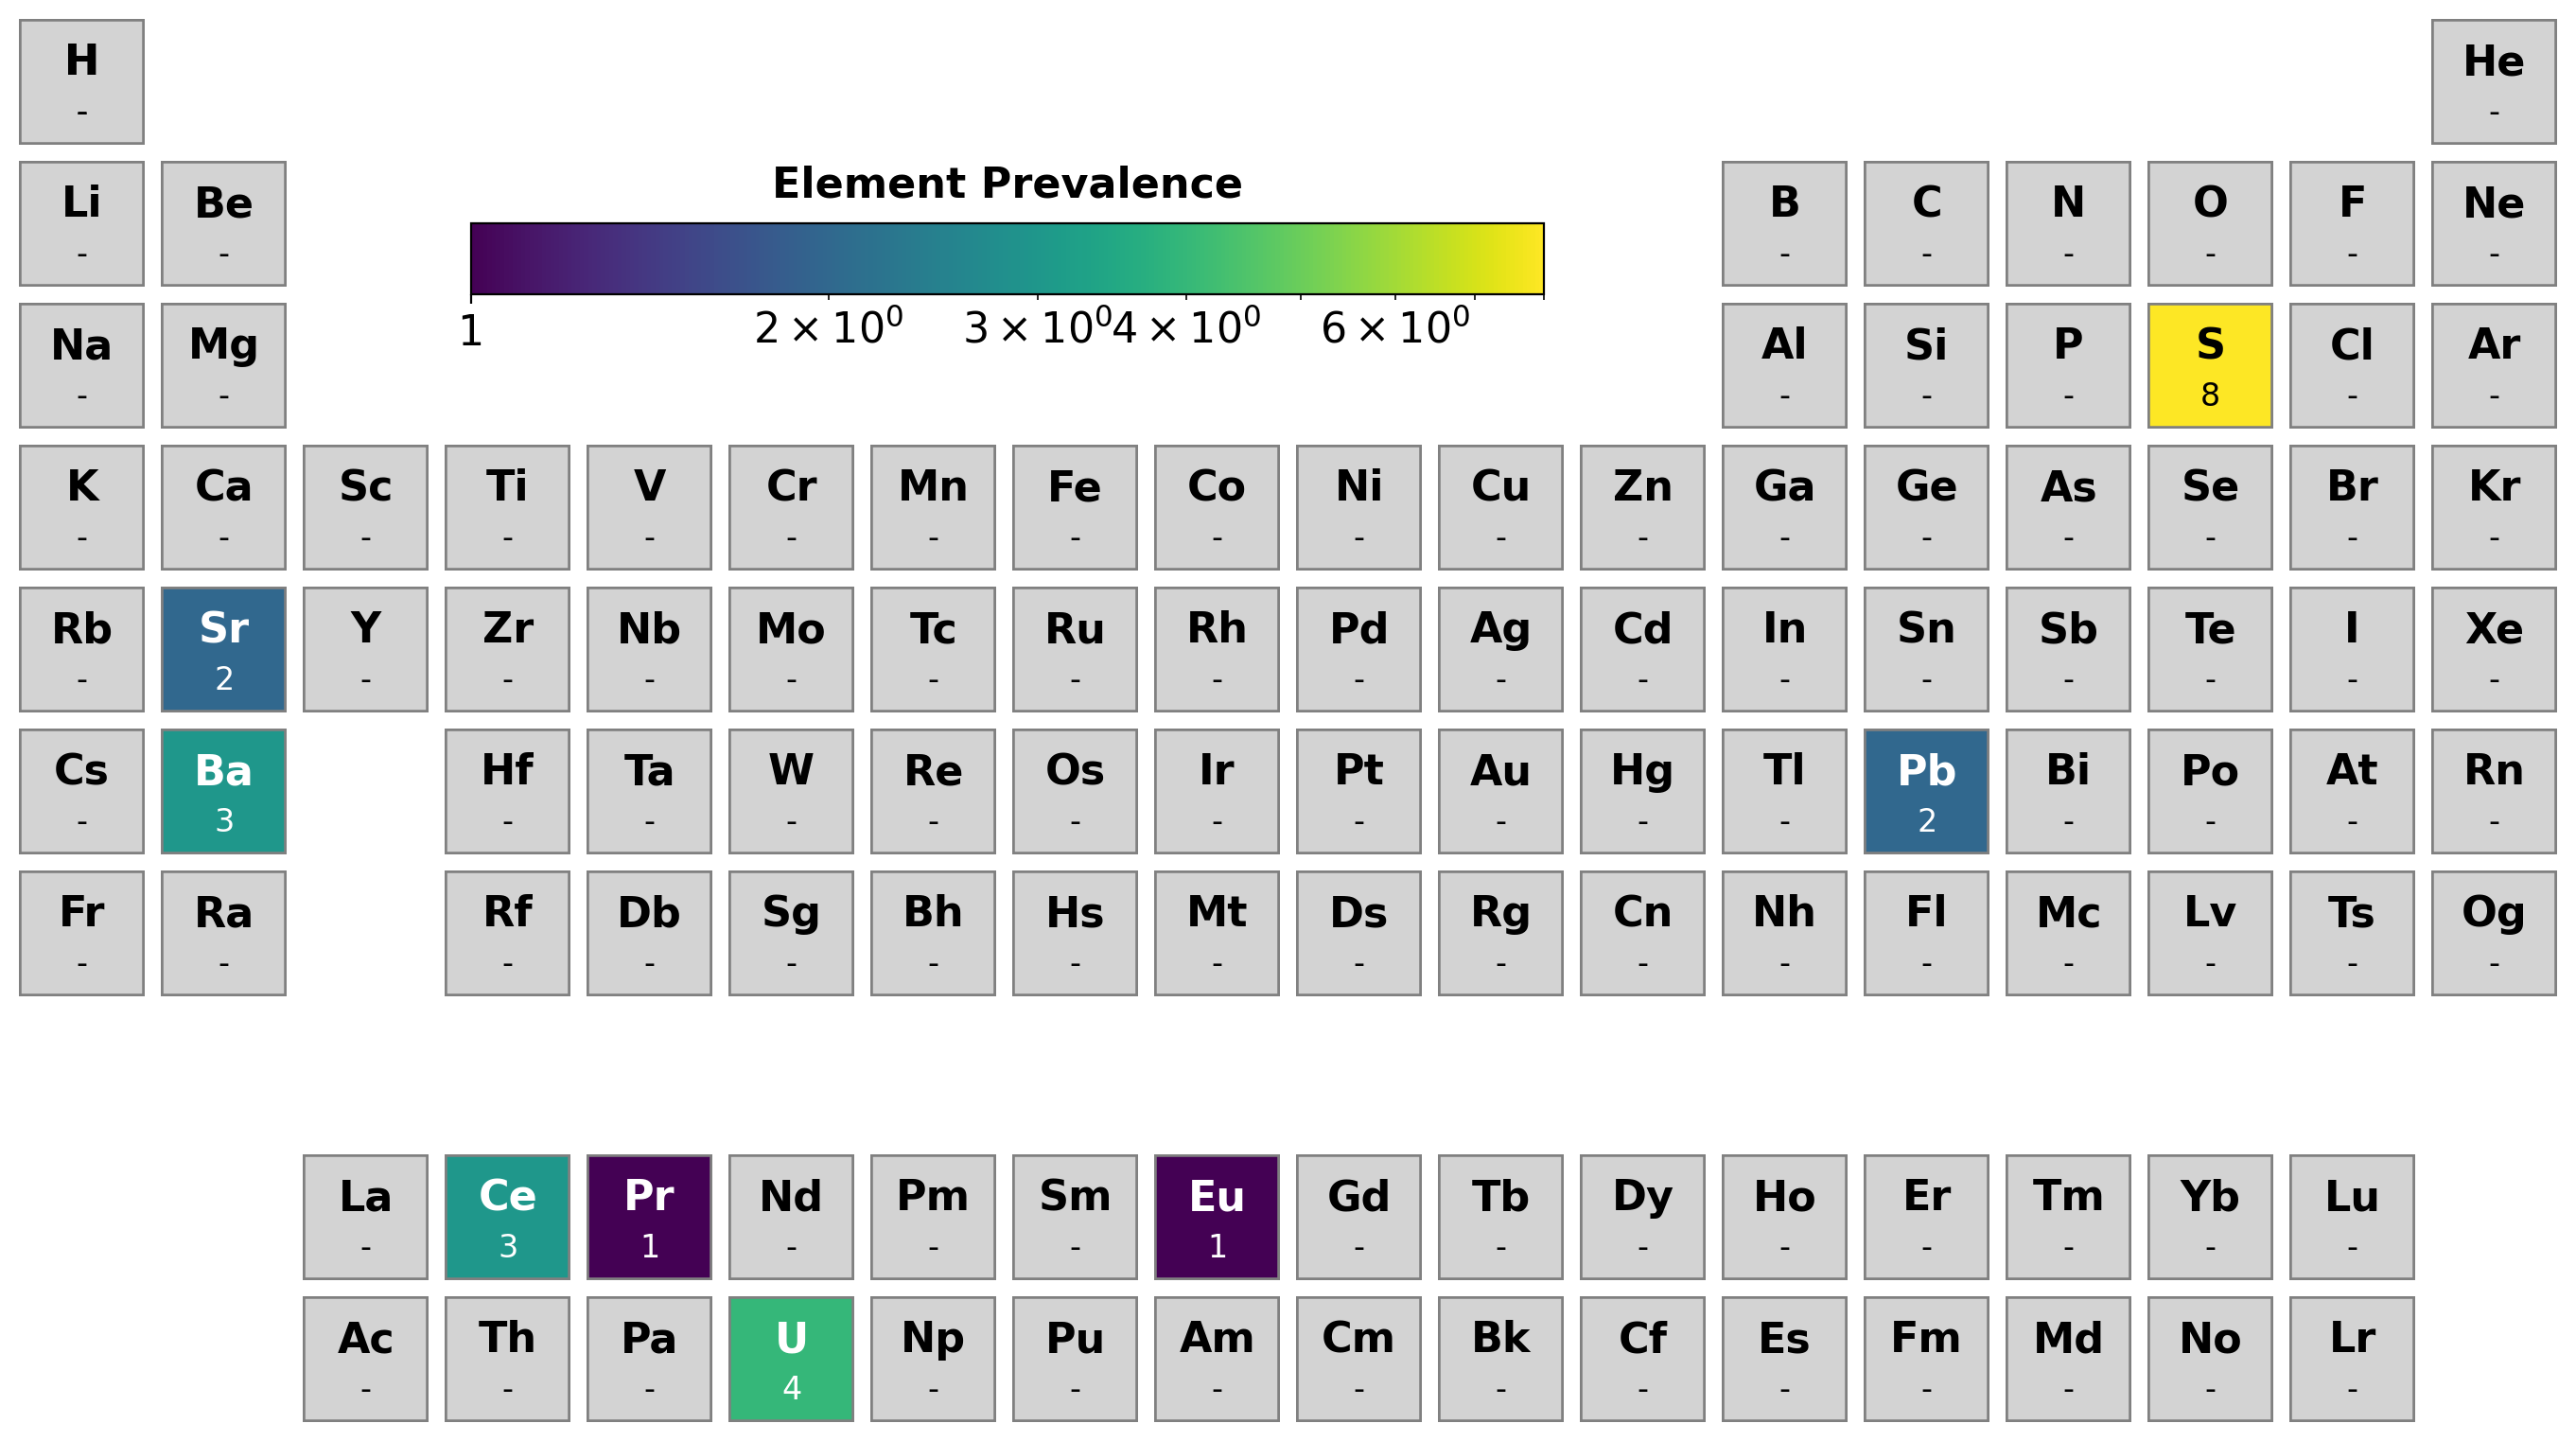

According to t_sisso_56, 1099 (94.41580756013745%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrS3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuS

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


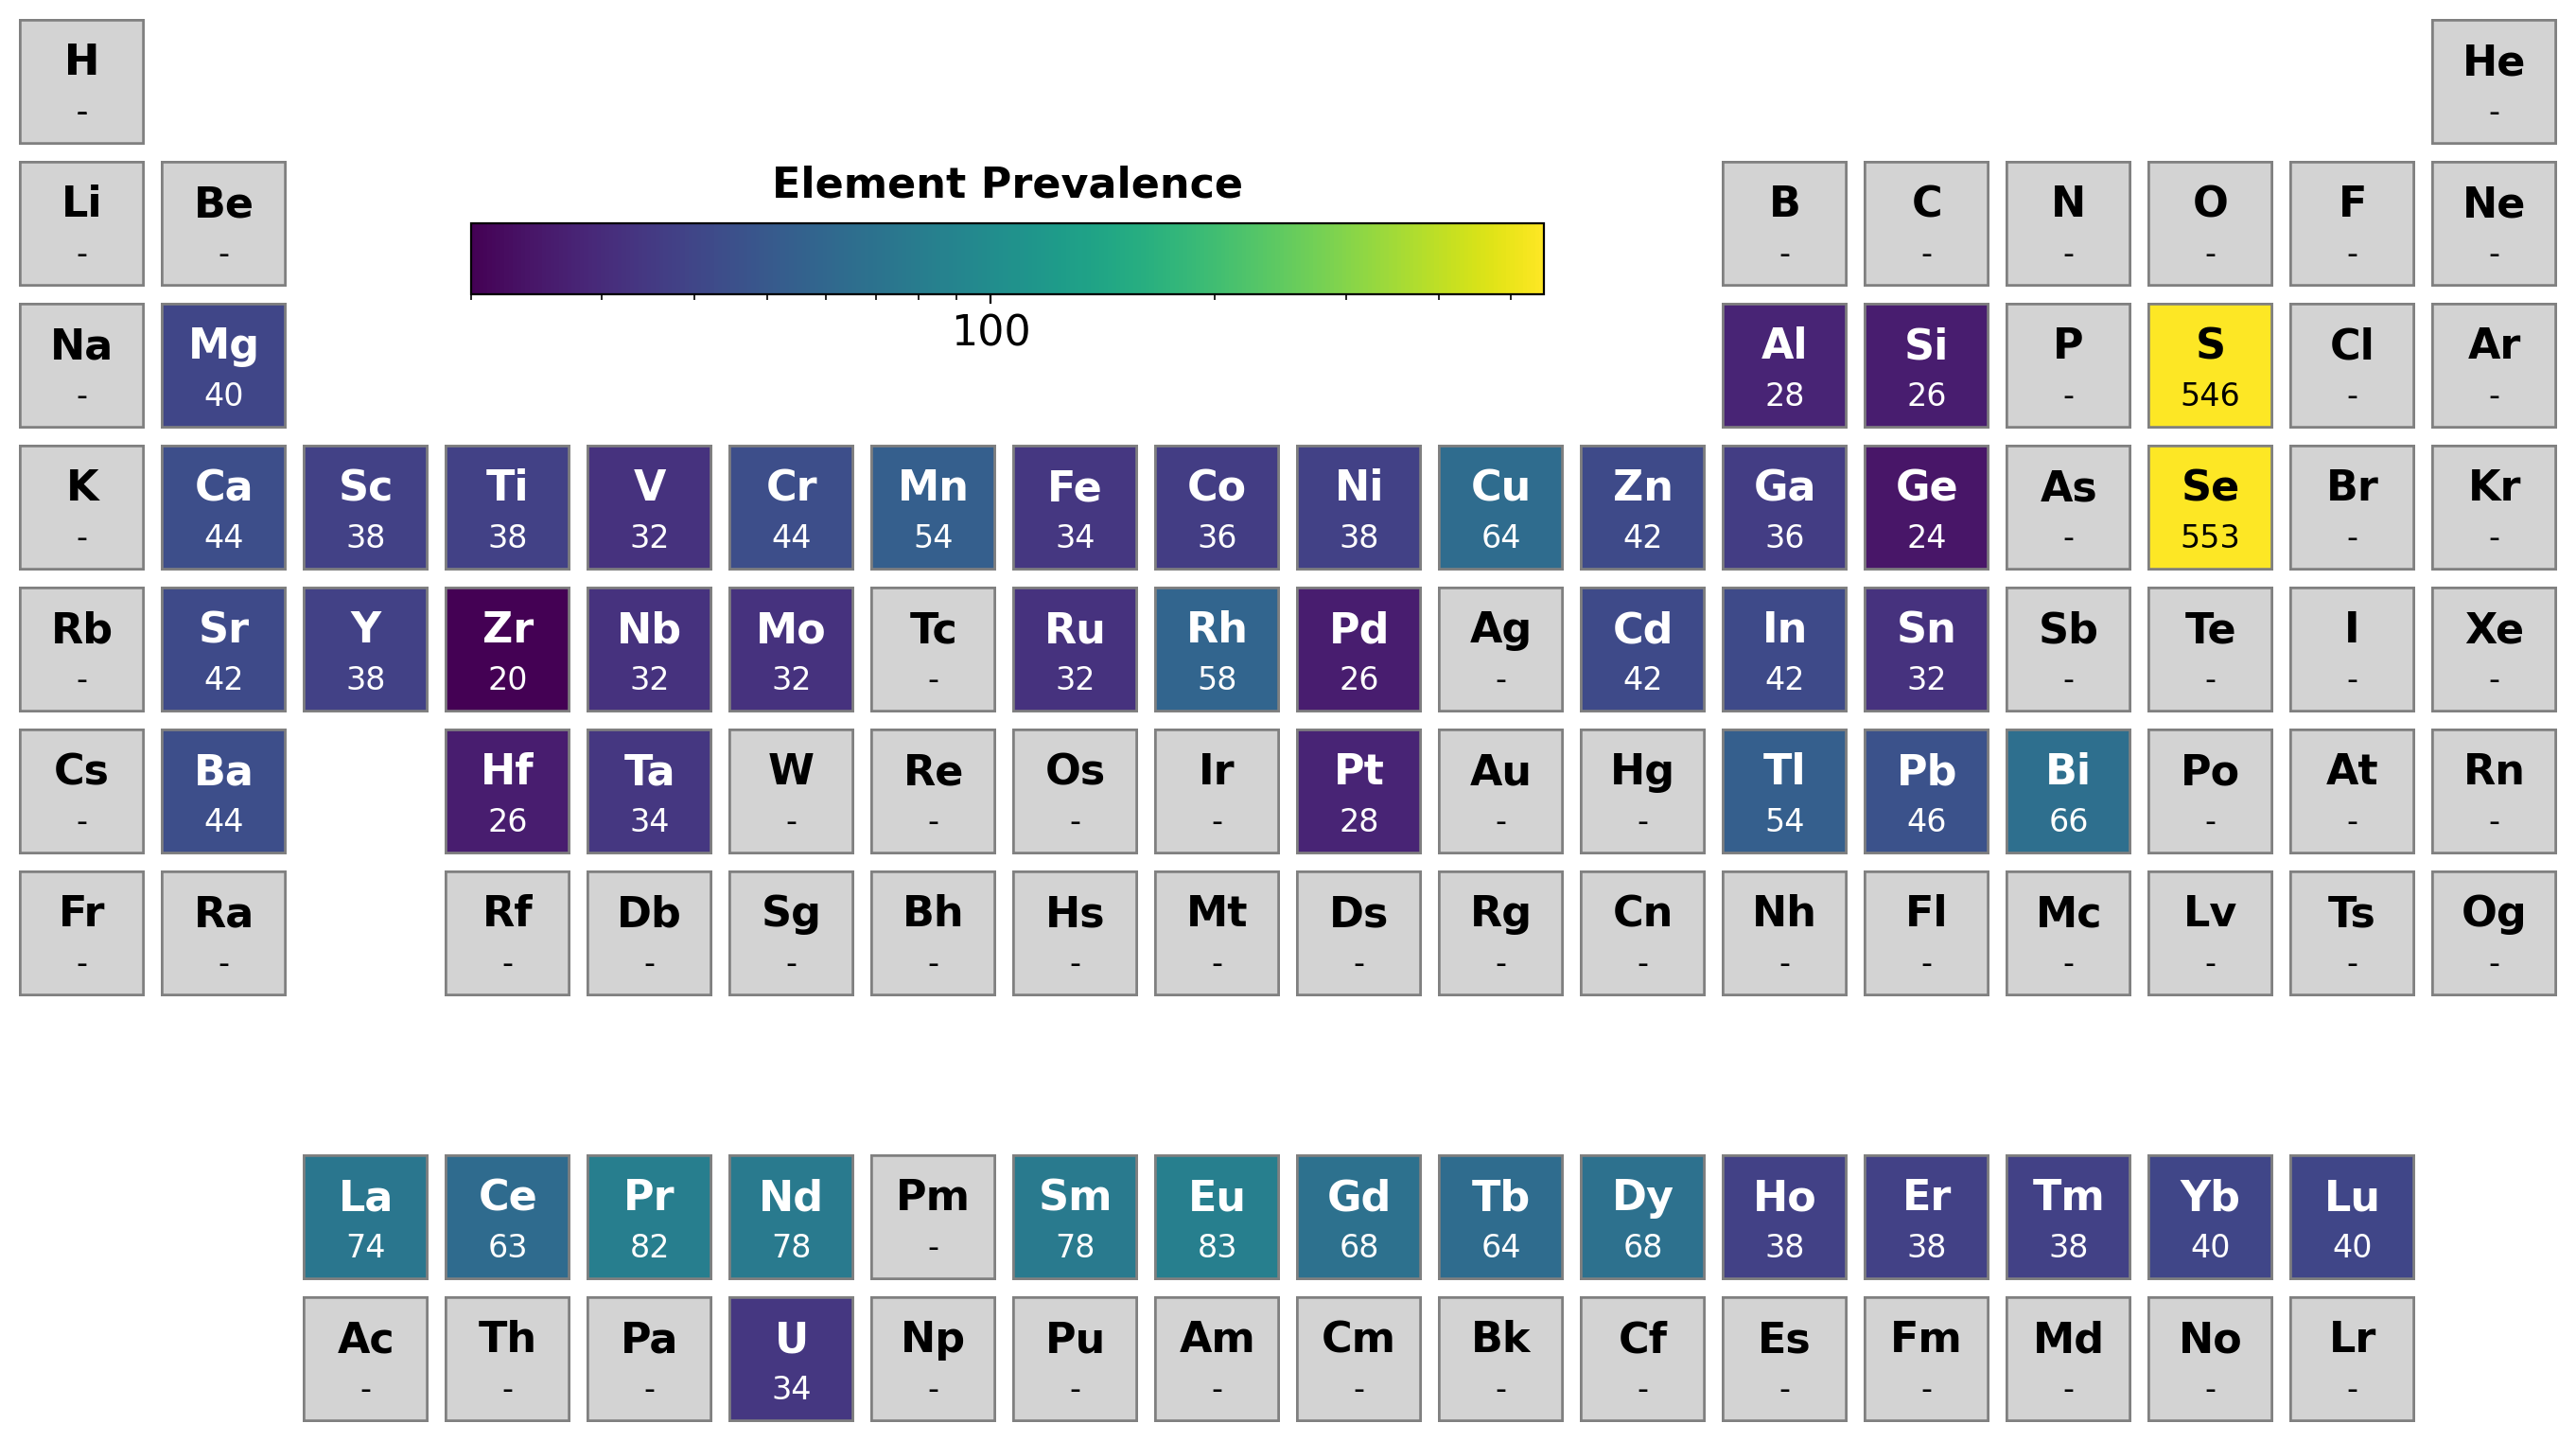

According to t_sisso_41, 1151 (98.8831615120275%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTi

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


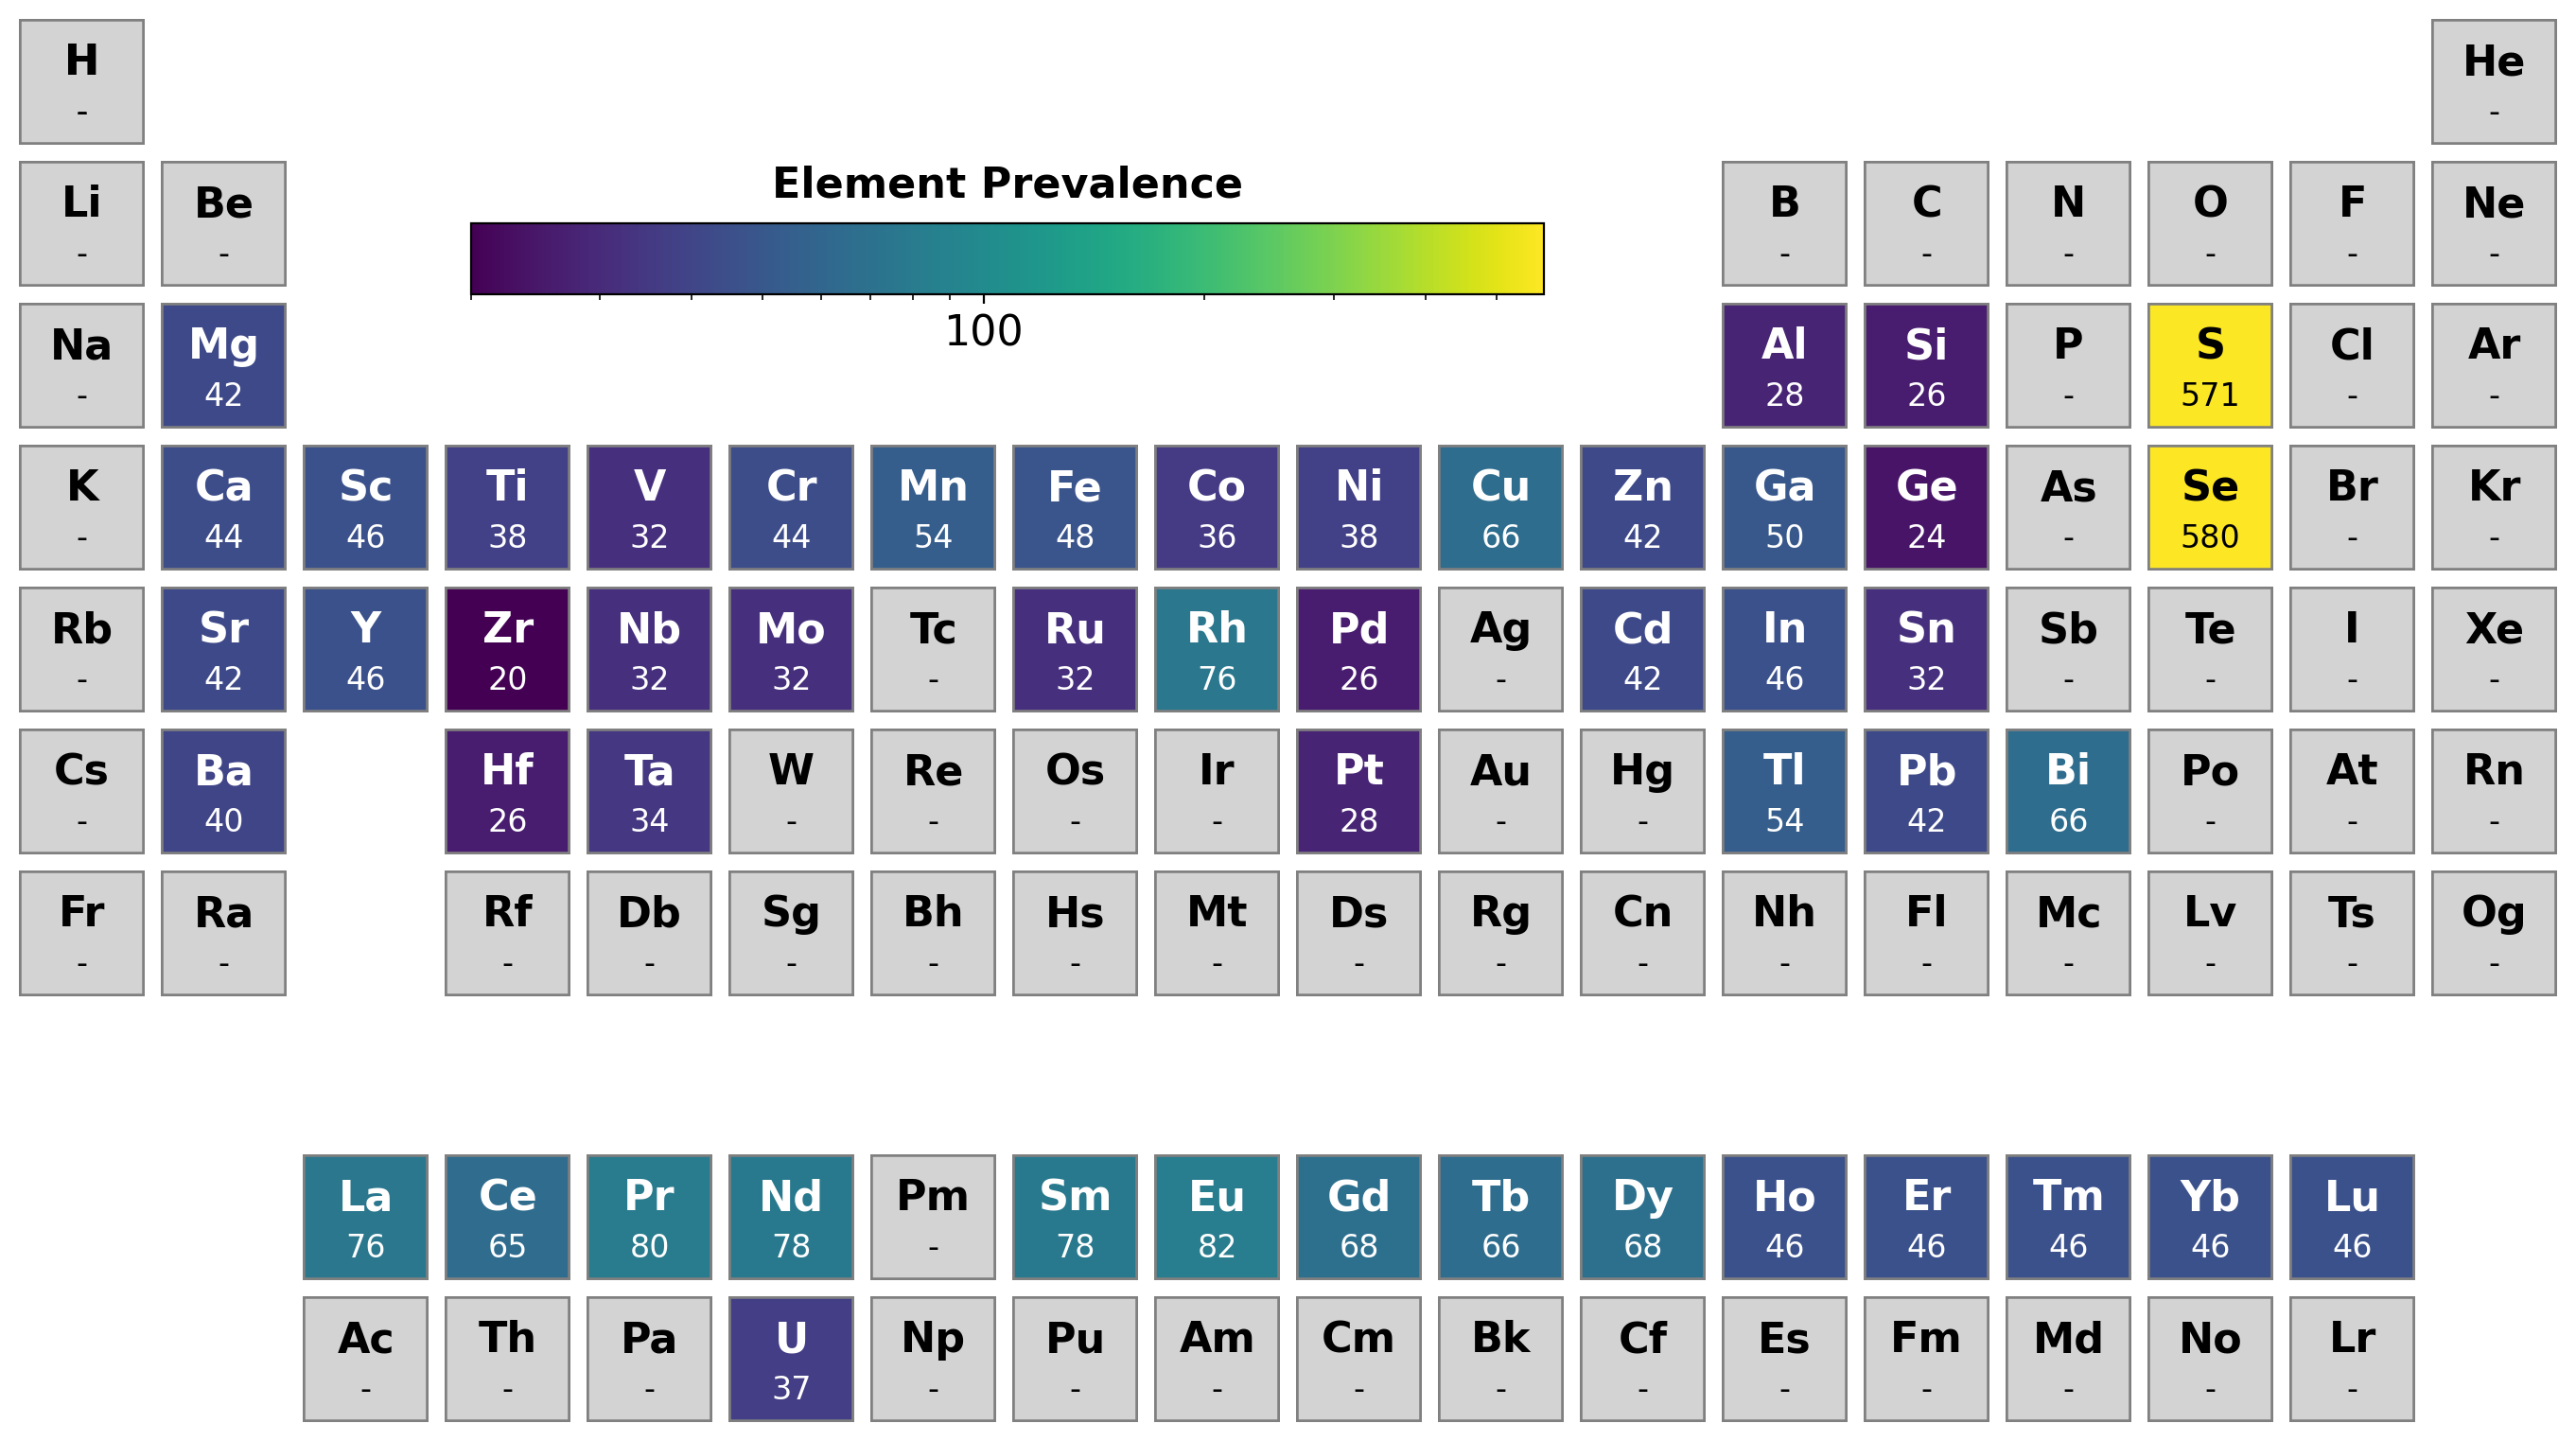

According to t_sisso_62, 8 (0.6872852233676976%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbCeS3', 'PbUS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


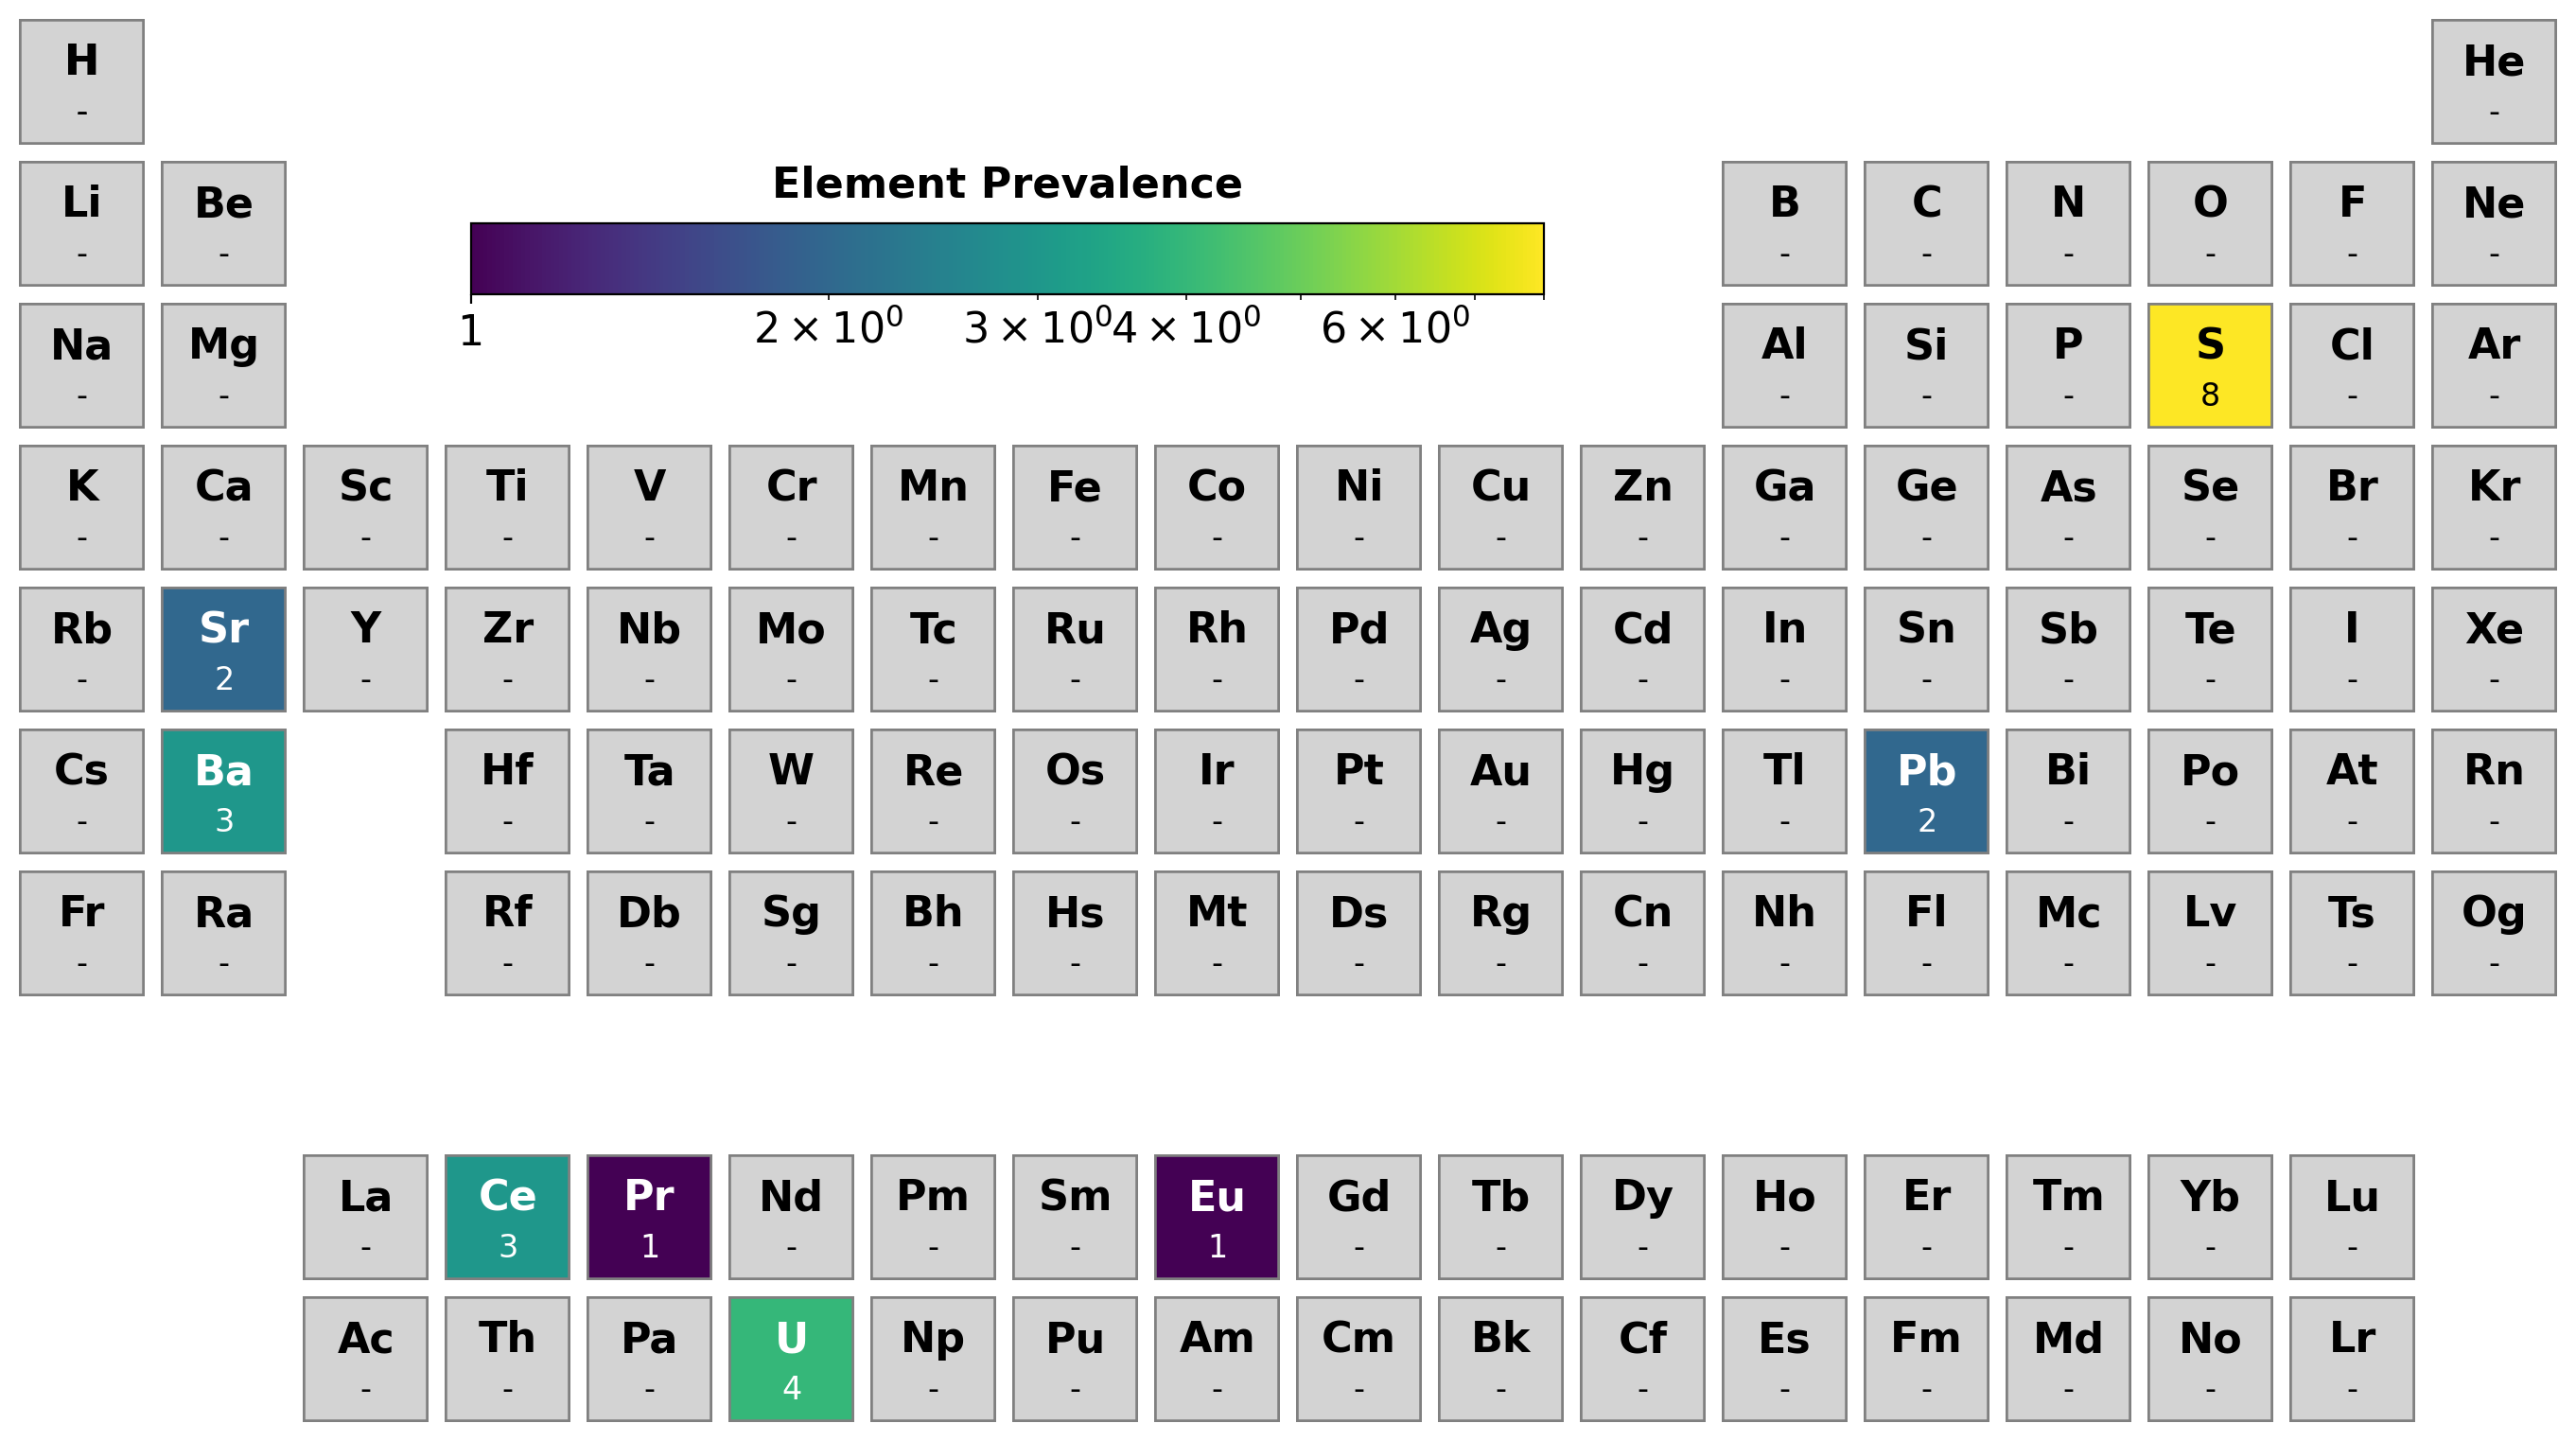

According to t_sisso_125, 1098 (94.3298969072165%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'Eu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


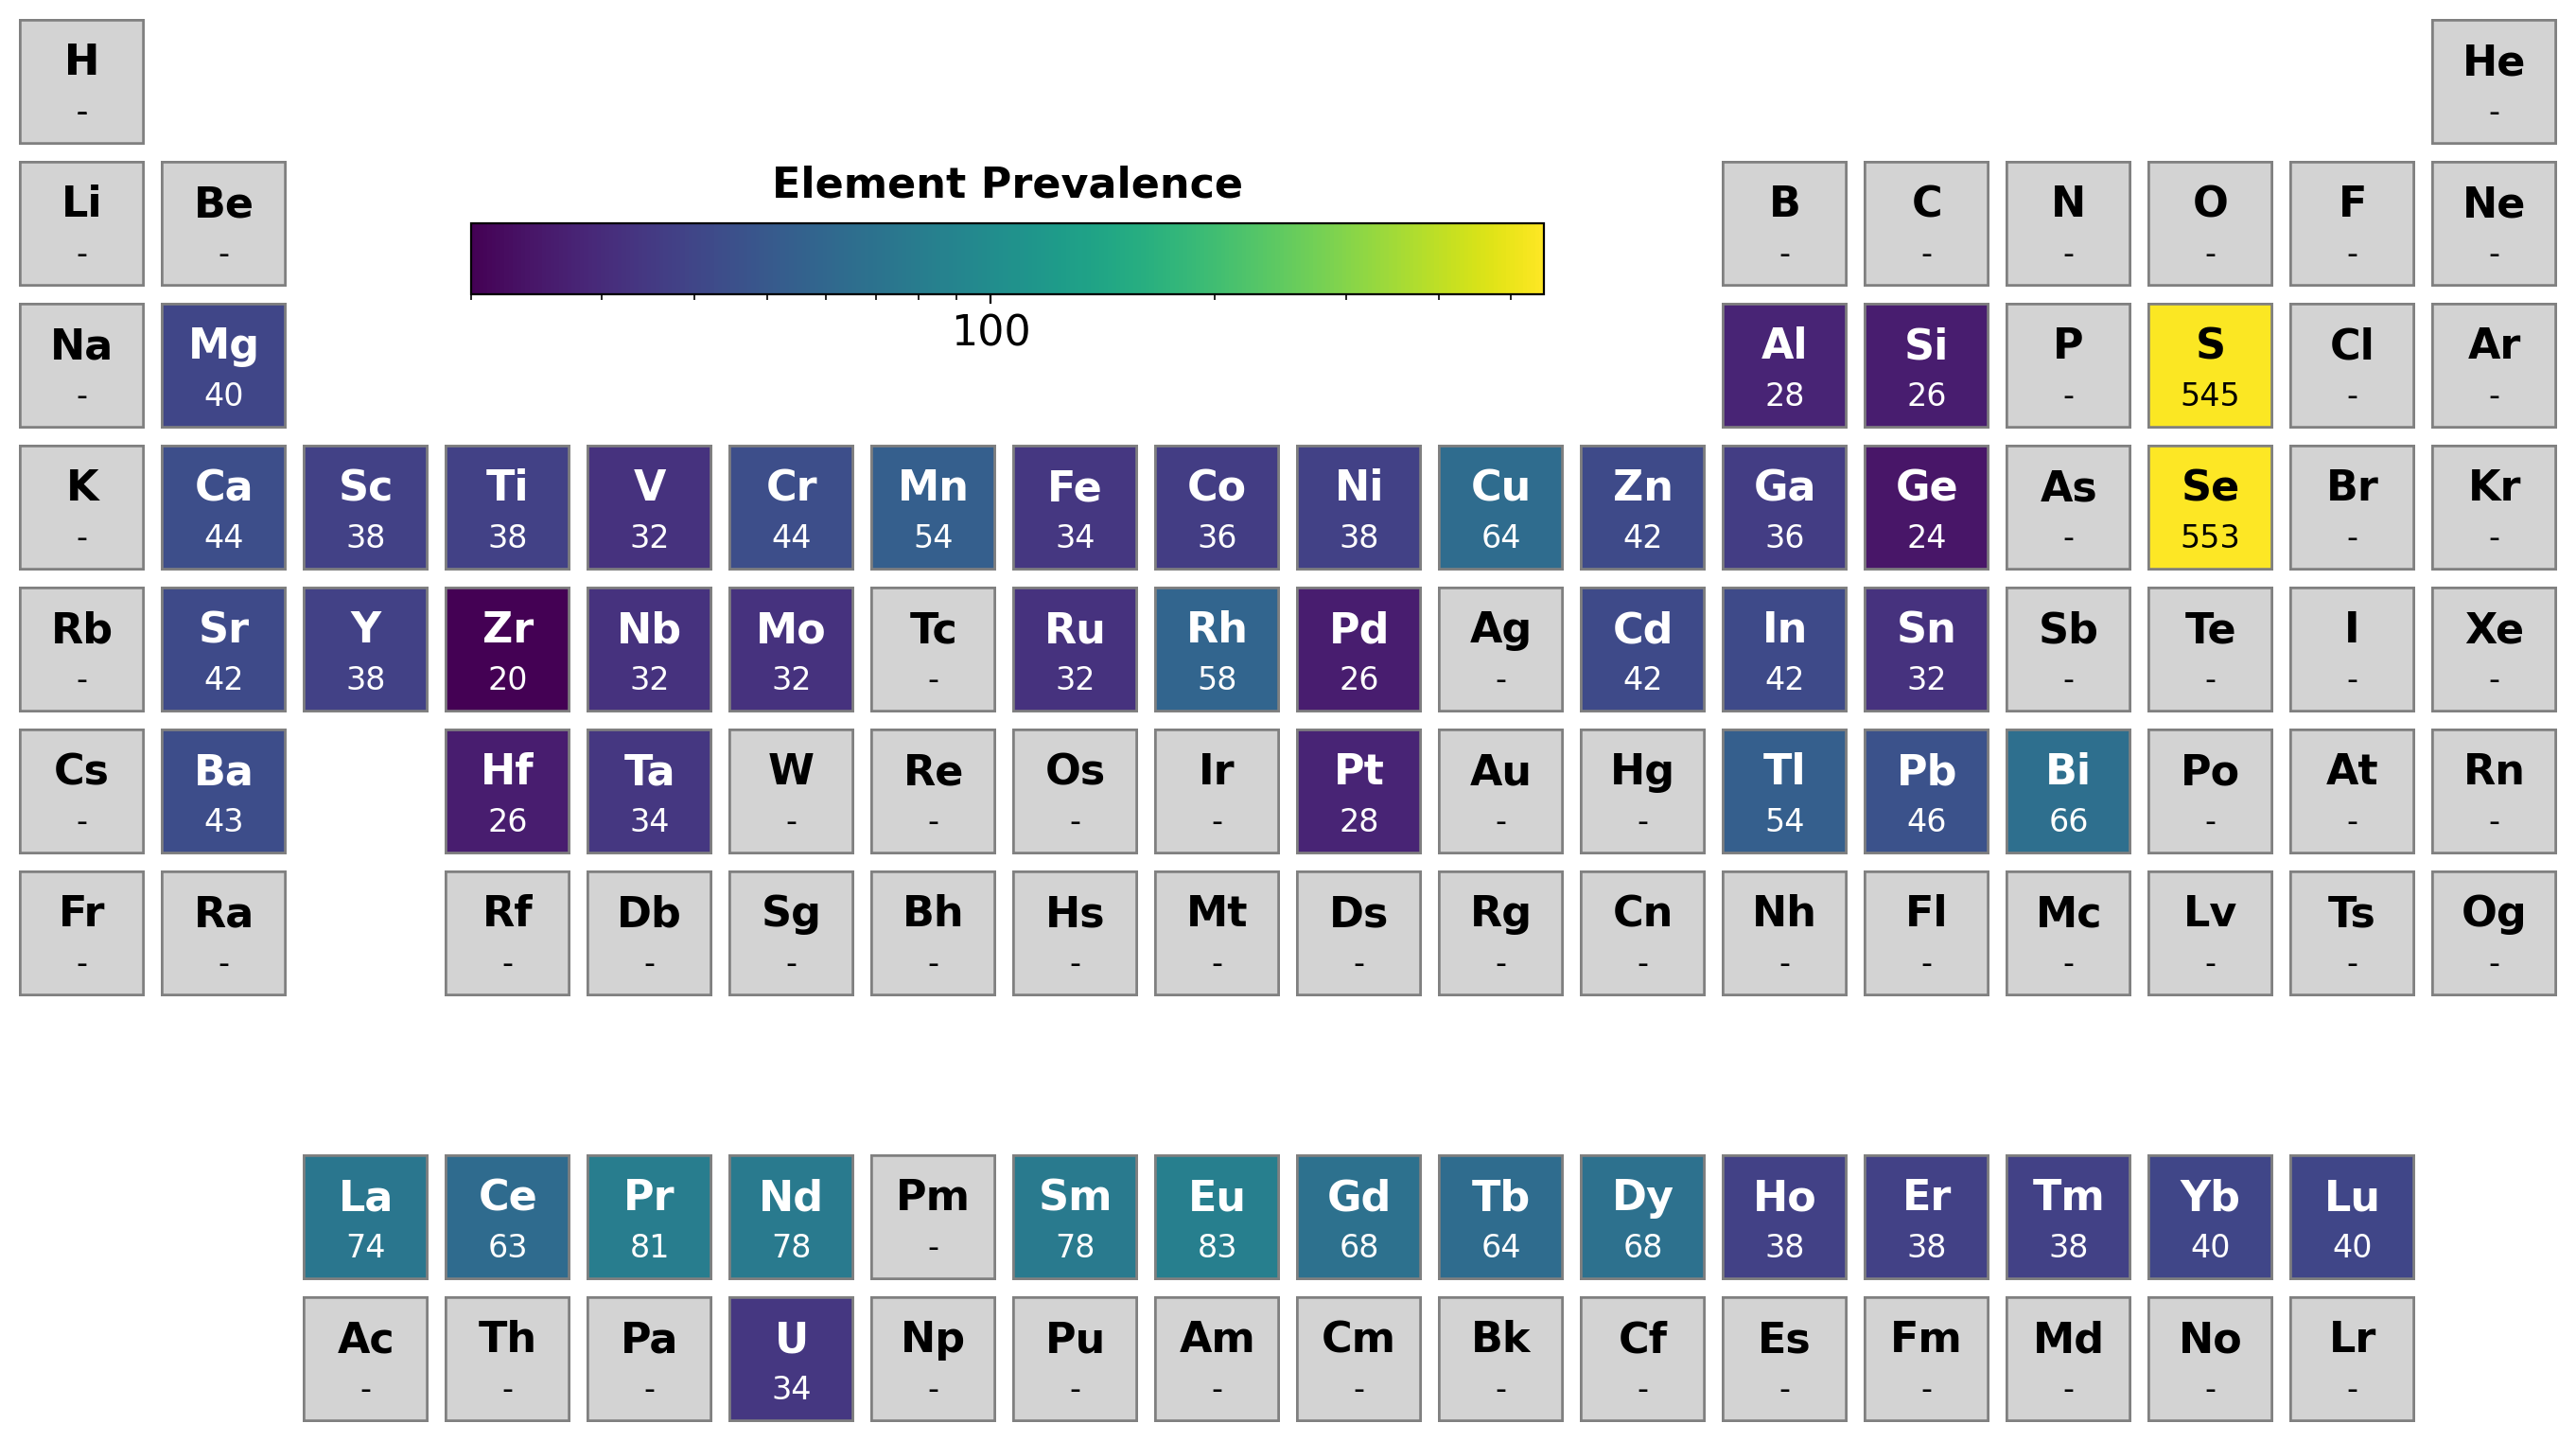

According to t_sisso_37, 1151 (98.8831615120275%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTi

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


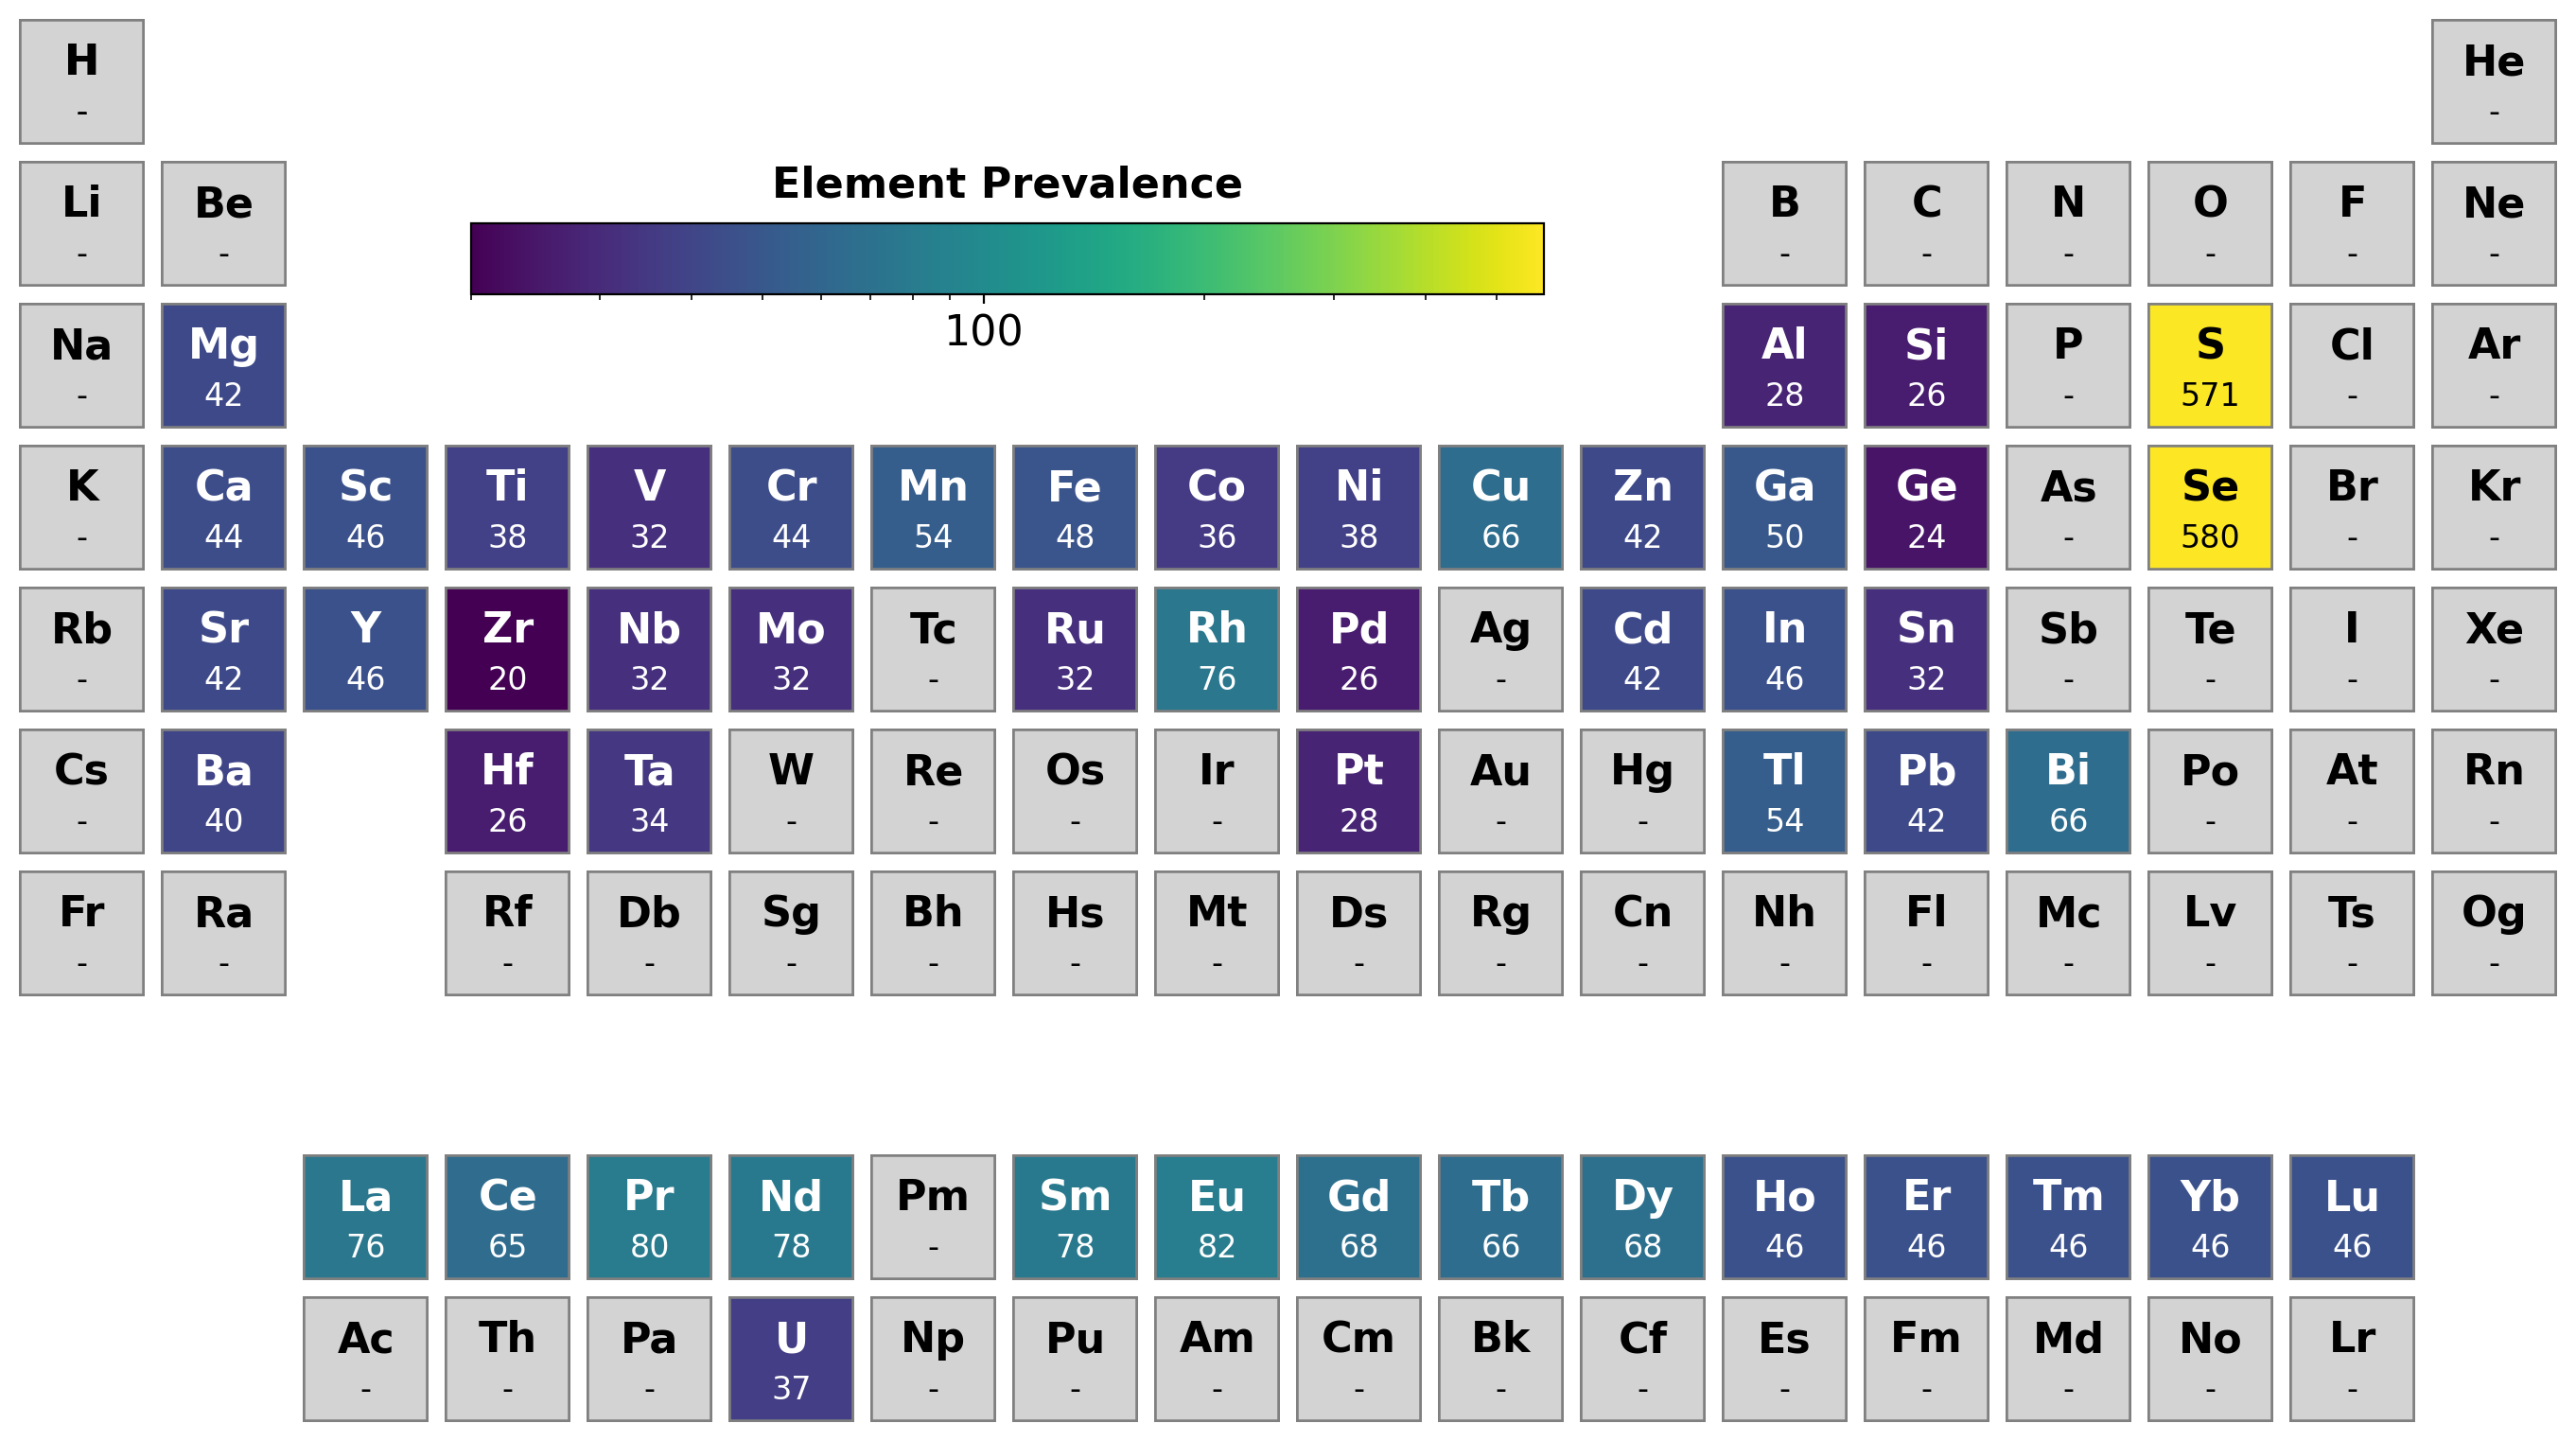

According to t_sisso_38, 8 (0.6872852233676976%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbCeS3', 'PbUS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


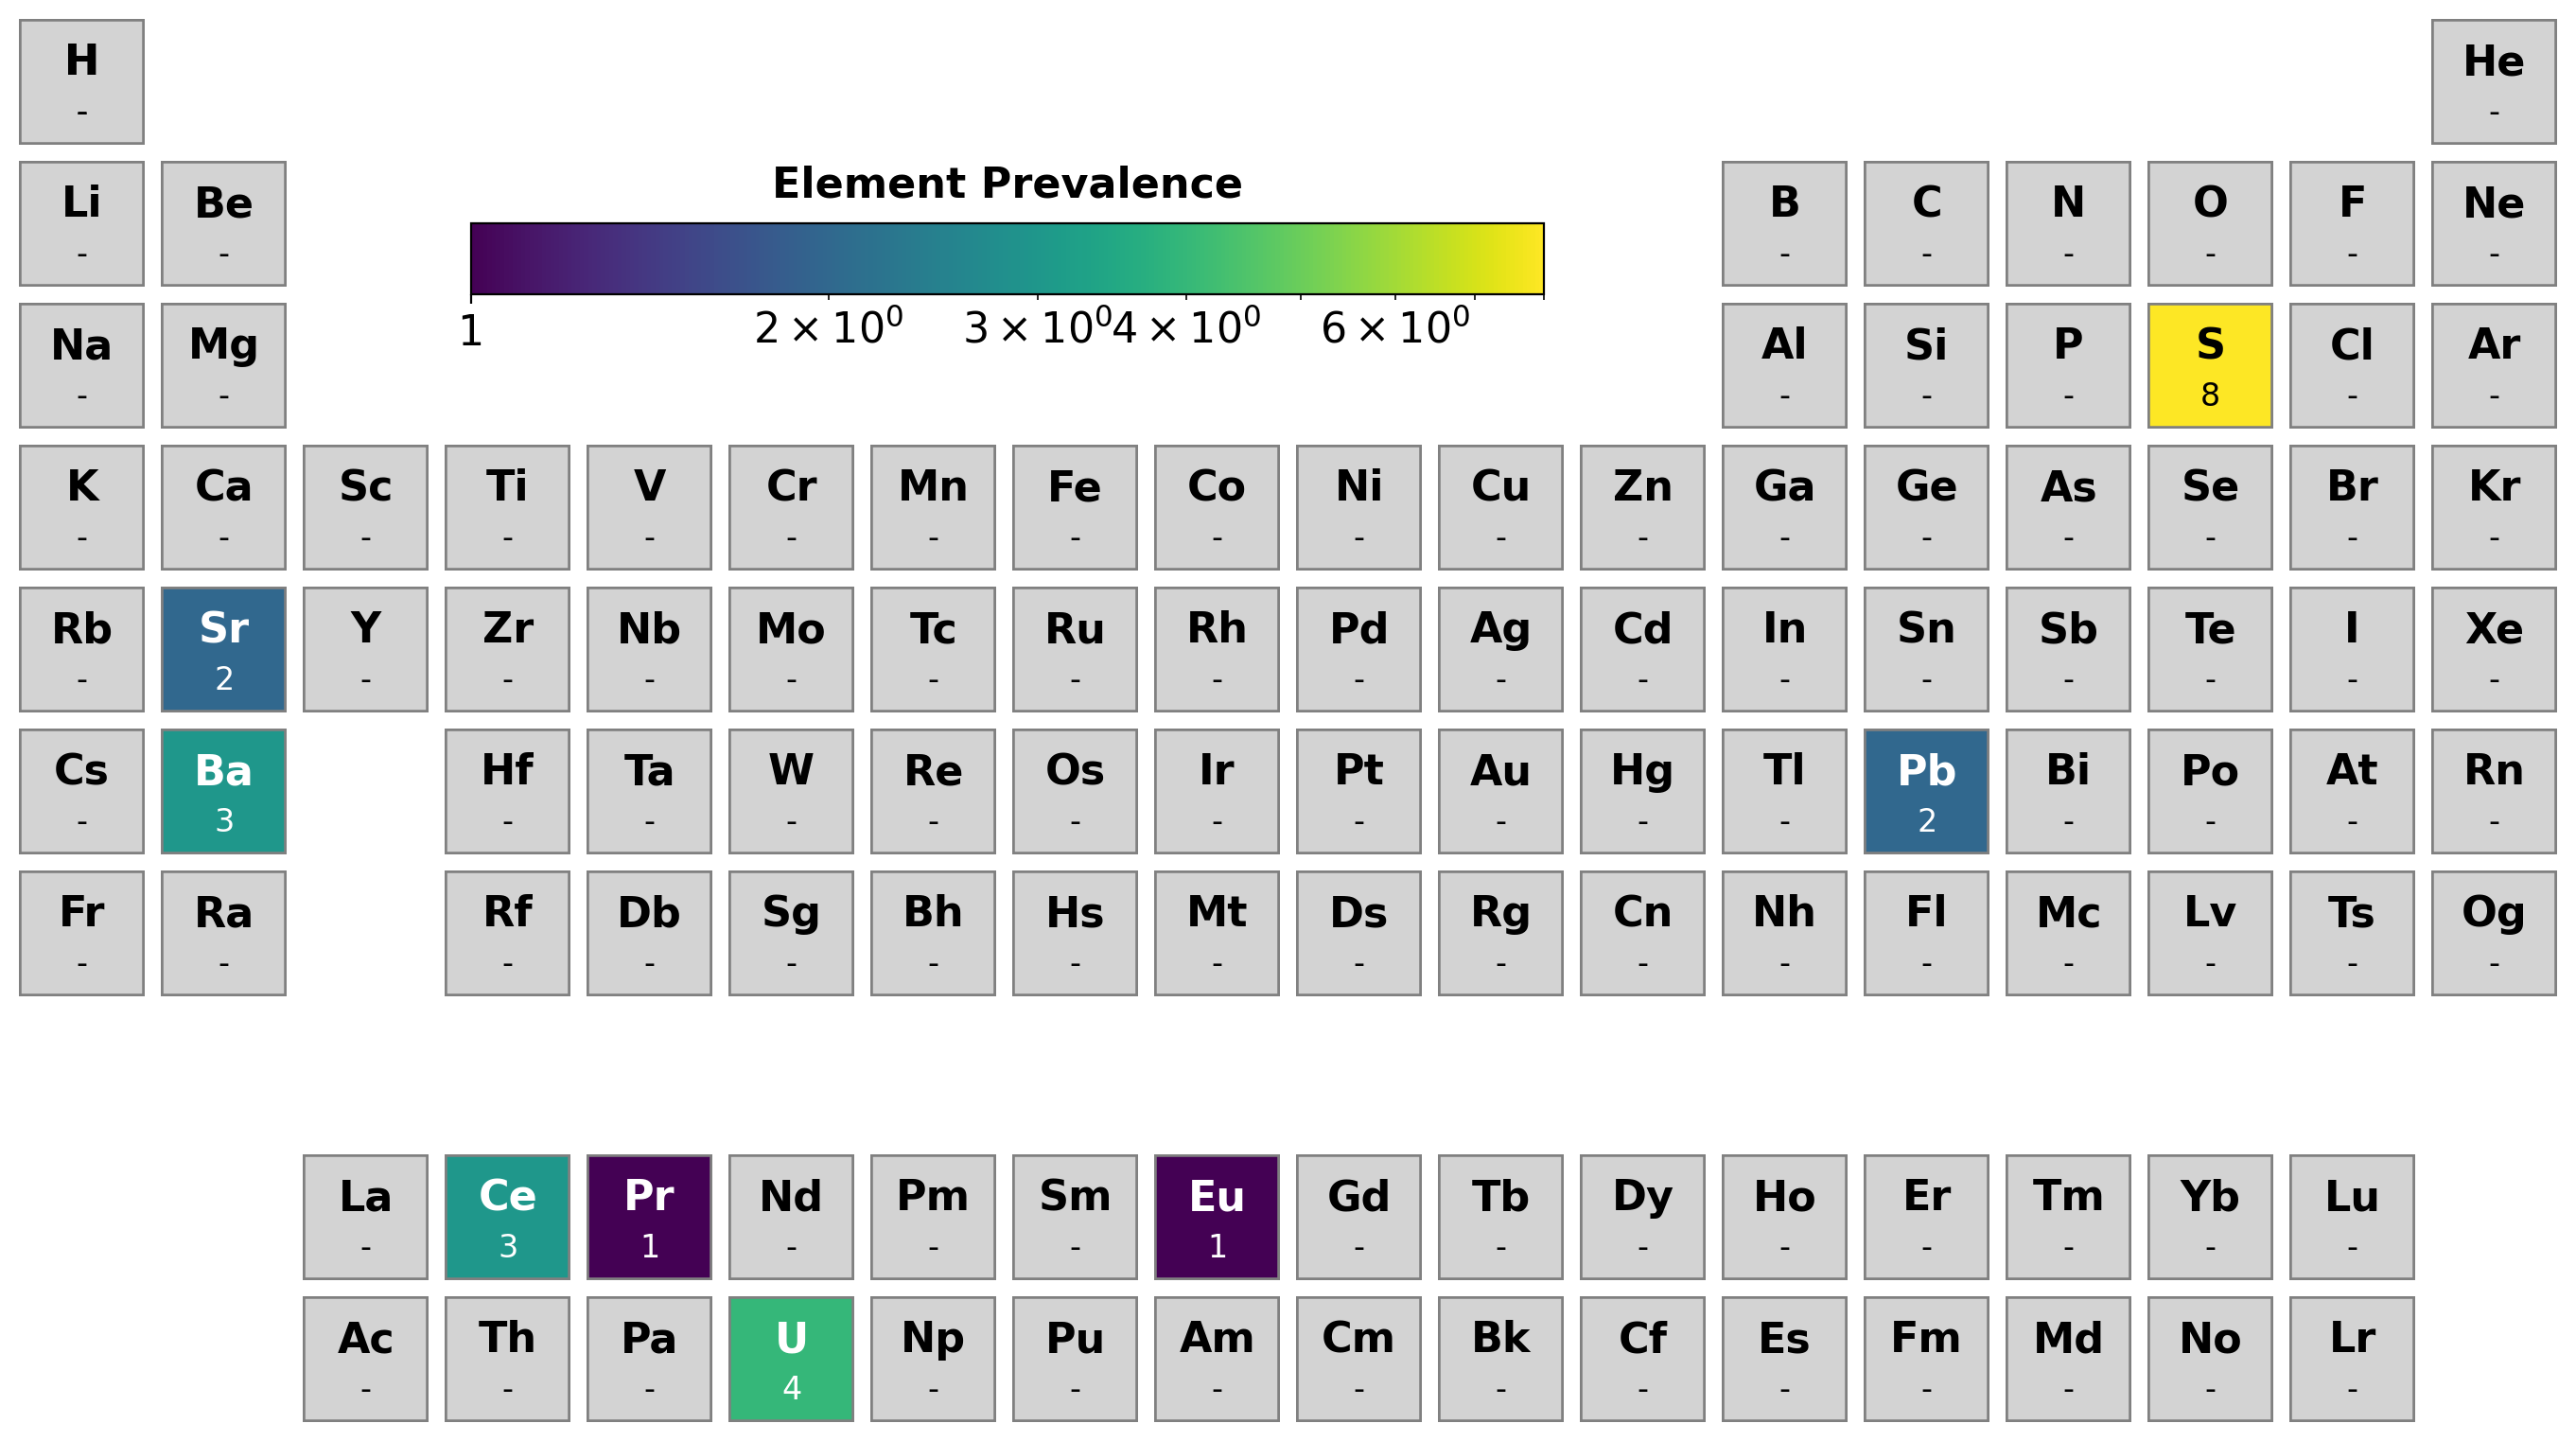

According to t_sisso_40, 1151 (98.8831615120275%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTi

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


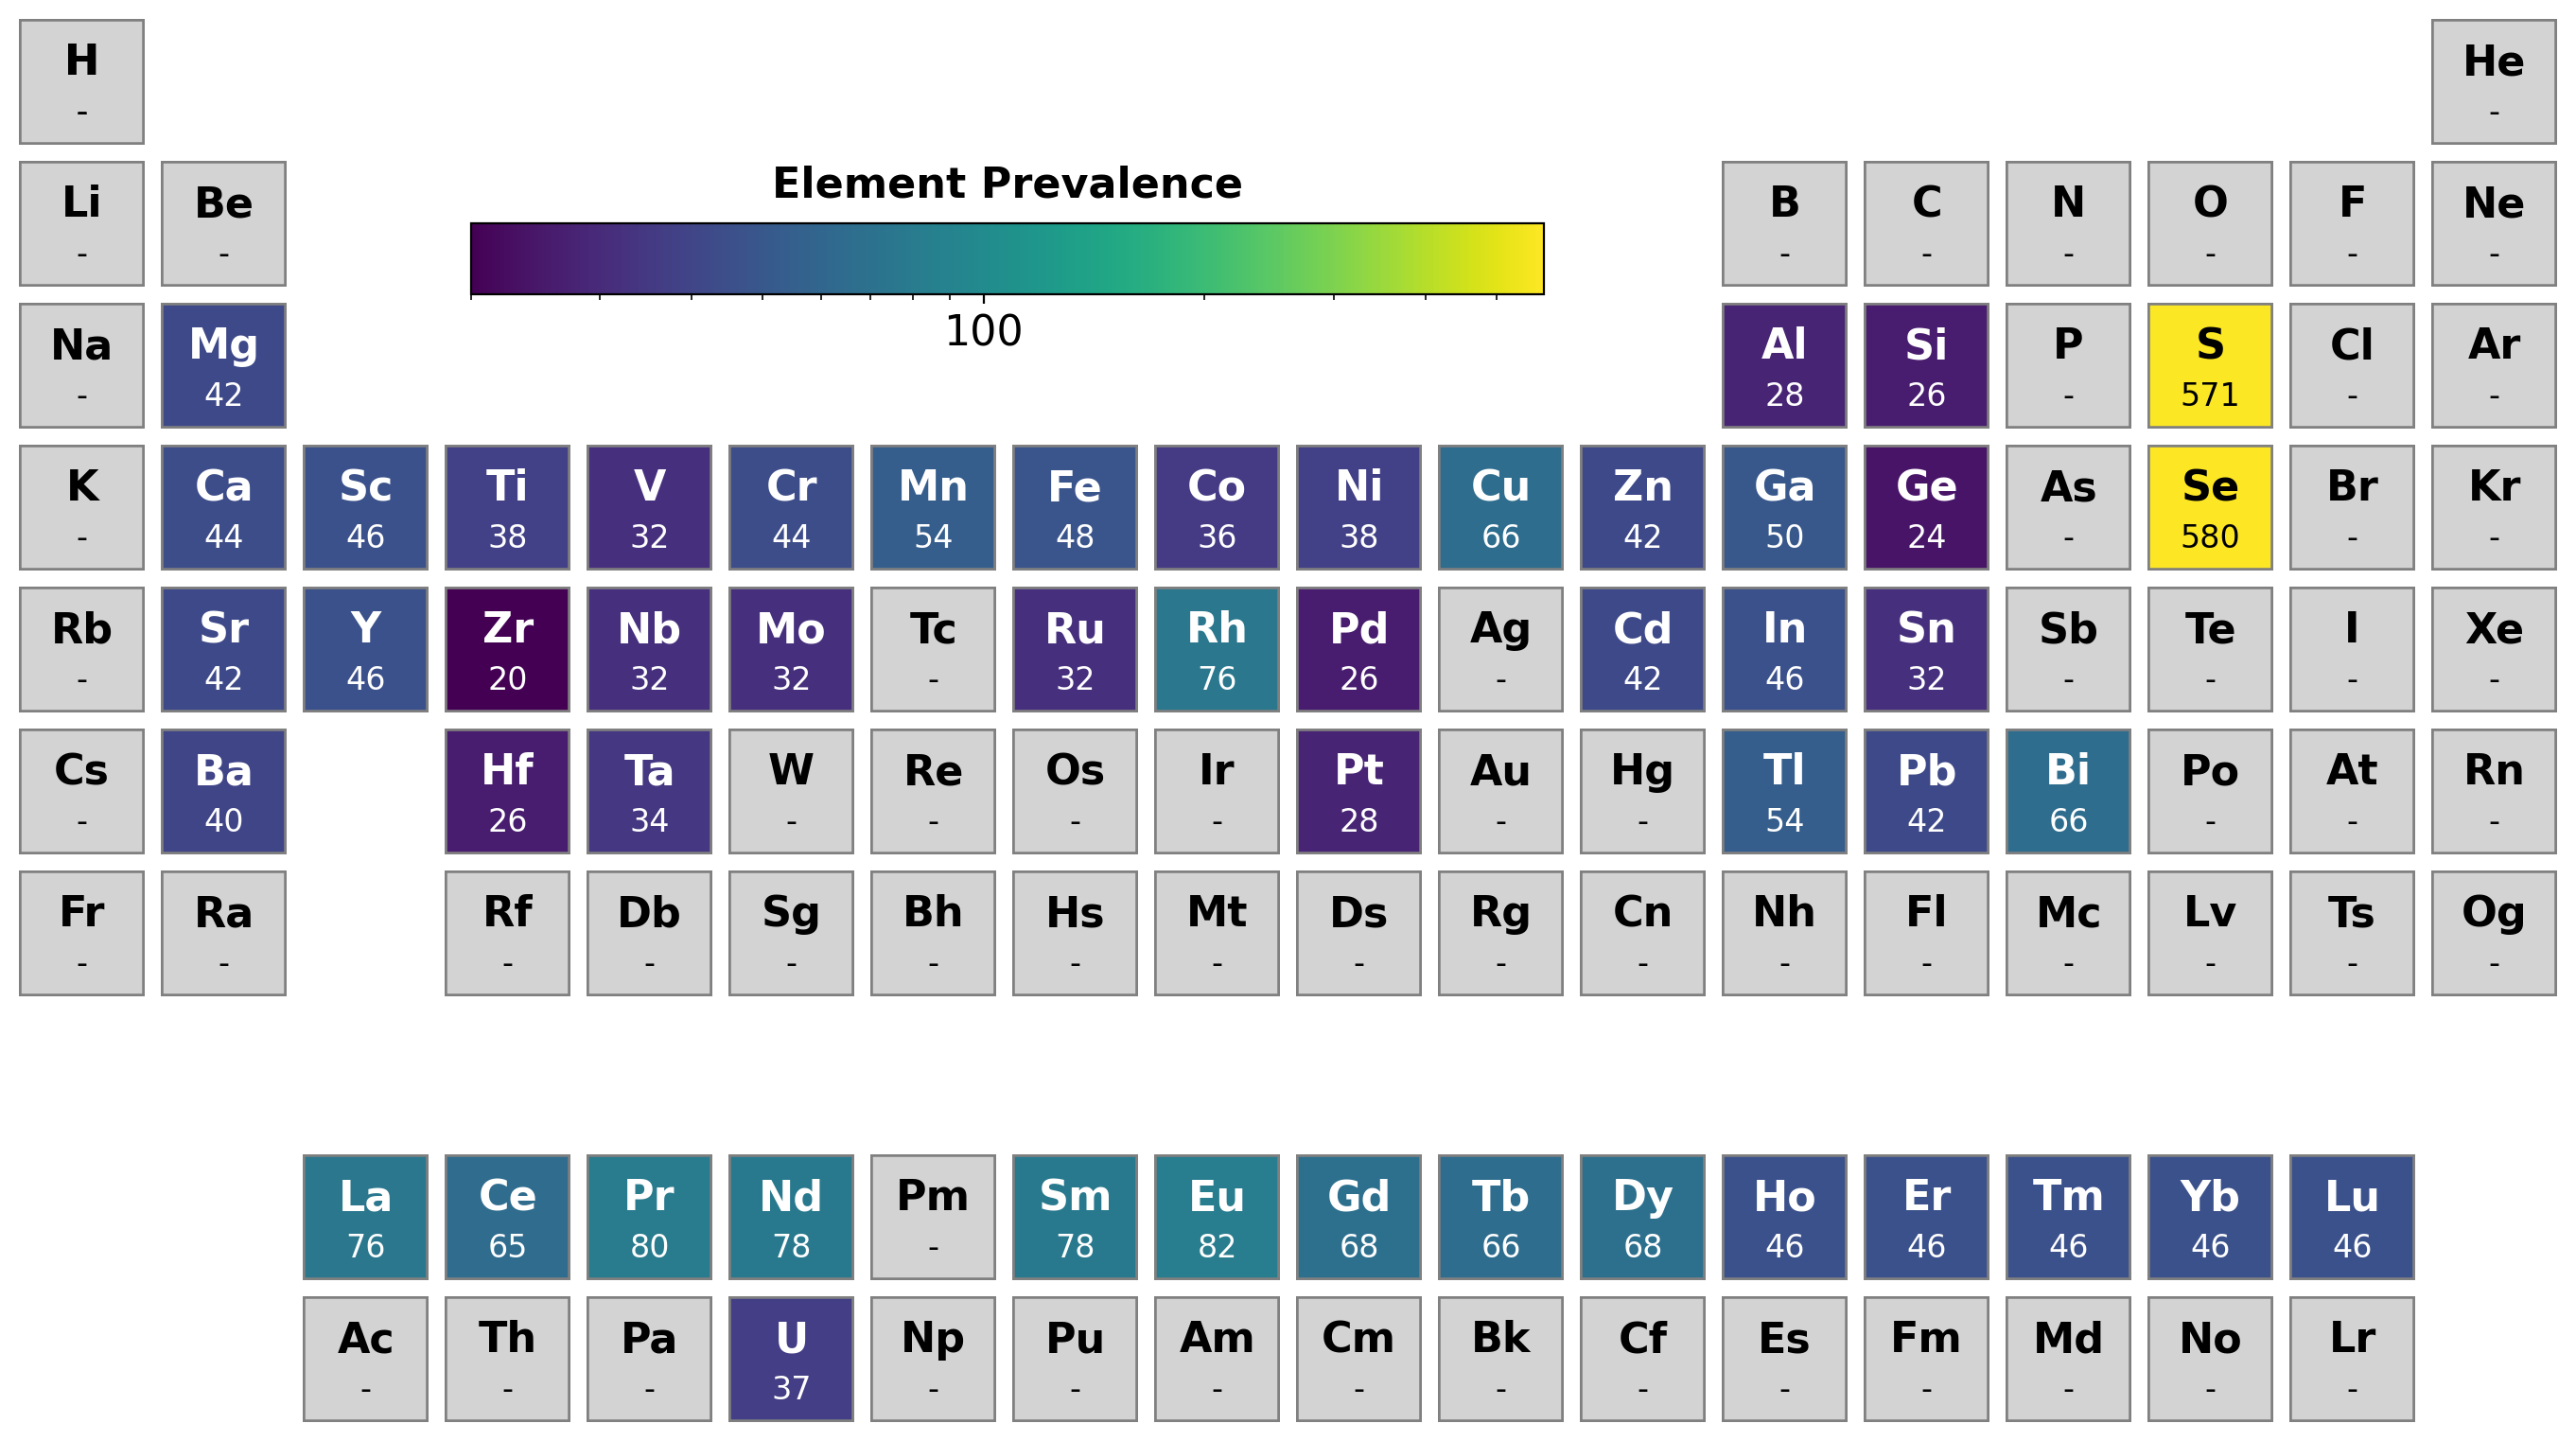

According to t_sisso_210, 10 (0.859106529209622%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


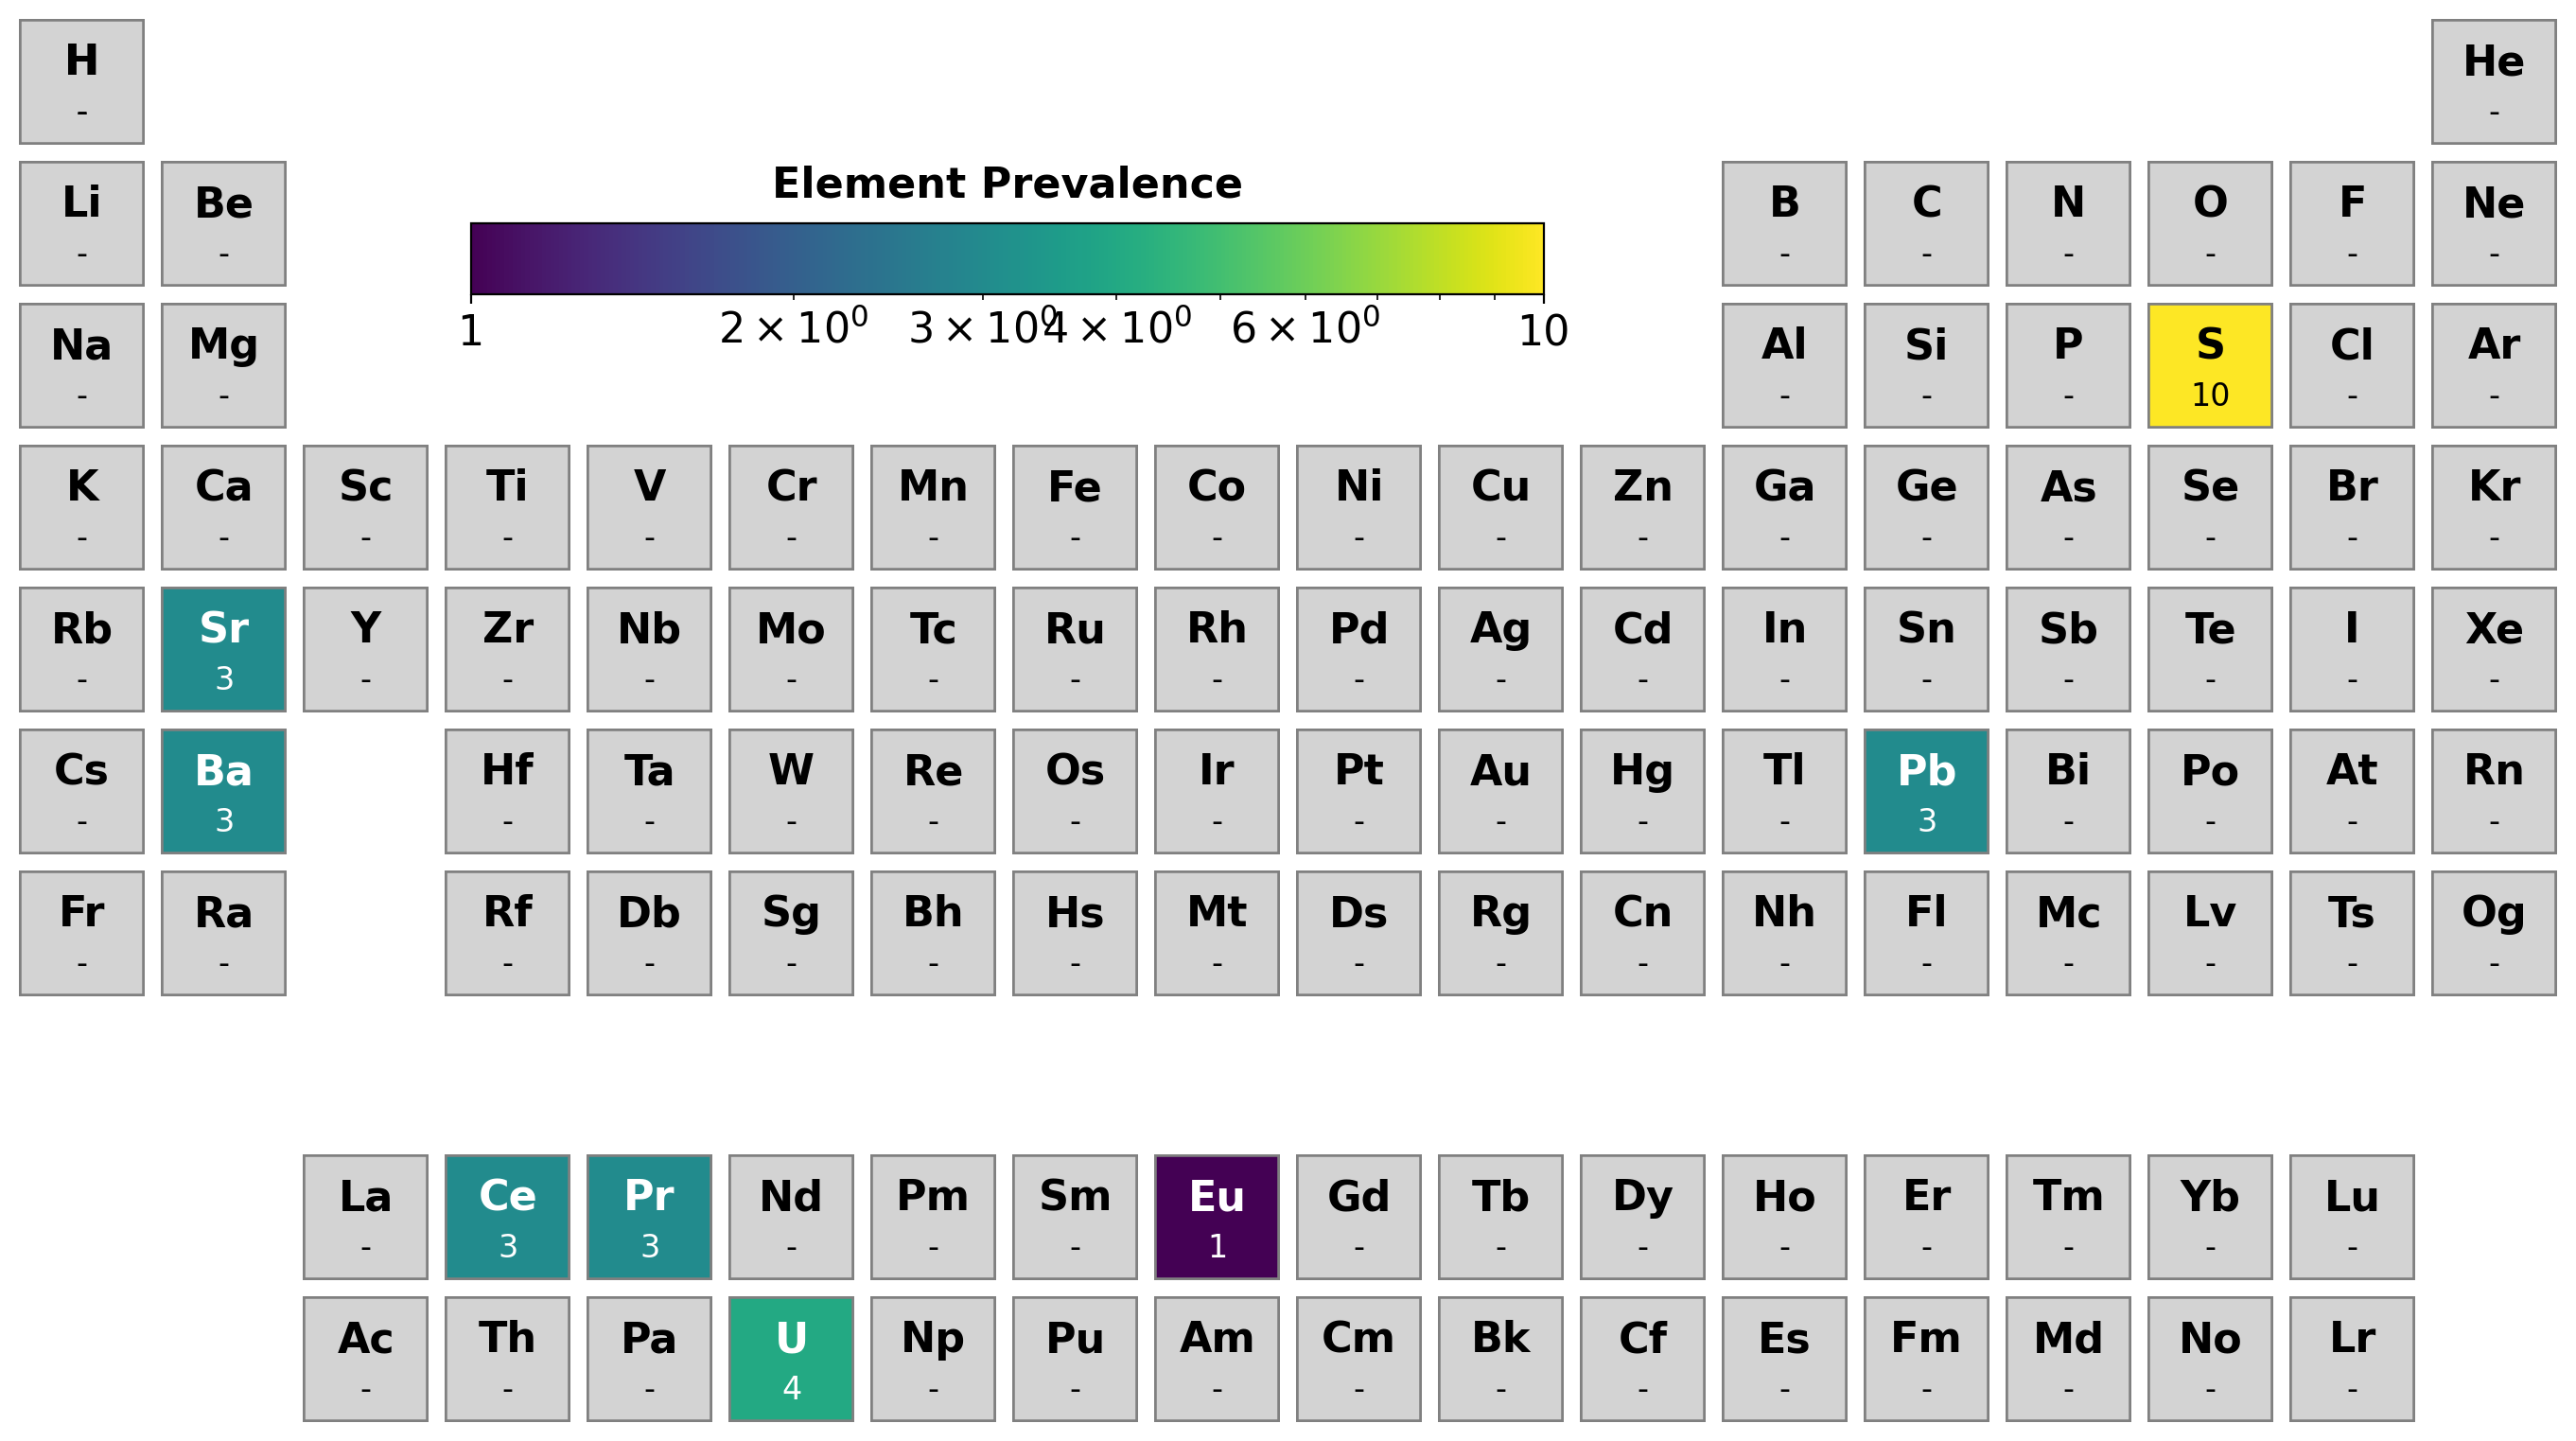

According to t_sisso_55, 8 (0.6872852233676976%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbCeS3', 'PbUS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


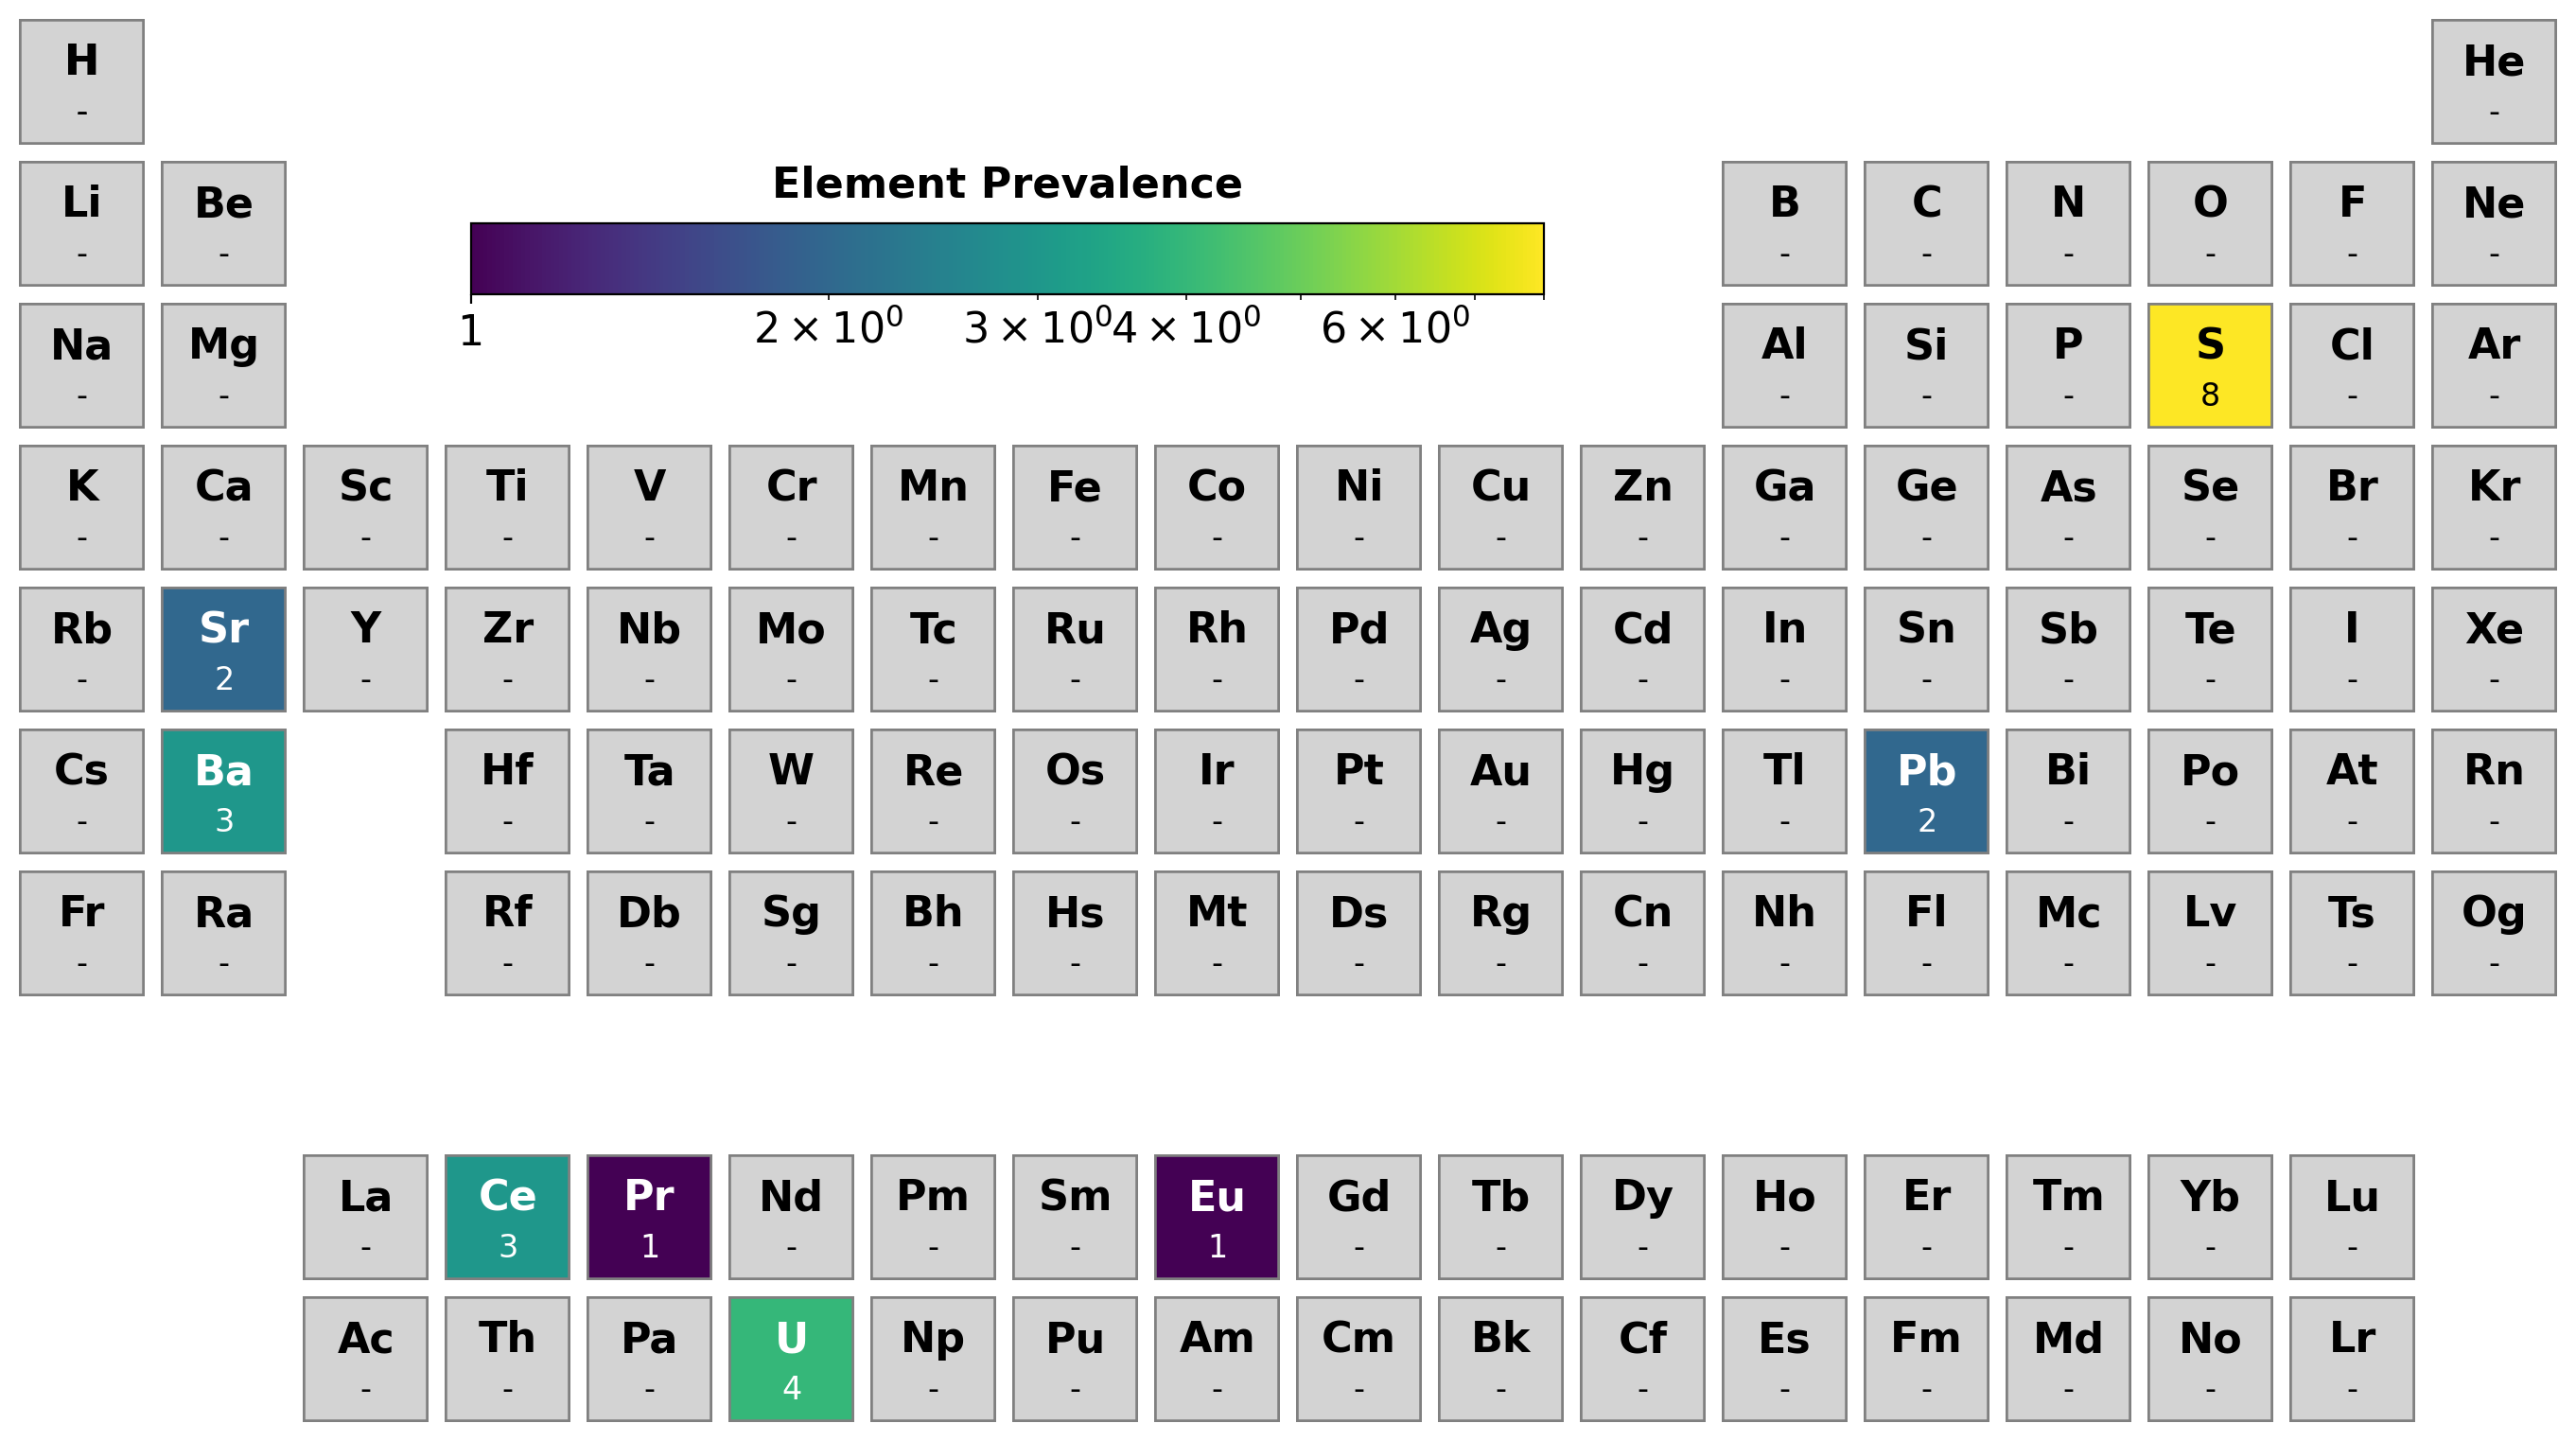

According to t_sisso_212, 1112 (95.53264604810997%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrSe3', 'BaCeSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZ

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


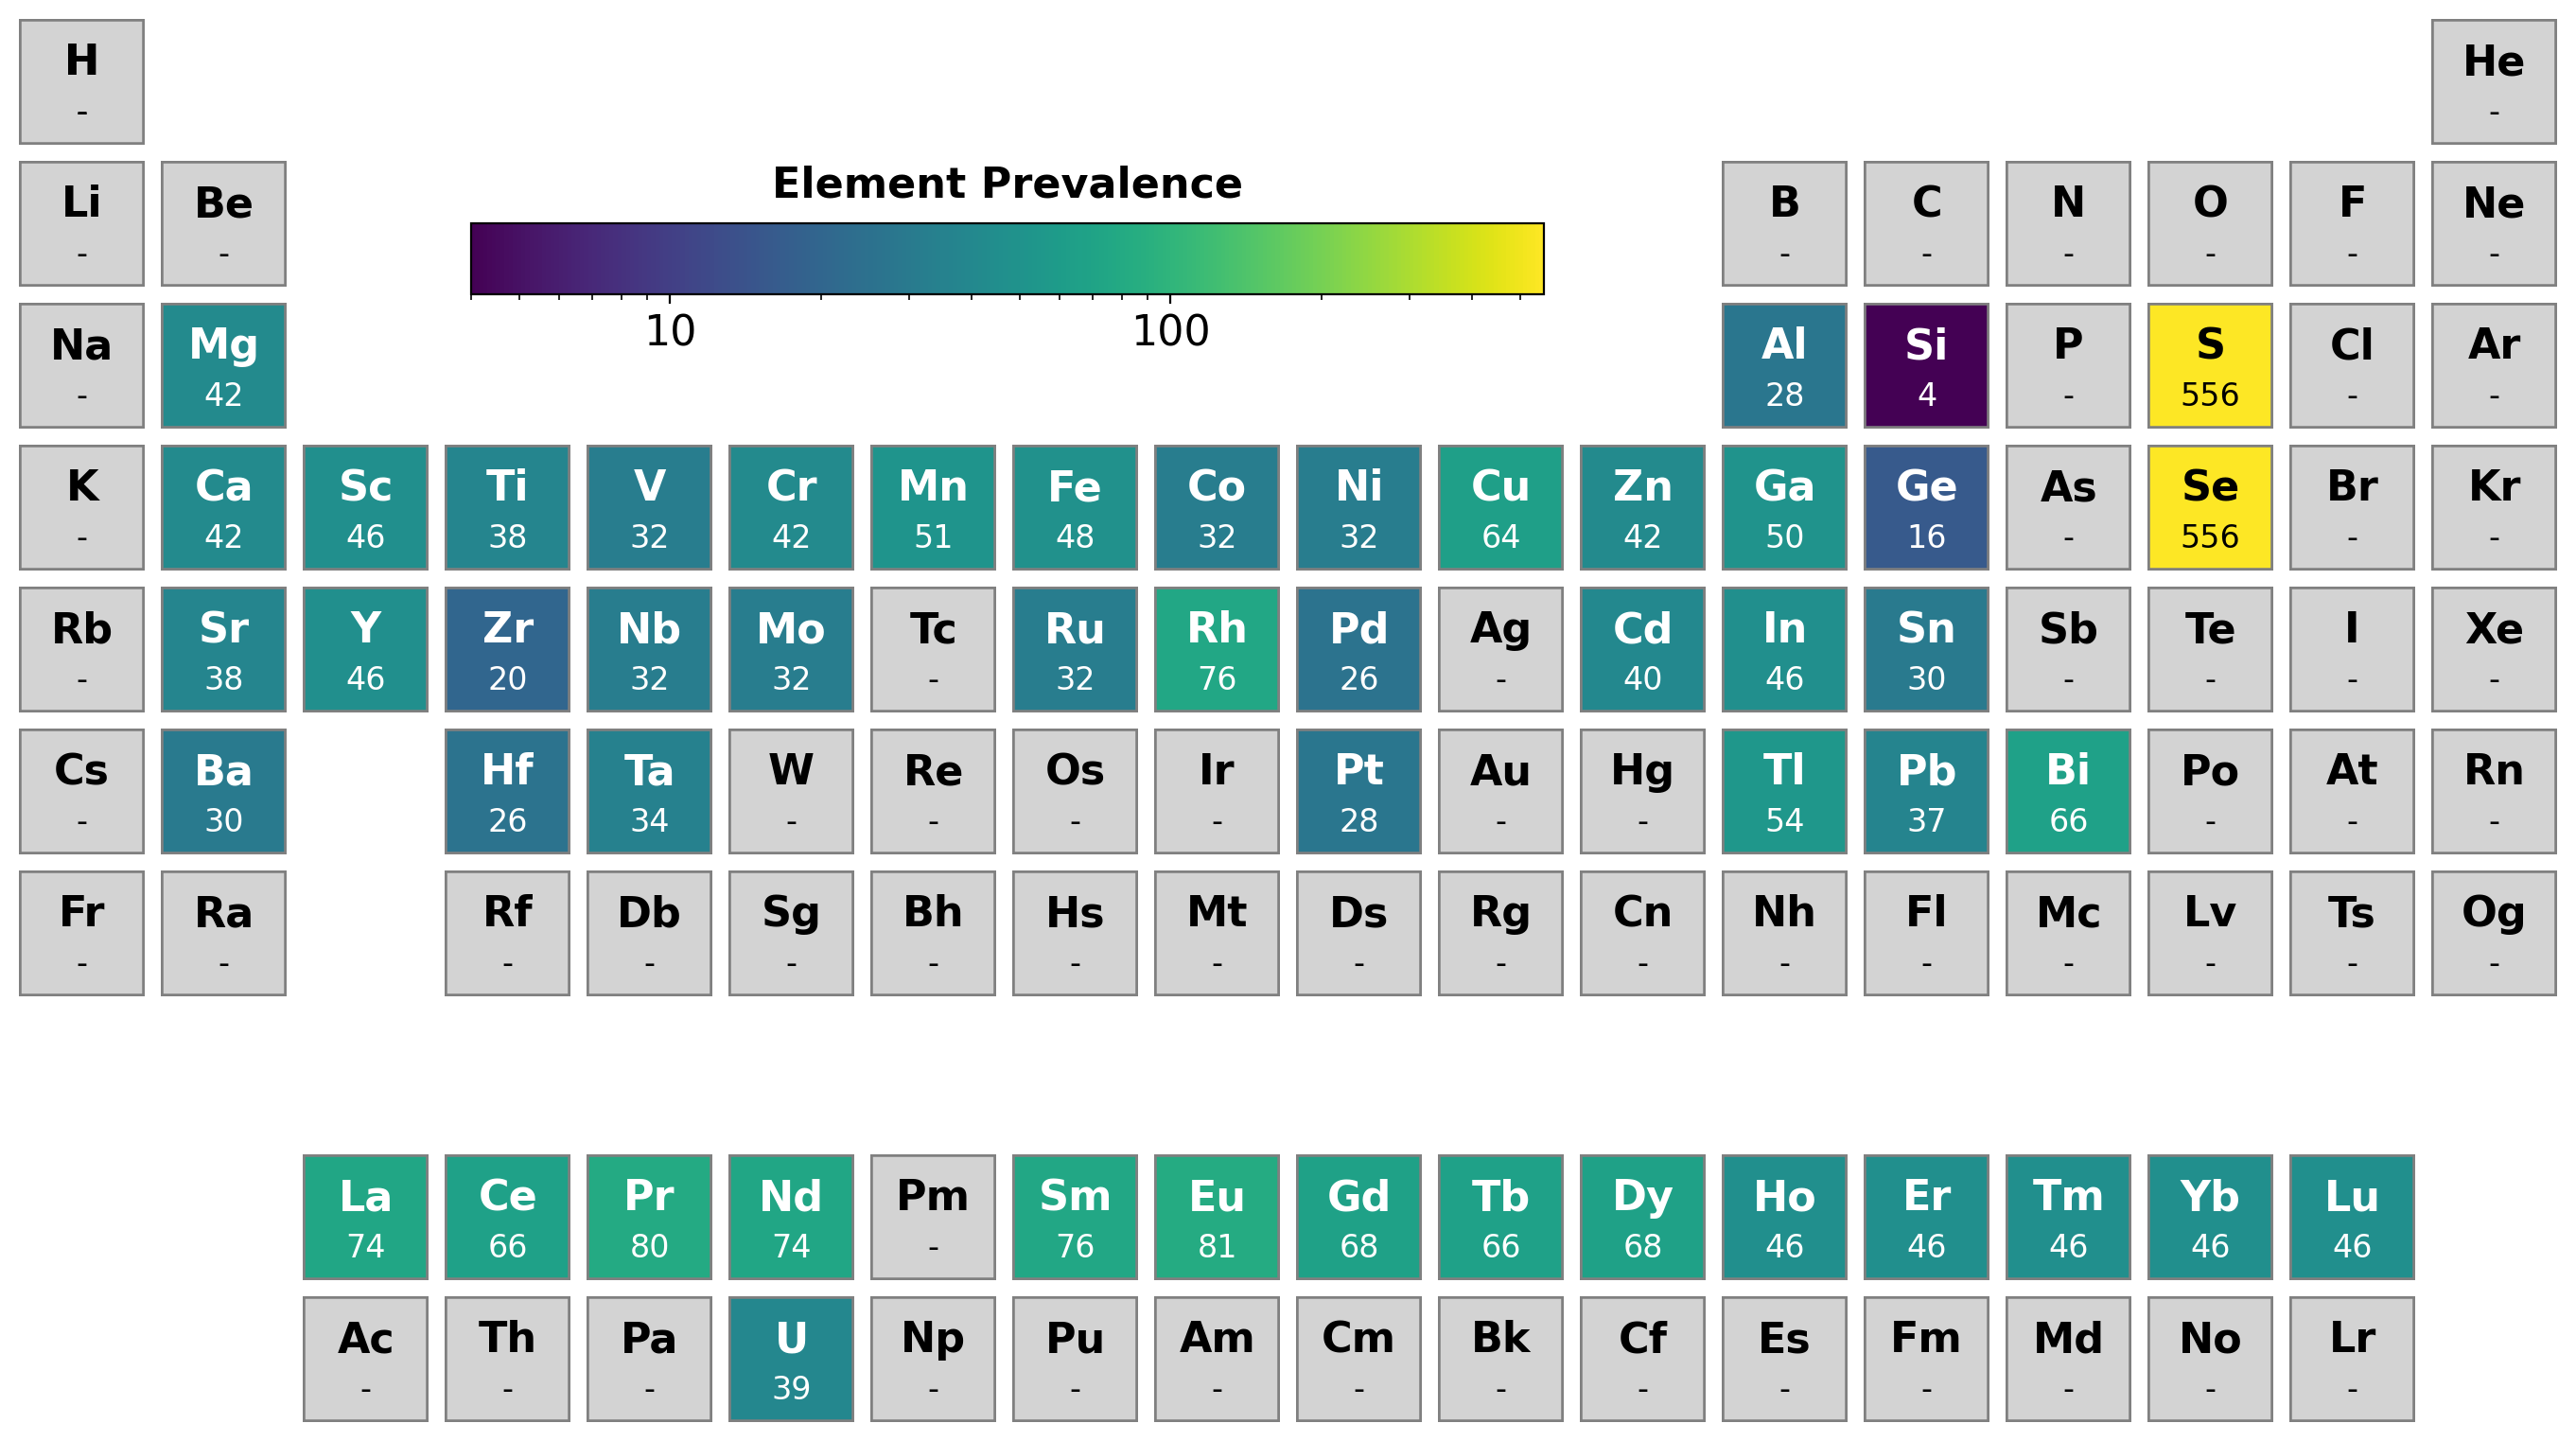

According to t_sisso_54, 8 (0.6872852233676976%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbCeS3', 'PbUS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


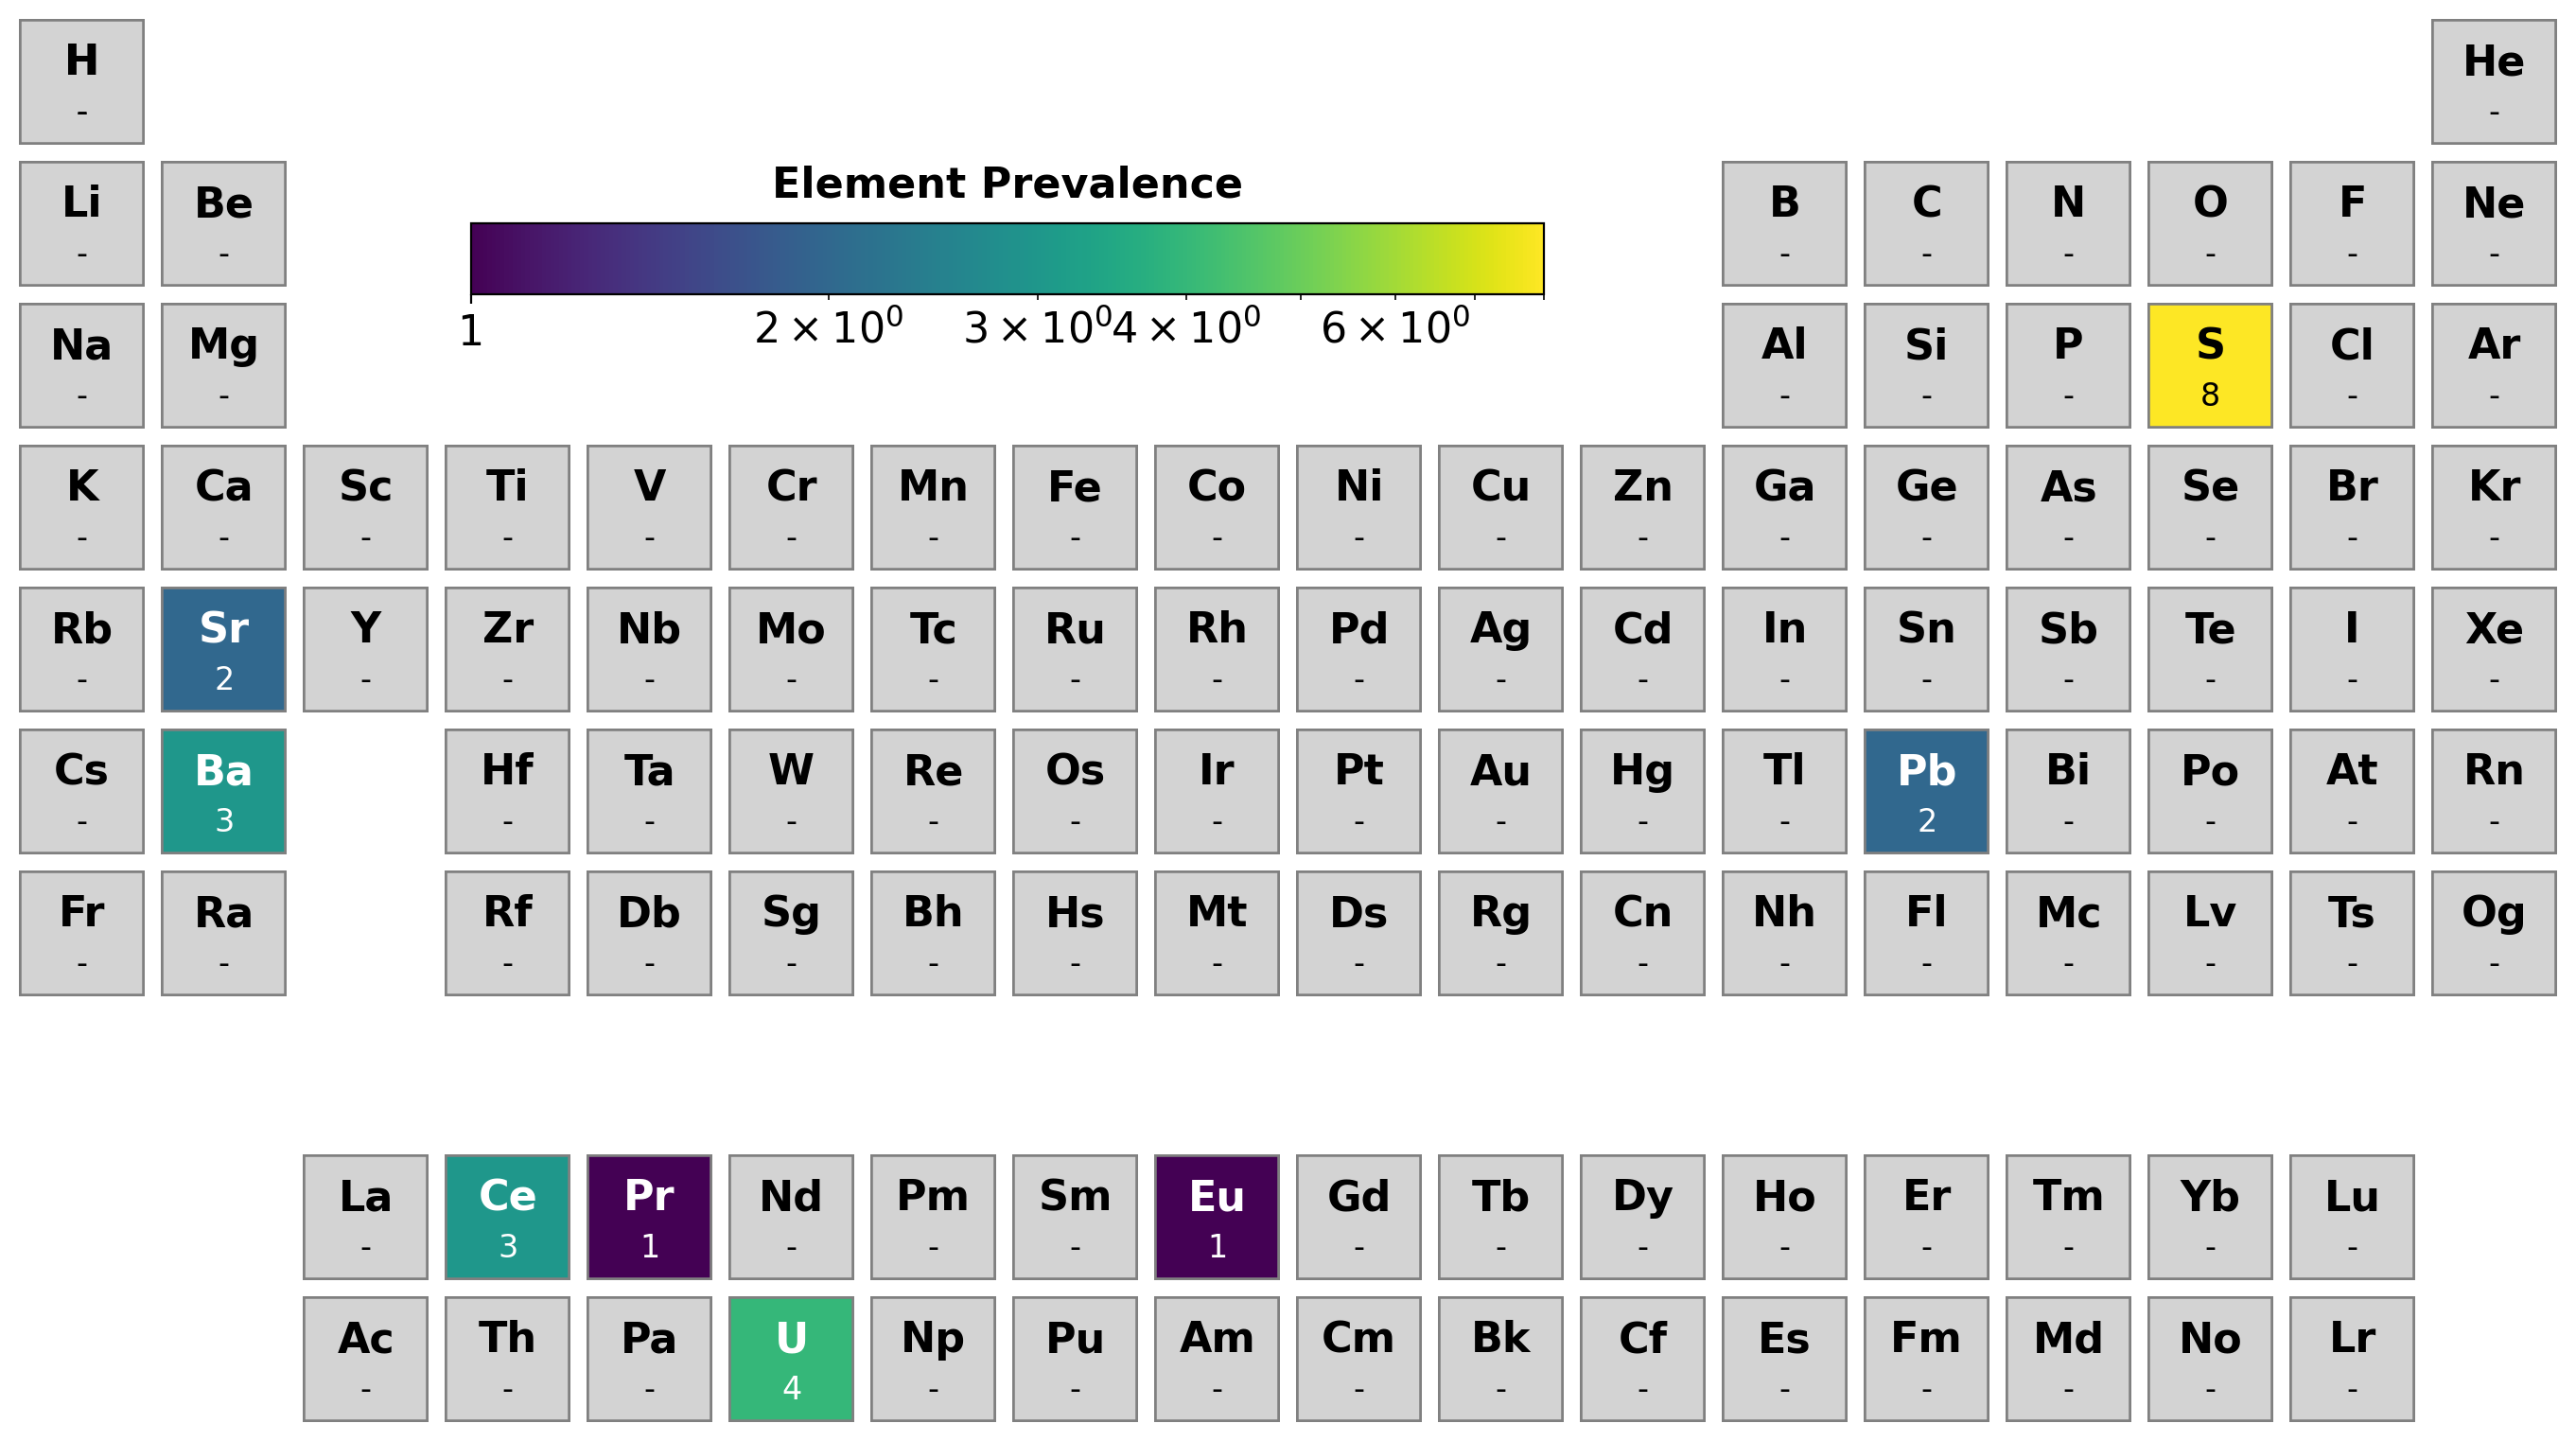

According to t_sisso_63, 1099 (94.41580756013745%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'Eu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


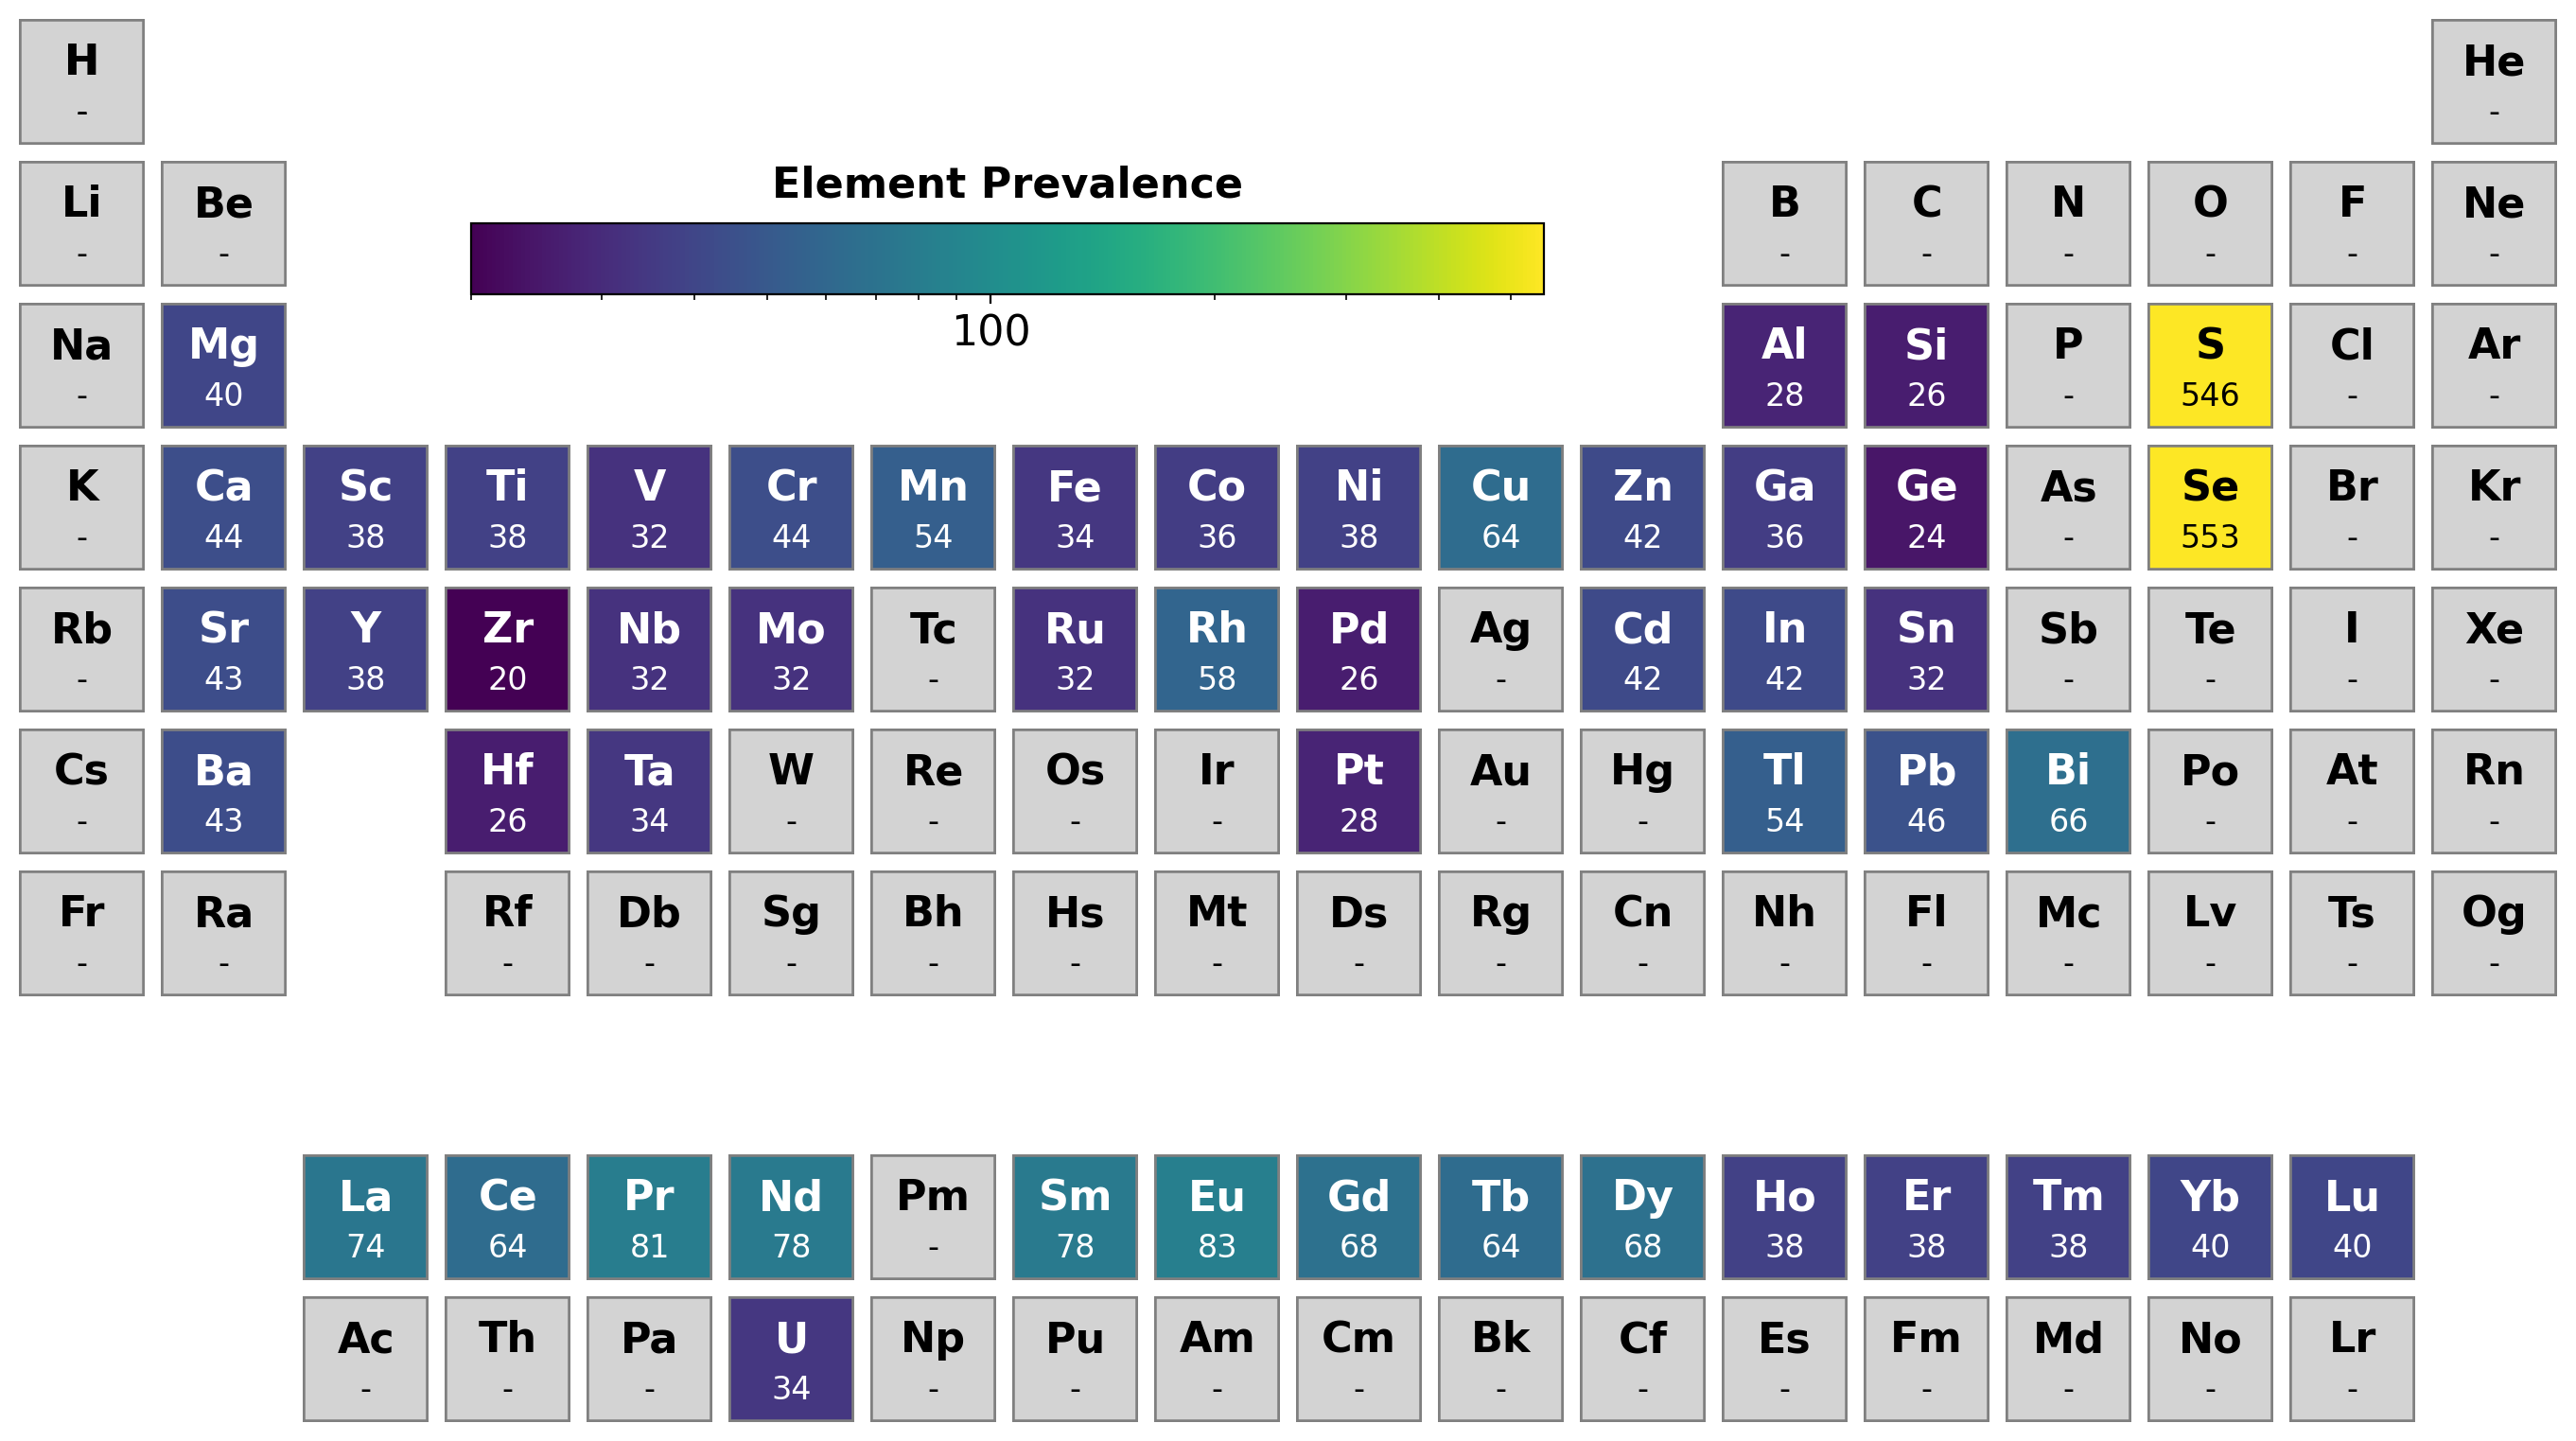

According to t_sisso_39, 1151 (98.8831615120275%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTi

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


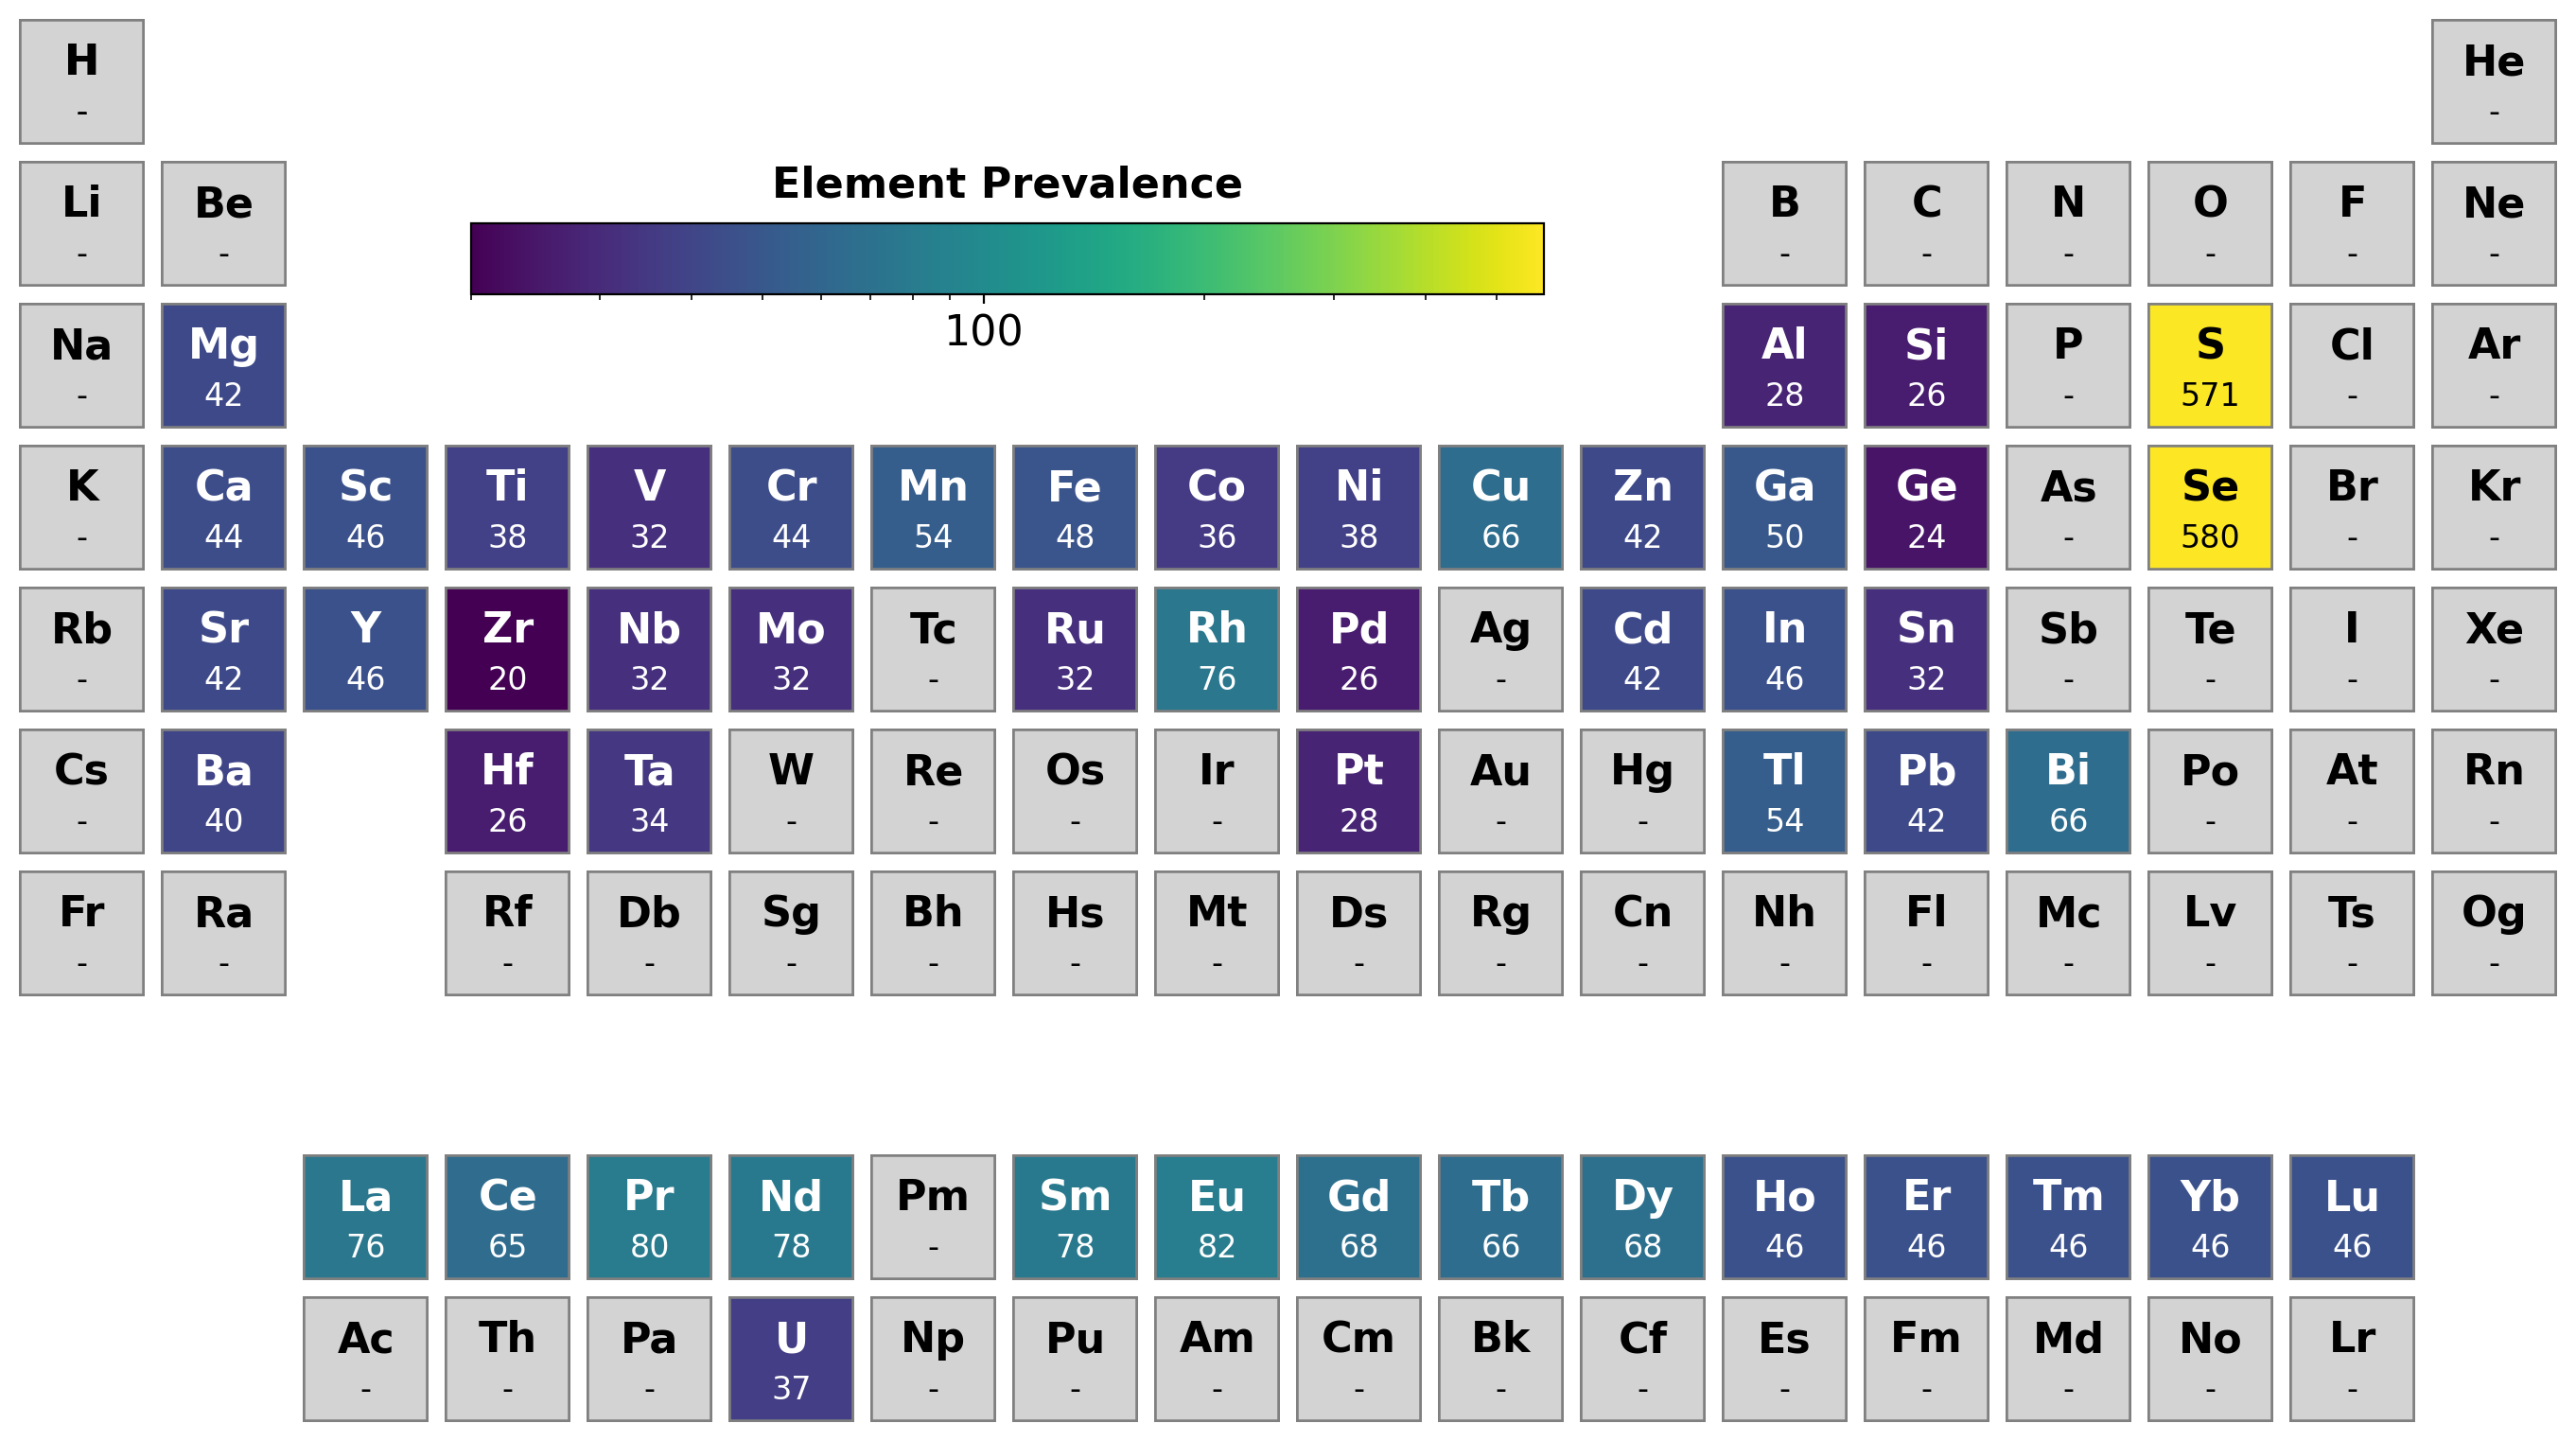

According to t_sisso_44, 8 (0.6872852233676976%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbCeS3', 'PbUS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


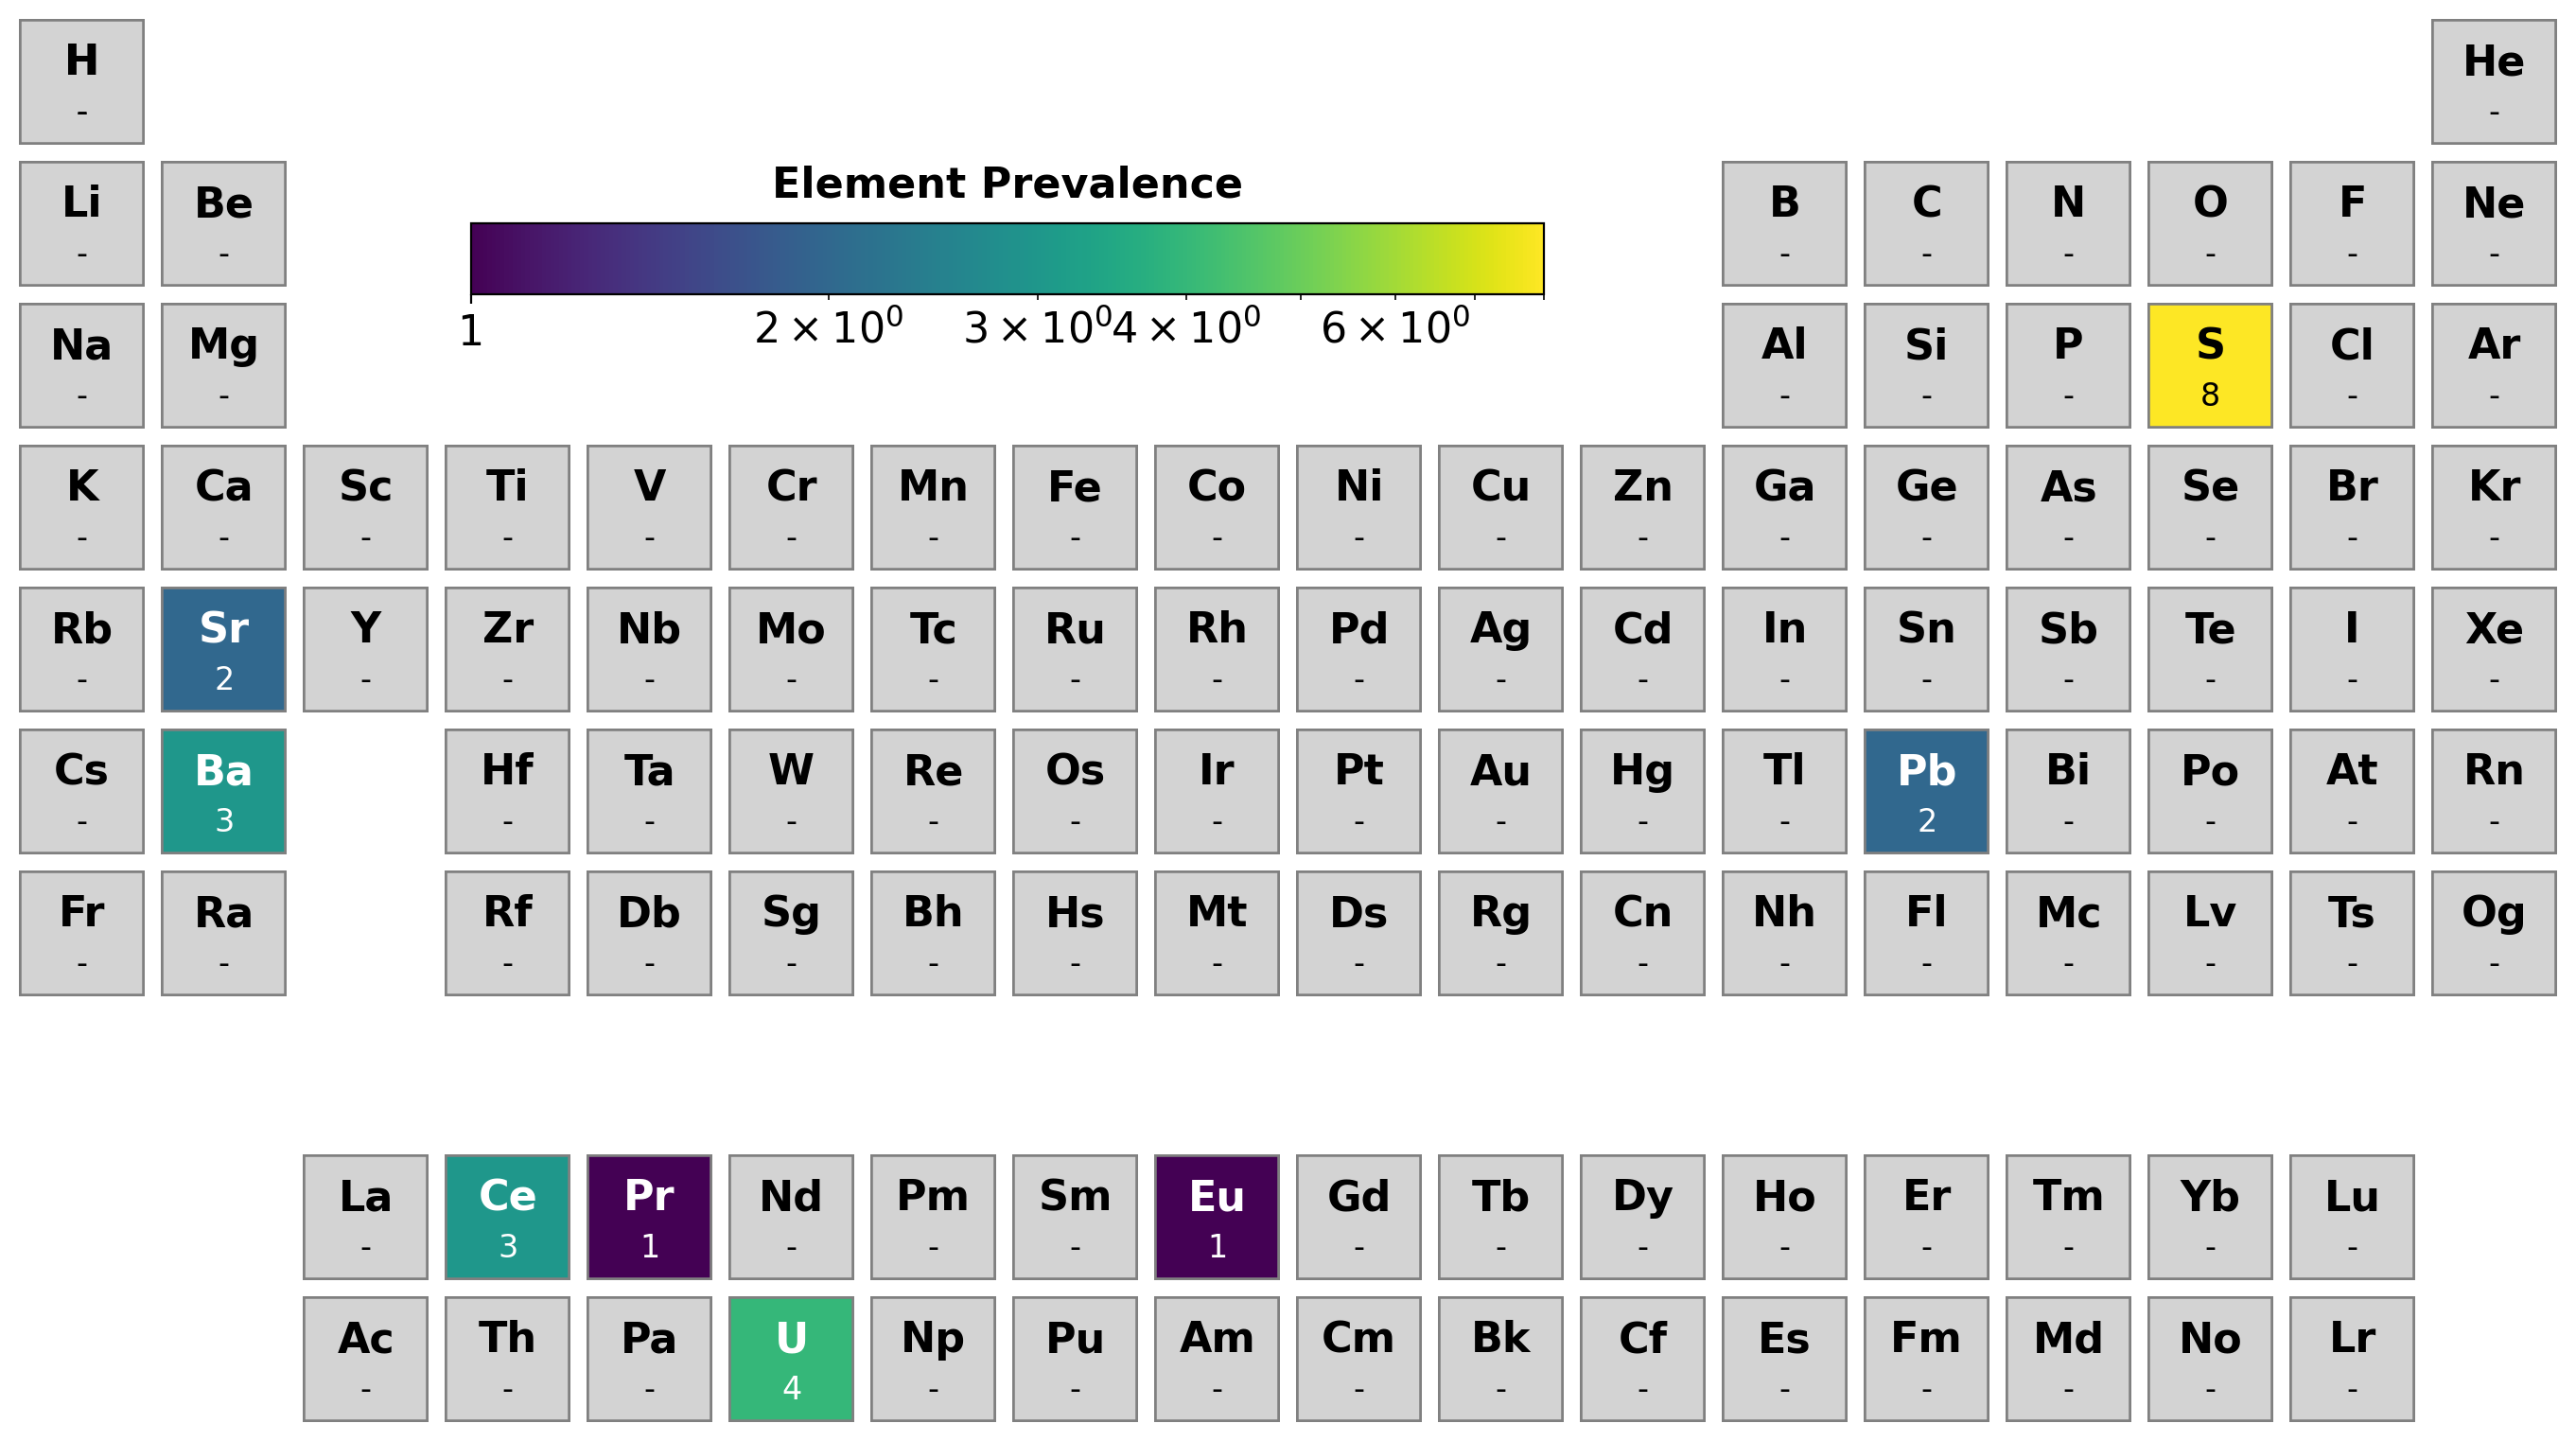

According to t_sisso_181, 361 (31.013745704467354%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaPrS3', 'BaPrSe3', 'BaCeS3', 'BaCeSe3', 'BaUS3', 'BaUSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuPtS3', 'EuPtSe3', 'EuUS3', 'EuUSe3', 'EuNiS3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuFeS3', 'EuFeSe3', 'EuInS3', 'EuInSe3', 'EuMnS3', 'PbPrS3', 'PbPrSe3', 'PbCeS3', 'PbCeSe3', 'PbUS3', 'PbUSe3', 'SrSnS3', 'SrSnSe3', 'SrPrS3', 'SrPrSe3', 'SrCeS3', 'SrCeSe3', 'SrTbS3', 'SrUS3', 'SrUSe3', 'CaSnS3', 'CaSnSe3', 'CaRhS3', 'CaRhSe3', 'CaRuS3', 'CaRuSe3', 'CaMoS3', 'CaMoSe3', 'CaNbS3', 'CaHfS3', 'CaZrS3', 'CaZrSe3', 'CaTbS3', 'CaPtS3', 'CaPtSe3', 'CaPdS3', 'CaPdSe3', 'SnRhS3', 'SnRhSe3', 'SnTaS3', 'SnTaSe3', 'CdRhS3', 'CdRhSe3', 'CdRuS3', 'CdRuSe3', 'CdMoS3', 'CdMoSe3', 'CdTaS3', 'CdNbS3', 'CdNbSe3', 'CdHfS3', 'CdZrS3', 'CdZrSe3', 'CdTbS3', 'CdPtS3', 'CdPtSe3', 'CdPdS3', '

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


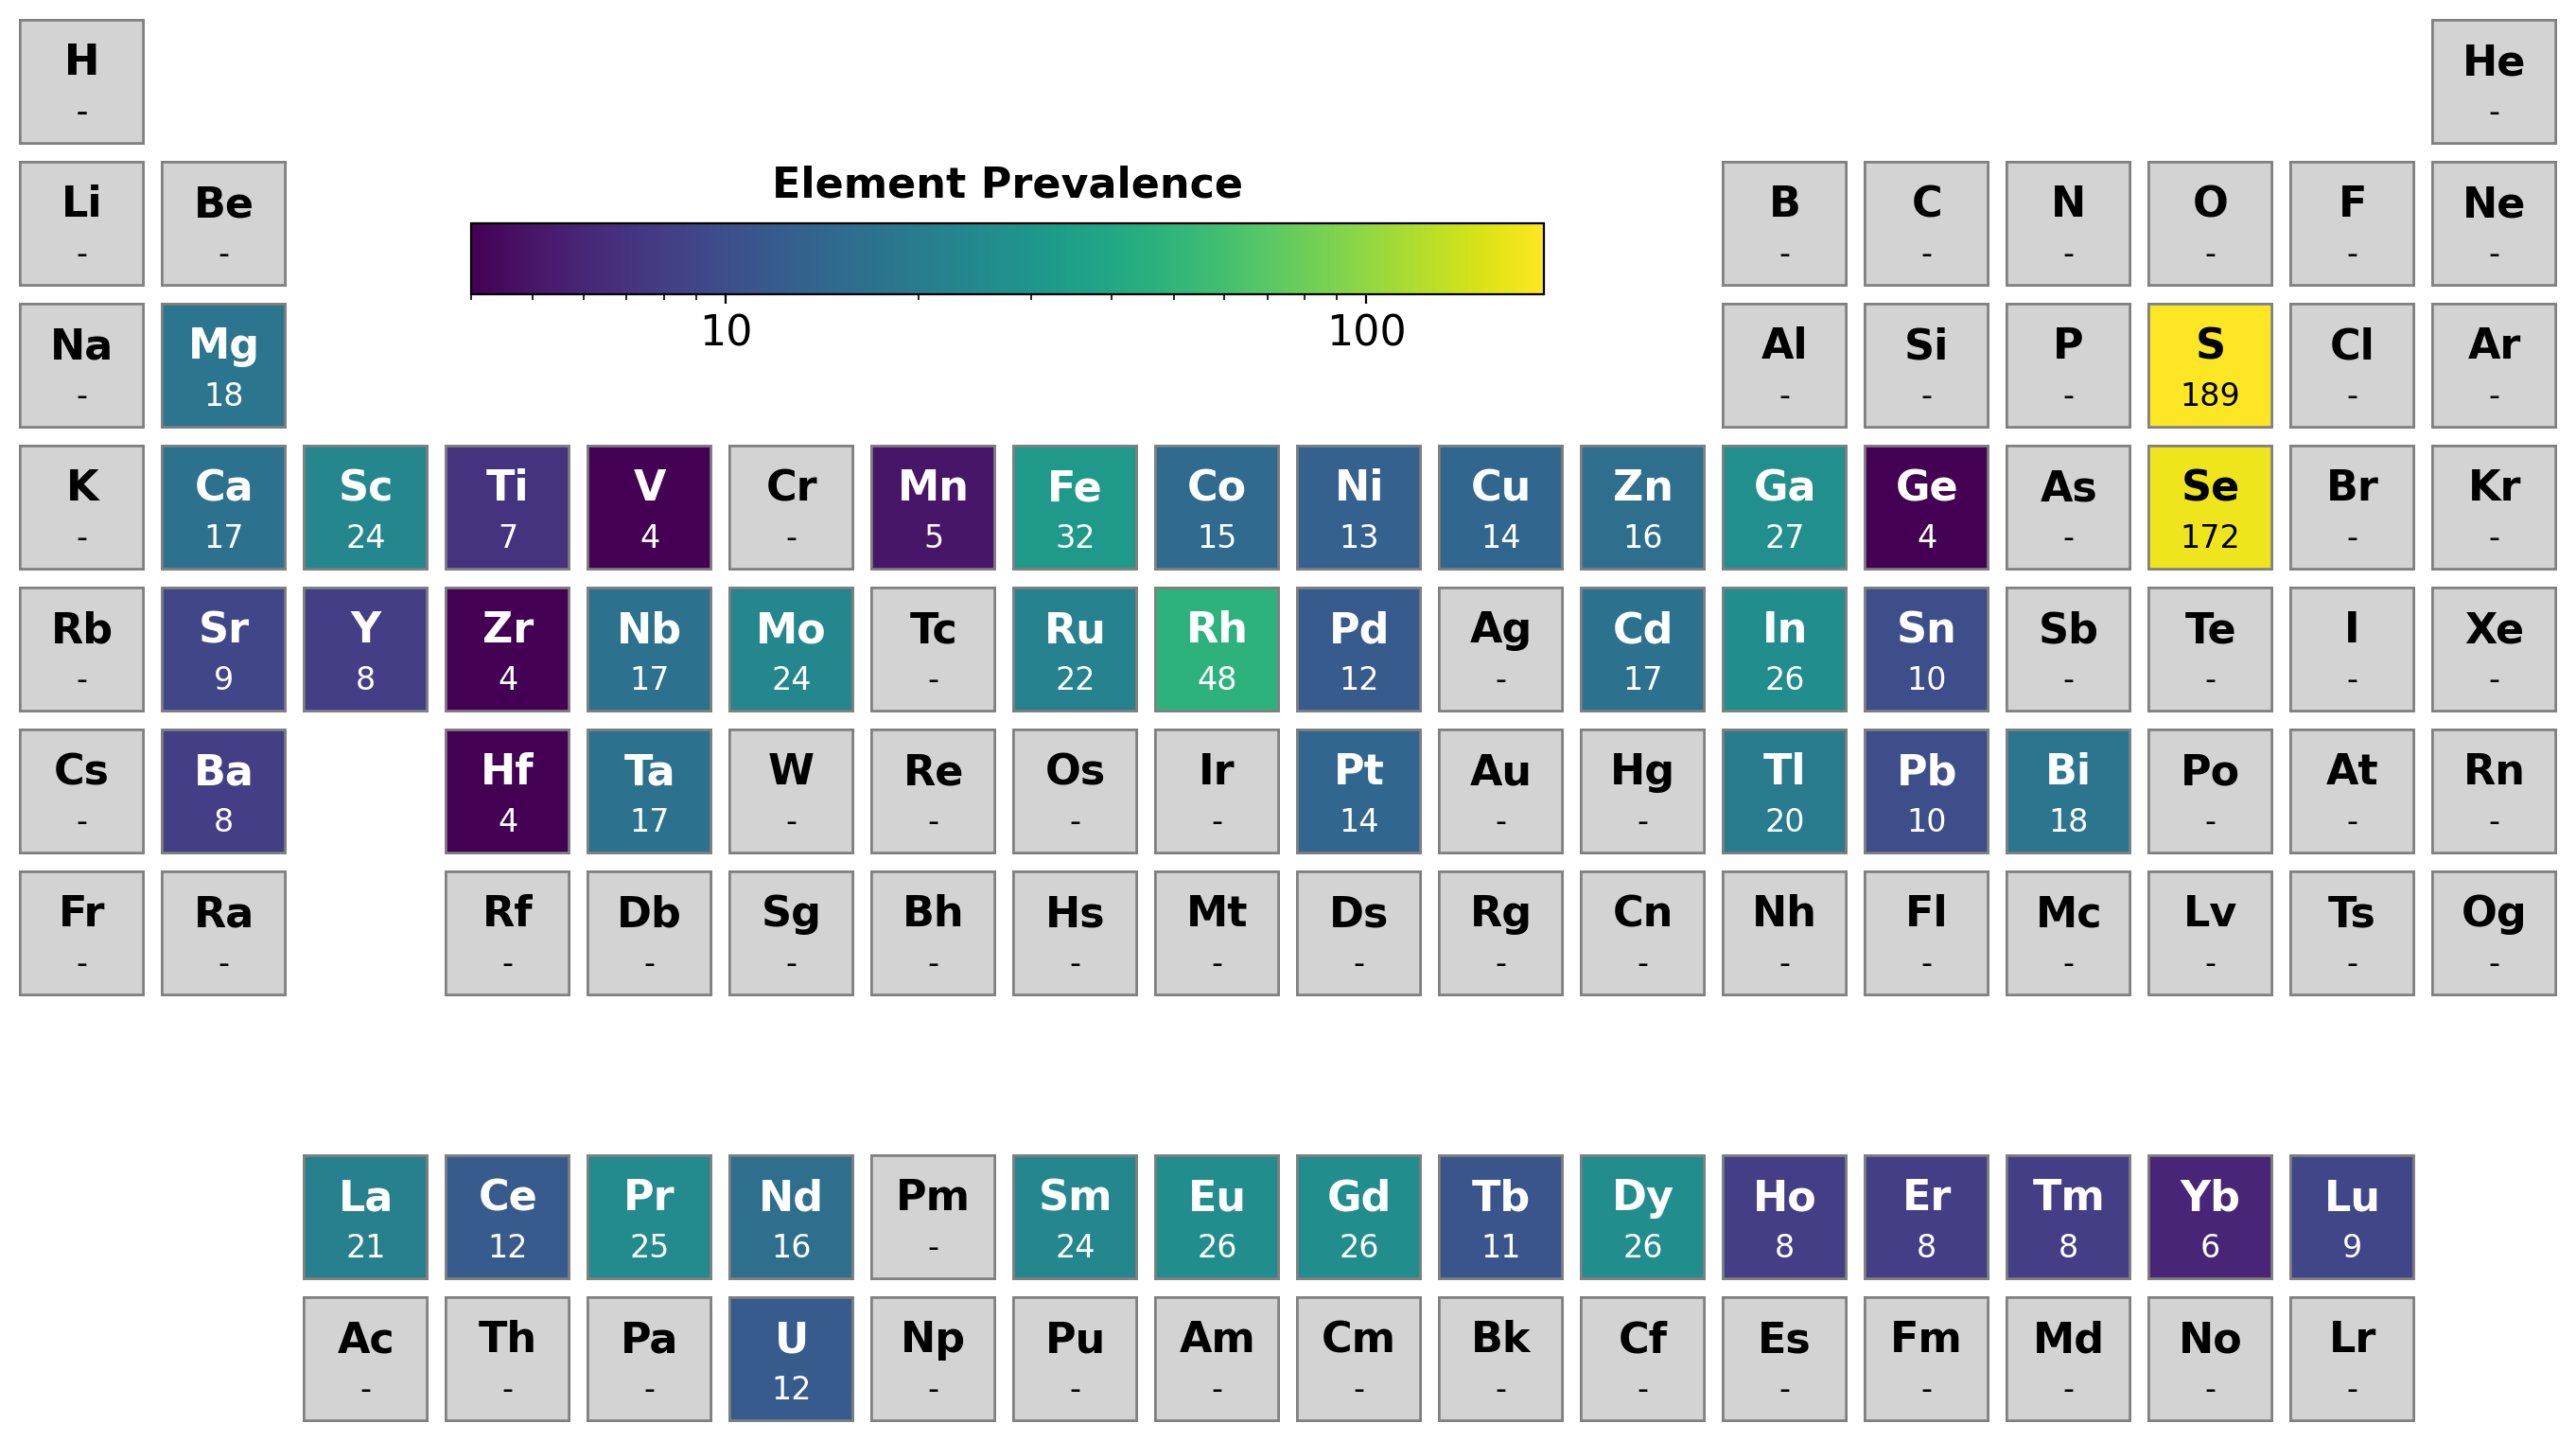

In [22]:
from tf_chpvk_pv.plots import graph_periodic_table

for t in tolerance_factor_dict_global.keys():
    if t not in ['t', 't_jess']:
        stable_candidates_t_sisso, df_out = check_stable_compositions(t, tolerance_factor_dict_path=new_tolerance_dict_path)
        graph_periodic_table(stable_candidates_t_sisso, t=t)

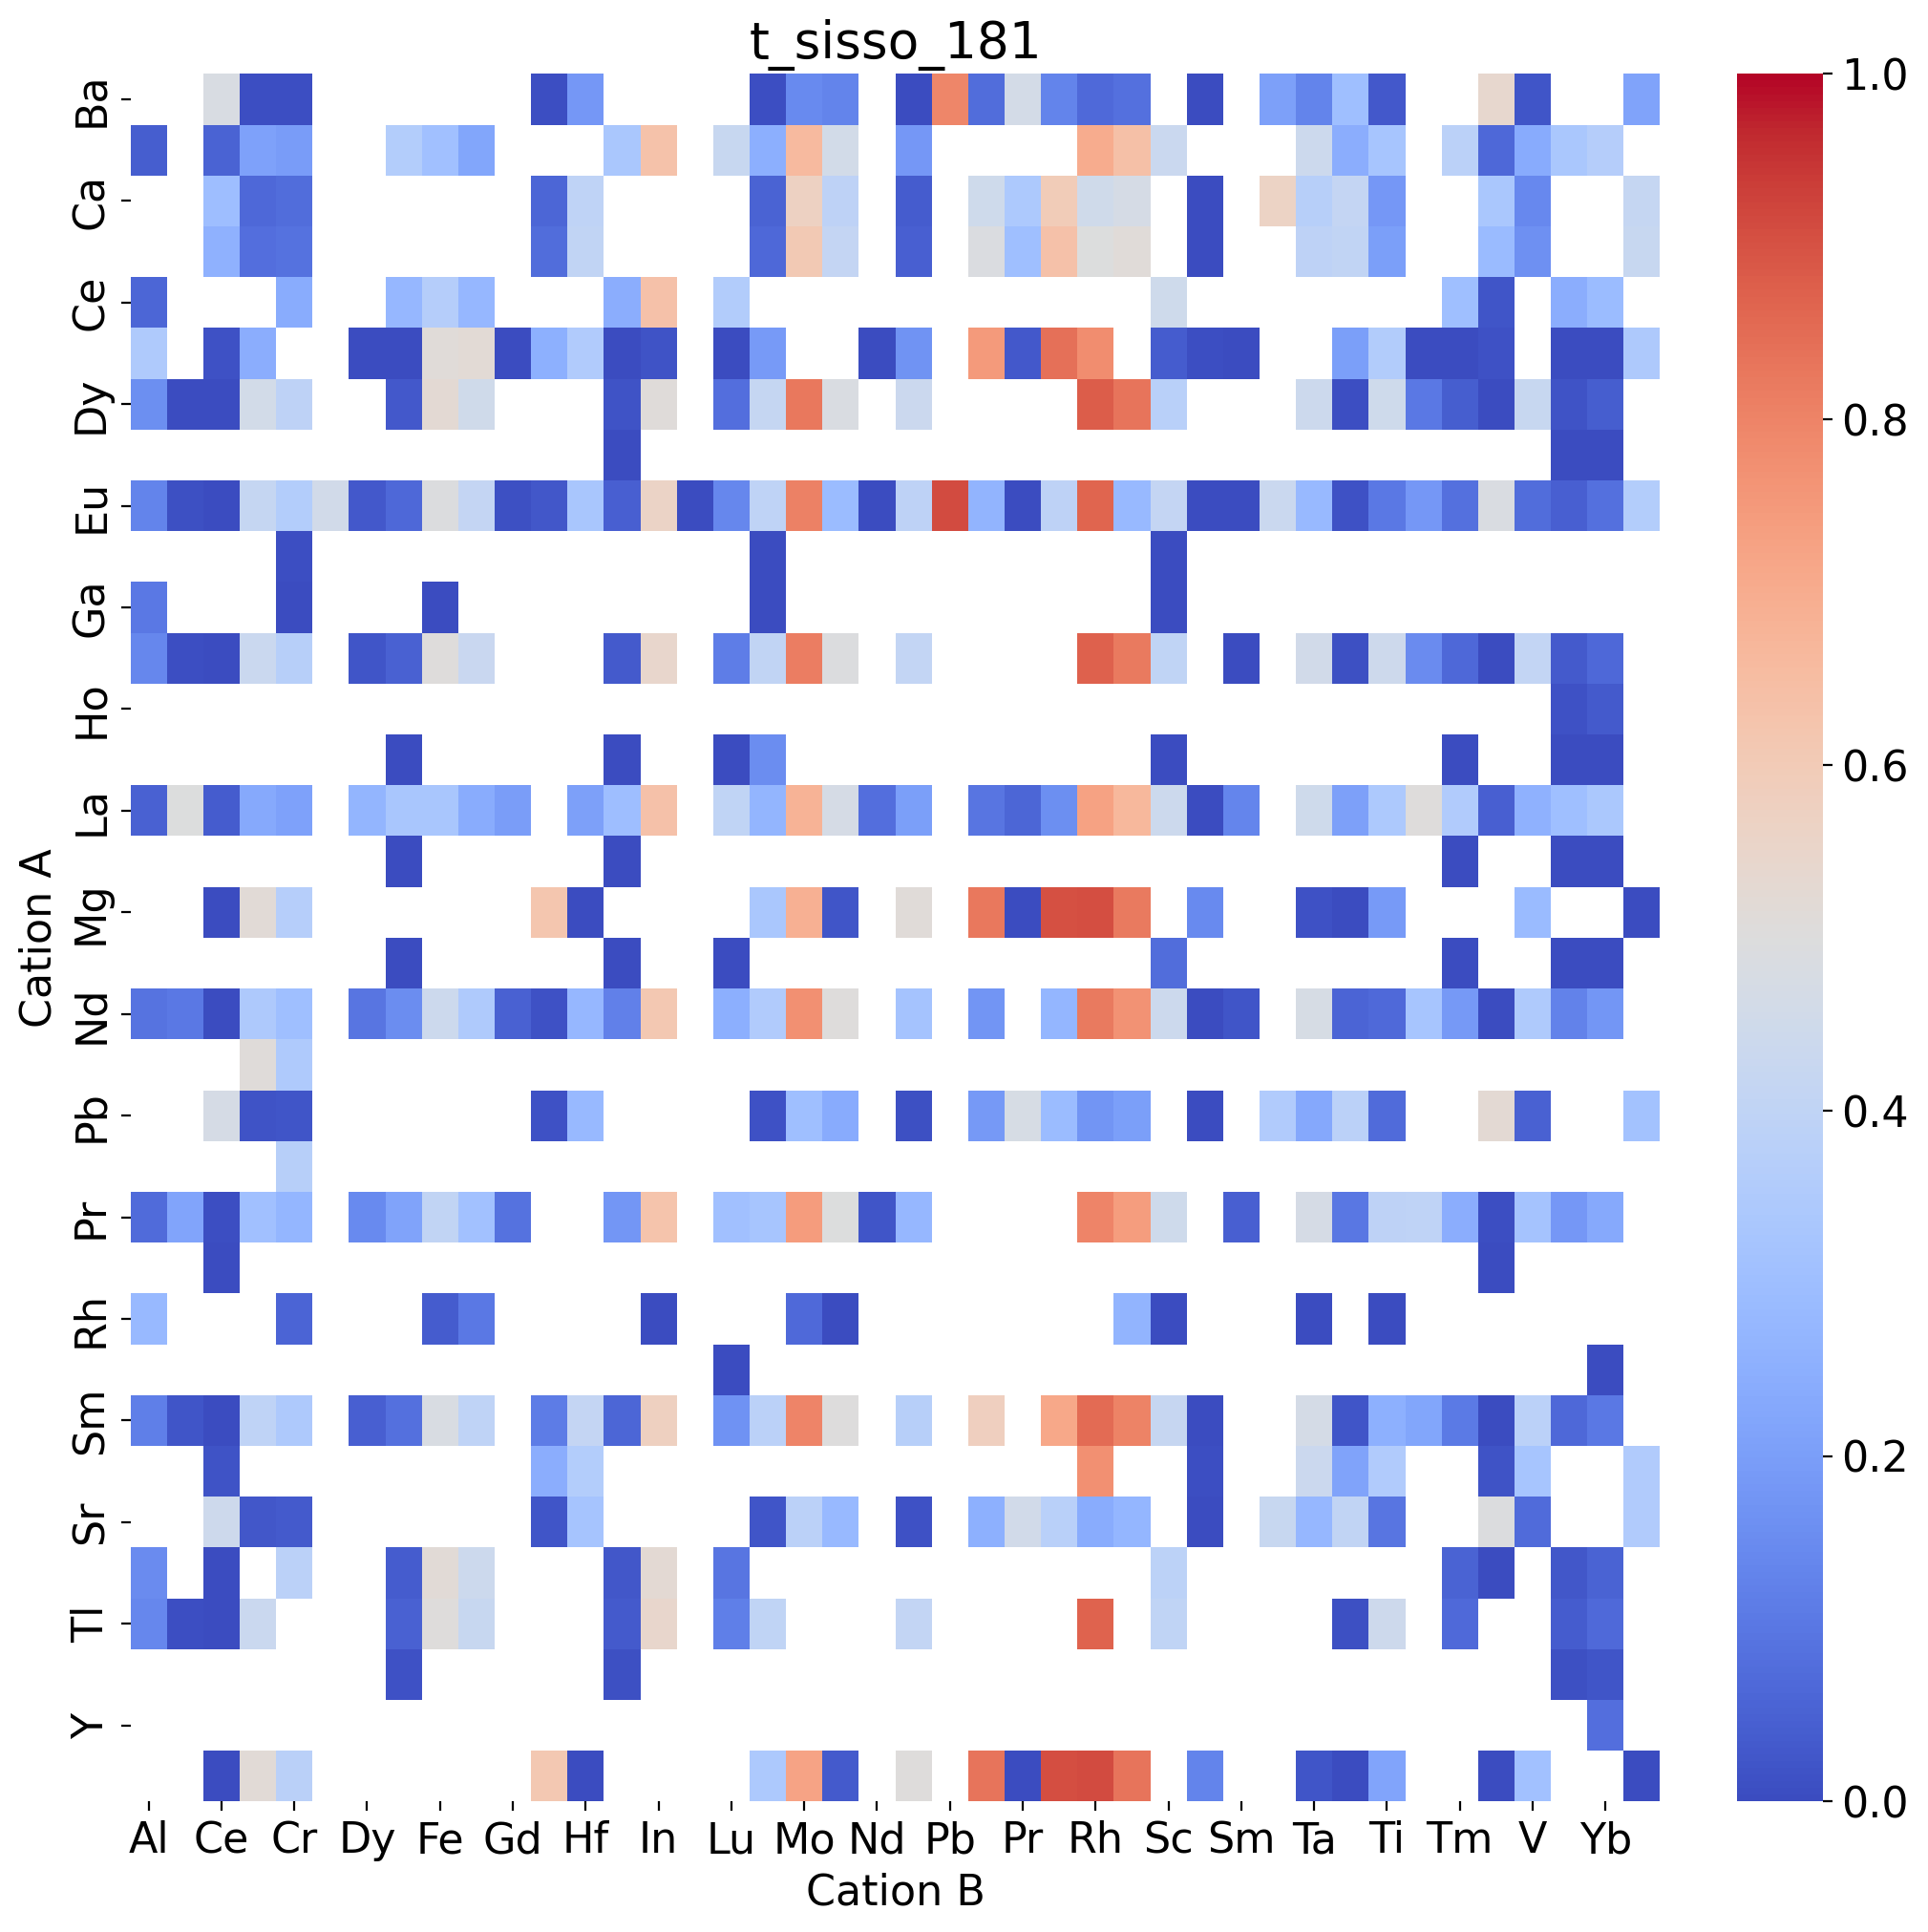

In [32]:
def plot_matrix(df_out, idx=None, anion='S',
                clf2_platt_path=INTERIM_DATA_DIR / 'Ch_clf2_platt.pkl',):

    import seaborn as sns
    import matplotlib.pyplot as plt
    from tf_chpvk_pv.config import FIGURES_DIR

    clf2_platt = pickle.load(open(clf2_platt_path, 'rb'))

    t = 't_sisso_'

    column_p = 'p_t_sisso_'

    if idx is not None:
        column_p = 'p_t_sisso_' + str(idx)
        t = 't_sisso_' + str(idx)
    else:
        column_p = 'p_t_sisso'
        t = 't_sisso'

    x_t = df_out[t].to_numpy()

    if column_p not in df_out.columns:
        clf2 = clf2_platt[t]
        df_out[column_p] = clf2.predict_proba(x_t.reshape(-1, 1))[:, 1]

    df_out = df_out[df_out['X'] == anion]
    #df_out = df_out[['rA', 'rB', 't_sisso_57']]

    df_plot = df_out.pivot(index='A', columns='B', values=column_p)
    #df_plot = df_plot < 4.377569

    """for a in df_plot.index:
        if df_plot.loc[a].isnull().sum() >= len(df_plot.columns)- 5:
            df_plot.drop(a, inplace=True)

    for b in df_plot.columns:
        if df_plot[b].isnull().sum() >= len(df_plot.index)- 10:
            df_plot.drop(columns=[b], inplace=True)"""

    plt.figure(figsize=(10, 10))
    sns.heatmap(df_plot, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(t)
    plt.xlabel('Cation B')
    plt.ylabel('Cation A')
    name_fig = 'matrix_cations_' + t + '.png'
    plt.savefig(FIGURES_DIR / name_fig)
    plt.show()

#for t in tolerance_factor_dict_global.keys():
#    if t not in ['t', 't_jess', 'tau']:
#        idx = int(t.split('_')[-1])
#        plot_matrix(df_generated_comp, idx, anion='S')

plot_matrix(df_generated_comp, idx=181, anion='S')

In [ ]:

#TODO plot stuff vs r_A and r_B for different cations

import numpy as np
import pandas as pd


r_S = 184.4
r_Se = 198.14

t_sisso = '((abs(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio))) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))'

r_A_values = np.linspace()
r_B_values = np.linspace()
